In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from typing import Dict, List, Tuple
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import os
import random
from itertools import product
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import differential_evolution
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
df = pd.read_csv("/content/retail_price.csv")
df.head(2)

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,39,161,2,...,89.9,3.9,15.011897,215.0,4.4,8.760,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,39,161,2,...,89.9,3.9,14.769216,209.0,4.4,21.322,45.95,4.0,12.933333,45.95


In [ ]:
num_unique_products = df['product_id'].nunique()
print(f"Number of unique products: {num_unique_products}")

Number of unique products: 52


In [ ]:
df.columns

Index(['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'freight_price', 'unit_price', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
       'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2',
       'comp_3', 'ps3', 'fp3', 'lag_price', 'date'],
      dtype='object')

In [ ]:
def prepare_weekly_data(df: pd.DataFrame, min_weeks: int = 4,
                        date_col: str = 'month_year') -> Dict[str, Tuple[List[int], List[float], float]]:
    try:
        df['date'] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.dropna(subset=['date'])

        df['year_week'] = df['date'].dt.to_period('W').astype(str)

        weekly_demand = (
            df.groupby(['product_id', 'year_week'], observed=True)['qty']
            .sum()
            .reset_index()
            .sort_values(['product_id', 'year_week']))

        product_counts = weekly_demand['product_id'].value_counts()
        valid_products = product_counts[product_counts >= min_weeks].index.tolist()

        if not valid_products:
            raise ValueError(f"No products with ≥ {min_weeks} weeks of data")

        products_data = {}
        for product_id in valid_products:
            product_demand = weekly_demand[weekly_demand['product_id'] == product_id]
            demand_series = (
                product_demand.sort_values('year_week')['qty']
                .tolist())

            price_df = (
                df[df['product_id'] == product_id]
                .groupby('year_week', observed=True)[['unit_price', 'qty']]  # Explicitly select columns
                .apply(lambda x: np.average(x['unit_price'], weights=x['qty']))
                .reset_index(name='weighted_price')
                .sort_values('year_week'))
            price_series = price_df['weighted_price'].tolist()

            product_data = df[df['product_id'] == product_id]
            valid_transactions = product_data[product_data['qty'] > 0]

            if len(valid_transactions) == 0:
                continue

            try:
                ref_price = np.average(
                    valid_transactions['unit_price'],
                    weights=valid_transactions['qty'])
            except:

                ref_price = valid_transactions['unit_price'].median()

            min_length = min(len(demand_series), len(price_series))
            if min_length < min_weeks:
                continue

            products_data[product_id] = (
                demand_series[:min_length],
                price_series[:min_length],
                ref_price)

        print(f"Prepared data for {len(products_data)} products (min {min_weeks} weeks)")
        return products_data

    except Exception as e:
        print(f"Data preparation failed: {str(e)}")
        return {}

products_data = prepare_weekly_data(df)

Prepared data for 28 products (min 4 weeks)


Prepared data for 28 products (min 4 weeks)

Found 28 products with sufficient weekly data
Episode 50/1000 | Total Reward: 561171.31
Episode 100/1000 | Total Reward: 552525.52
Episode 150/1000 | Total Reward: 546567.74
Episode 200/1000 | Total Reward: 540511.43
Episode 250/1000 | Total Reward: 537140.23
Episode 300/1000 | Total Reward: 535269.33
Episode 350/1000 | Total Reward: 548793.42
Episode 400/1000 | Total Reward: 547962.57
Episode 450/1000 | Total Reward: 538324.75
Episode 500/1000 | Total Reward: 548410.79
Episode 550/1000 | Total Reward: 552761.40
Episode 600/1000 | Total Reward: 538342.68
Episode 650/1000 | Total Reward: 549378.91
Episode 700/1000 | Total Reward: 544788.93
Episode 750/1000 | Total Reward: 555761.70
Episode 800/1000 | Total Reward: 543262.17
Episode 850/1000 | Total Reward: 546942.72
Episode 900/1000 | Total Reward: 542687.13
Episode 950/1000 | Total Reward: 560798.94
Episode 1000/1000 | Total Reward: 531918.16


    RETAIL OPTIMIZATION REPORT - WEEKLY OPERATI

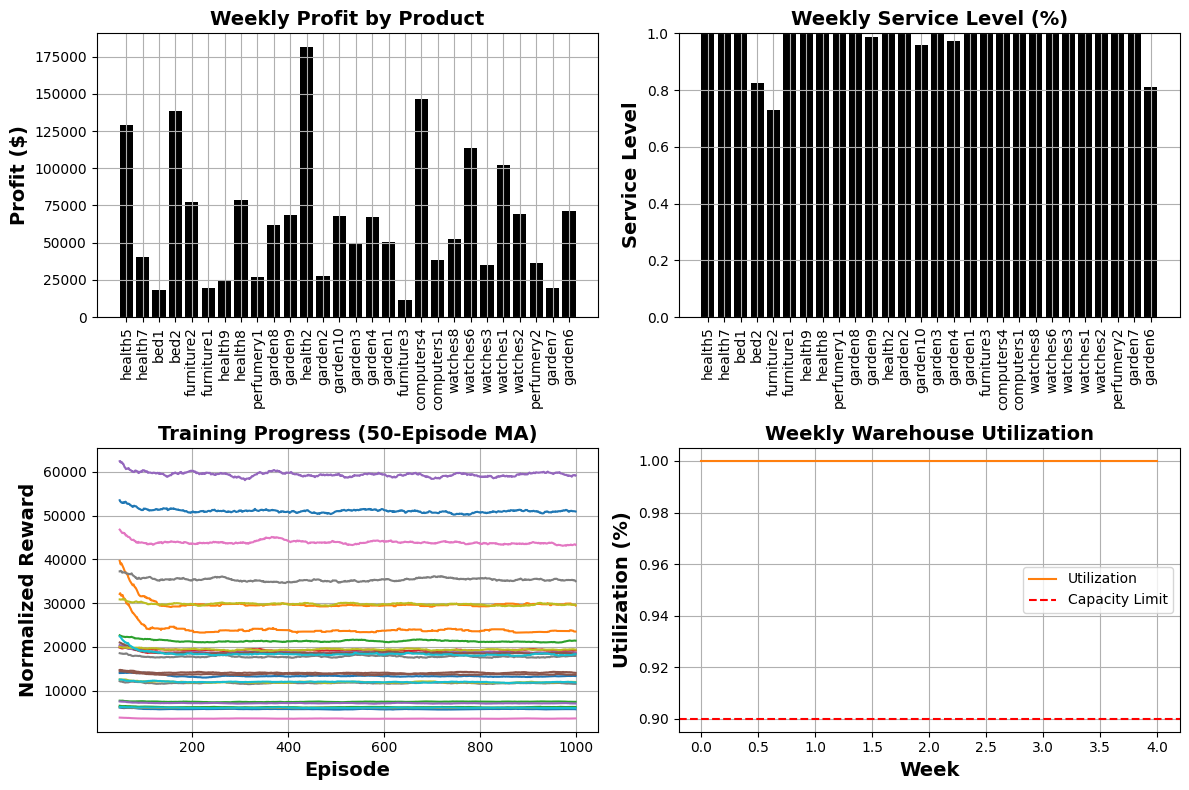

Report saved to retail_optimization_report.pkl


In [ ]:
class OptimizedSingleProductEnv:
    def __init__(self, demand_series: List[int], ref_price: float,
                 init_inventory: int = 500,
                 lead_time: int = 1,
                 elasticity: float = -0.8,
                 holding_rate: float = 0.015,
                 stockout_penalty: float = 5.0,
                 order_cost: float = 0.5,
                 safety_stock: int = 10,
                 service_weight: float = 100.0):

        self.service_weight = service_weight
        self.original_demand = [max(1, int(d)) for d in demand_series]
        self.ref_price = max(0.1, float(ref_price))
        self.weeks = len(self.original_demand)
        self.init_inventory = max(0, int(init_inventory))
        self.lead_time = min(max(1, int(lead_time)), self.weeks-1)
        self.elasticity = max(-5.0, min(0.0, float(elasticity)))
        self.holding_rate = max(0.0, float(holding_rate))
        self.stockout_penalty = max(0.0, float(stockout_penalty))
        self.order_cost = max(0.0, float(order_cost))
        self.safety_stock = max(0, int(safety_stock))
        self._calculate_demand_variability()
        self.reset()

    def _calculate_demand_variability(self):
        try:
            if self.weeks > self.lead_time:
                lt_demands = [sum(self.original_demand[i:i+self.lead_time])
                              for i in range(len(self.original_demand)-self.lead_time+1)]
                self.std_demand_lead_time = np.std(lt_demands) if len(lt_demands) > 1 else 3.0
            else:
                self.std_demand_lead_time = np.std(self.original_demand) if len(self.original_demand) > 1 else 3.0
        except:
            self.std_demand_lead_time = 3.0

    def reset(self):
        self.current_week = 0
        self.inventory = self.init_inventory
        self.total_profit = 0
        self.total_demand = 0
        self.total_sales = 0
        self.weekly_stats = []
        return self._get_state()

    def _get_state(self):
        return {
            'inventory': self.inventory,
            'current_week': self.current_week,
            'demand': self.original_demand[self.current_week] if self.current_week < self.weeks else 0,
            'avg_demand': np.mean(self.original_demand[:self.current_week+1]) if self.current_week > 0 else 0}

    def step(self, price: float, order_qty: int = 0) -> float:
        if self.current_week >= self.weeks:
            return 0.0

        try:
            base_demand = self.original_demand[self.current_week]
            price_factor = (max(0.1, price) / self.ref_price) ** self.elasticity
            noise = np.random.normal(0, 0.1 * base_demand)
            demand = max(1, int(base_demand * price_factor + noise))

            self.inventory += order_qty
            available = max(self.inventory - self.safety_stock, 0)
            sales_qty = min(available, demand)

            revenue = sales_qty * price
            holding_cost = self.inventory * self.holding_rate
            stockout_cost = max(demand - sales_qty, 0) * self.stockout_penalty
            order_cost = order_qty * self.order_cost
            profit = revenue - holding_cost - stockout_cost - order_cost
            service_level = sales_qty / demand if demand > 0 else 0.0
            reward = profit + self.service_weight * service_level

            prev_inventory = self.inventory
            self.inventory -= sales_qty
            self.total_profit += profit
            self.total_demand += demand
            self.total_sales += sales_qty

            self.weekly_stats.append({
                'week': self.current_week,
                'price': price,
                'order_qty': order_qty,
                'inventory': self.inventory,
                'demand': demand,
                'sales': sales_qty,
                'profit': profit,
                'service_level': service_level,
                'inventory_change': self.inventory - prev_inventory})

            self.current_week += 1
            return reward

        except Exception as e:
            print(f"Error in step: {str(e)}")
            return 0.0

    def service_level(self) -> float:

        if self.total_demand > 0:
            return self.total_sales / self.total_demand
        else:
            return 0.0

class MultiProductRetailEnv:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]],
                 warehouse_capacity: int = 4412,
                 shared_transport_cost: float = 0.2):
        self.products = {}
        self.warehouse_capacity = warehouse_capacity
        self.shared_transport_cost = shared_transport_cost
        self.current_week = 0
        self.shared_shipment_count = 0
        self.shared_costs = 0
        self.total_orders_this_week = defaultdict(int)
        self.weekly_warehouse_utilization = []
        self.metrics = {
            'shared_costs_total': 0,
            'over_utilization_penalties': 0,
            'cumulative_rewards': defaultdict(float)}

        for product_id, (demand_series, price_series, ref_price) in products_data.items():
            try:
                self.products[product_id] = {
                    'env': OptimizedSingleProductEnv(demand_series, ref_price),
                    'pending_orders': [],
                    'inventory': 0,
                    'space_required': max(1, int(ref_price/15))}
            except Exception as e:
                print(f"Error initializing product {product_id}: {str(e)}")
                continue

        if not self.products:
            raise ValueError("No valid products initialized")

        self.reset()

    def reset(self):
        self.current_week = 0
        self.shared_costs = 0
        self.shared_shipment_count = 0
        self.total_orders_this_week = defaultdict(int)
        self.weekly_warehouse_utilization = []
        self.metrics = {
            'shared_costs_total': 0,
            'over_utilization_penalties': 0,
            'cumulative_rewards': defaultdict(float)}

        for product_id, data in self.products.items():
            data['env'].reset()
            data['inventory'] = data['env'].init_inventory
            data['pending_orders'] = []

        return self.get_global_state()

    def get_global_state(self):
        return {
            'current_week': self.current_week,
            'warehouse_utilization': self.get_warehouse_utilization(),
            'total_orders': sum(self.total_orders_this_week.values()),
            'shared_costs': self.shared_costs}

    def get_warehouse_utilization(self):
        try:
            total_used = sum(data['inventory'] * data['space_required'] for data in self.products.values())
            return min(1.0, total_used / self.warehouse_capacity)
        except:
            return 0.0

    def step(self, actions: Dict[str, Tuple[float, int]]):
        max_weeks = max(len(data['env'].original_demand) for data in self.products.values())
        if self.current_week >= max_weeks:
            return self.get_global_state(), {}, True, {}

        individual_rewards = {}
        self.total_orders_this_week.clear()

        for product_id, (price, order_qty) in actions.items():
            if product_id not in self.products:
                continue

            if order_qty is None:
                max_order = 0
            else:
                product_data = self.products[product_id]
                max_order = self._get_max_order(product_id, order_qty)

            self.total_orders_this_week[product_id] = max_order

            if max_order > 0:
                arrival_week = self.current_week + product_data['env'].lead_time
                product_data['pending_orders'].append((arrival_week, max_order))

        for product_id, (price, order_qty) in actions.items():
            if product_id not in self.products:
                continue

            product_data = self.products[product_id]
            env = product_data['env']

            actual_order_qty = self.total_orders_this_week.get(product_id, 0)
            profit = env.step(price, actual_order_qty)

            product_data['inventory'] = env.inventory

            shared_cost_reduction = self.shared_transport_cost * len([pid for pid in actions if self.total_orders_this_week.get(pid, 0) > 0])
            individual_rewards[product_id] = profit + shared_cost_reduction

        active_orders = sum(1 for qty in self.total_orders_this_week.values() if qty > 0)
        if active_orders > 1:
            self.shared_shipment_count += 1

            self.shared_costs += self.shared_transport_cost * (active_orders - 1)
            self.metrics['shared_costs_total'] += self.shared_transport_cost * (active_orders - 1)

        self._process_order_arrivals()

        utilization = self.get_warehouse_utilization()
        self.weekly_warehouse_utilization.append(utilization)

        if utilization > 0.85:
            penalty = 50 * (utilization - 0.85)
            self.metrics['over_utilization_penalties'] += penalty
            penalty_per_product = penalty / len(individual_rewards) if individual_rewards else 0
            for product_id in individual_rewards:
                individual_rewards[product_id] -= penalty_per_product

        self.current_week += 1

        done = self.current_week >= max_weeks

        return self.get_global_state(), individual_rewards, done, {}

    def _get_max_order(self, product_id: str, requested_qty: int) -> int:
        if product_id not in self.products:
            return 0

        product_data = self.products[product_id]
        space_per_unit = product_data['space_required']

        used_space = 0
        for pid, data in self.products.items():
            current_inventory_space = data['inventory'] * data['space_required']
            pending_space = sum(qty * data['space_required'] for week, qty in data['pending_orders'] if week > self.current_week)
            used_space += current_inventory_space + pending_space

        available_space = max(0, self.warehouse_capacity - used_space)
        max_possible = available_space // space_per_unit
        return min(requested_qty, max_possible)

    def _process_order_arrivals(self):
        for product_id, product_data in self.products.items():
            arrived_qty = sum(qty for week, qty in product_data['pending_orders'] if week == self.current_week)
            product_data['inventory'] += arrived_qty
            product_data['pending_orders'] = [
                (week, qty) for week, qty in product_data['pending_orders']
                if week > self.current_week]

    def summarize(self):
        summary = {
            'total_weeks': self.current_week,
            'avg_utilization': np.mean(self.weekly_warehouse_utilization) if self.weekly_warehouse_utilization else 0,
            'shared_shipments': self.shared_shipment_count,
            'shared_costs_total': self.metrics['shared_costs_total'],
            'over_utilization_penalties': self.metrics['over_utilization_penalties'],
            'cumulative_rewards': defaultdict(float), # Corrected key and used cumulative_rewards
            'product_service_levels': {pid: round(data['env'].service_level(), 3)
                                       for pid, data in self.products.items()}}
        return summary

class OptimizedProductAgent(nn.Module):
    def __init__(self,
                 input_size: int = 5,
                 hidden_size: int = 64,
                 price_bins: int = 10,
                 order_bins: int = 11,
                 lr: float = 0.001):
        super().__init__()

        self.price_bins_count = price_bins
        self.order_bins_count = order_bins
        self.action_size = price_bins * order_bins

        self.price_bins = np.linspace(0.6, 1.4, self.price_bins_count)
        self.order_bins = np.linspace(0, 50, self.order_bins_count)

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size))

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        self.memory = []
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = 128
        self.target_update_freq = 50
        self.steps = 0
        self.target_net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size))
        self._update_target_net()

    def _update_target_net(self):
        self.target_net.load_state_dict(self.net.state_dict())

    def forward(self, x):
        return self.net(x)

    def get_action(self, state: Dict) -> Tuple[float, int]:
        if random.random() < self.epsilon:
            price_idx = random.randint(0, len(self.price_bins)-1)
            order_idx = random.randint(0, len(self.order_bins)-1)
            return self.price_bins[price_idx], self.order_bins[order_idx]

        state_tensor = torch.FloatTensor([
            state['inventory'],
            state['demand'],
            state['avg_demand'],
            state['global']['warehouse_utilization'],
            state['global']['current_week'] / 52])

        with torch.no_grad():
            q_values = self(state_tensor)
            q_values_2d = q_values.view(self.price_bins_count, self.order_bins_count)
            max_idx = torch.argmax(q_values_2d)
            price_idx = max_idx // self.order_bins_count
            order_idx = max_idx % self.order_bins_count

        return self.price_bins[price_idx], self.order_bins[order_idx]

    def act(self, state: List) -> Tuple[float, int]:
        if random.random() < self.epsilon:
            return random.uniform(0.6, 1.4), random.randint(0, 50)

        state_tensor = torch.FloatTensor(state)

        with torch.no_grad():
            q_values = self(state_tensor.unsqueeze(0))
            action_idx = torch.argmax(q_values).item()

            price_idx = action_idx // self.order_bins_count
            order_idx = action_idx % self.order_bins_count

            price_factor = self.price_bins[price_idx]
            order_qty = self.order_bins[order_idx]

        return price_factor, int(order_qty)

    def remember(self, state, action, reward, next_state, done=False):
        if isinstance(state, dict):
            price, order = action
            price_idx = np.argmin(np.abs(self.price_bins - price))
            order_idx = np.argmin(np.abs(self.order_bins - order))
            action_idx = price_idx * self.order_bins_count + order_idx

            state_tensor = [
                state['inventory'],
                state['demand'],
                state['avg_demand'],
                state['global']['warehouse_utilization'],
                state['global']['current_week'] / 52]
            next_state_tensor = [
                next_state['inventory'],
                next_state['current_week'],
                next_state['demand'],
                next_state['avg_demand'],
                next_state['global']['warehouse_utilization'],
                next_state['global']['current_week'] / 52] if next_state is not None else [0,0,0,0,0,0]

        else:
            price_factor, order_qty = action
            price_idx = np.argmin(np.abs(self.price_bins - price_factor))
            order_idx = np.argmin(np.abs(self.order_bins - order_qty))
            action_idx = price_idx * self.order_bins_count + order_idx

            state_tensor = state
            next_state_tensor = next_state if next_state is not None else [0,0,0,0]

        self.memory.append((state_tensor, action_idx, reward, next_state_tensor))

    def replay(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        states, action_indices, rewards, next_states = zip(*batch)

        state_tensors = torch.FloatTensor(states)
        next_state_tensors = torch.FloatTensor(next_states)
        action_tensors = torch.LongTensor(action_indices).unsqueeze(1)
        reward_tensors = torch.FloatTensor(rewards)

        current_q = self(state_tensors).gather(1, action_tensors)

        with torch.no_grad():
            next_q = self.target_net(next_state_tensors).max(1)[0]
            target_q = reward_tensors + self.gamma * next_q

        loss = nn.SmoothL1Loss()(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)
        self.optimizer.step()

        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self._update_target_net()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

class OptimizedMultiAgentCoordinator:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]]):
        if not products_data:
            raise ValueError("No products data provided")

        self.env = MultiProductRetailEnv(products_data)
        self.agents = {}
        self.rewards_history = defaultdict(list)
        self.metrics = {'total_episode_rewards': []}

        for product_id, (demand_series, price_series, ref_price) in products_data.items():
            self.agents[product_id] = OptimizedProductAgent(
                input_size=4,
                price_bins=10,
                order_bins=11)

    def train(self, episodes: int = 100, eval_every: int = 50, batch_size=32):
        max_weeks = max([len(data['env'].original_demand) for data in self.env.products.values()])

        for ep in range(episodes):
            self.env.reset()
            episode_rewards = defaultdict(float)
            done = False

            for week in range(max_weeks):
                actions = {}

                for pid, agent in self.agents.items():
                    if self.env.products[pid]['env'].current_week < self.env.products[pid]['env'].weeks:
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        agent_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        price_factor, order_qty = agent.act(agent_state)
                        actual_price = price_factor * self.env.products[pid]['env'].ref_price
                        actions[pid] = (actual_price, order_qty)
                    else:
                        actions[pid] = (None, None)


                global_state, individual_rewards, done, _ = self.env.step(actions)

                for pid, reward in individual_rewards.items():
                    if pid in actions and actions[pid][0] is not None:
                        episode_rewards[pid] += reward

                        agent_state_data = self.env.products[pid]['env']._get_state()
                        current_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]

                        next_agent_state_data = self.env.products[pid]['env']._get_state()
                        next_state = [
                            next_agent_state_data['inventory'],
                            next_agent_state_data['current_week'],
                            next_agent_state_data['demand'],
                            next_agent_state_data['avg_demand']]

                        self.agents[pid].remember(
                            current_state,
                            (price_factor, order_qty),
                            reward,
                            next_state)


                        self.agents[pid].decay_epsilon()

                if done:
                    break

            for pid, agent in self.agents.items():
                agent.replay(batch_size)

            total_episode_reward = sum(episode_rewards.values())
            self.metrics['total_episode_rewards'].append(total_episode_reward)

            for pid, reward in episode_rewards.items():
                self.rewards_history[pid].append(reward)

            if (ep+1) % eval_every == 0:
                print(f"Episode {ep+1}/{episodes} | Total Reward: {total_episode_reward:.2f}")

        return self.rewards_history, self.env

    def evaluate(self, num_episodes: int = 10):
        results = {}

        for pid in self.agents.keys():
            results[pid] = {
                'total_profit': 0,
                'total_demand': 0,
                'total_sales': 0,
                'weekly_stats': []}

        max_weeks = max([len(data['env'].original_demand) for data in self.env.products.values()])

        for _ in range(num_episodes):
            self.env.reset()

            for week in range(max_weeks):
                actions = {}

                for pid, agent in self.agents.items():
                    if self.env.products[pid]['env'].current_week < self.env.products[pid]['env'].weeks:
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        agent_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        price_factor, order_qty = agent.act(agent_state)
                        actual_price = price_factor * self.env.products[pid]['env'].ref_price
                        actions[pid] = (actual_price, order_qty)
                    else:
                        actions[pid] = (None, None)

                global_state, individual_rewards, done, _ = self.env.step(actions)

                for pid in self.agents.keys():
                    if pid in self.env.products:
                        env = self.env.products[pid]['env']
                        results[pid]['total_profit'] += env.total_profit
                        results[pid]['total_demand'] += env.total_demand
                        results[pid]['total_sales'] += env.total_sales
                        latest_weekly_stat = next(
                            (item for item in reversed(env.weekly_stats) if item['week'] == env.current_week - 1),
                            None)

                        if latest_weekly_stat:
                             results[pid]['weekly_stats'].append(latest_weekly_stat)

                if done:
                    break

        for pid in results.keys():
            results[pid]['total_profit'] /= num_episodes
            results[pid]['total_demand'] /= num_episodes
            results[pid]['total_sales'] /= num_episodes
            results[pid]['service_level'] = results[pid]['total_sales'] / results[pid]['total_demand'] if results[pid]['total_demand'] > 0 else 0

        return results

def generate_performance_report(results, env):
    inventory_metrics = {}

    for pid, stats in results.items():
        inventory_levels = [w['inventory'] for w in stats['weekly_stats']]
        avg_inventory = np.mean(inventory_levels)
        inventory_turnover = stats['total_sales'] / avg_inventory if avg_inventory > 0 else 0
        stockout_weeks = sum(1 for w in stats['weekly_stats'] if w.get('service_level', 1) < 0.5)
        avg_service = np.mean([w.get('service_level', 0) for w in stats['weekly_stats']])

        inventory_metrics[pid] = {
            'avg_inventory': avg_inventory,
            'inventory_turnover': inventory_turnover,
            'stockout_weeks': stockout_weeks,
            'max_inventory': max(inventory_levels) if inventory_levels else 0,
            'min_inventory': min(inventory_levels) if inventory_levels else 0,
            'avg_service': avg_service,
            'avg_demand': np.mean([w.get('demand', 0) for w in stats['weekly_stats']])}

    total_profit = sum(stats['total_profit'] for stats in results.values())
    profit_share = {pid: stats['total_profit'] / total_profit for pid, stats in results.items()}

    report = {
        'summary_metrics': {
            'total_profit': total_profit,
            'avg_service_level': np.mean([metrics['avg_service'] for metrics in inventory_metrics.values()]),
            'warehouse_stats': {
                'peak_utilization': max(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'avg_utilization': np.mean(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'overcapacity_weeks': sum(u > 0.85 for u in env.weekly_warehouse_utilization)},
            'shared_shipments': env.shared_shipment_count,
            'shared_costs_total': env.metrics['shared_costs_total'],
            'over_utilization_penalties': env.metrics['over_utilization_penalties'],
            'cumulative_rewards': dict(env.metrics['cumulative_rewards']),
            'product_service_levels': {pid: round(data['env'].service_level(), 3) for pid, data in env.products.items()},
            'profit_share': profit_share},
        'product_breakdown': {
            pid: {**stats, **inventory_metrics[pid]} for pid, stats in results.items()}}

    return report

def create_visualizations(report, rewards_history, env):
    products = list(report['product_breakdown'].keys())
    colors = plt.cm.get_cmap('tab10', len(products)).colors

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    ax1 = axes[0, 0]
    profits = [report['product_breakdown'][p]['total_profit'] for p in products]
    ax1.bar(products, profits, color='k')
    ax1.set_title('Weekly Profit by Product', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Profit ($)', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=90)
    ax1.tick_params(axis='y')
    ax1.grid()

    ax2 = axes[0, 1]
    service_levels = [report['product_breakdown'][p]['service_level'] for p in products]
    ax2.bar(products, service_levels, color='k')
    ax2.set_title('Weekly Service Level (%)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Service Level', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='y')
    ax2.set_ylim(0, 1.0)
    ax2.grid()
    ax2.tick_params(axis='x', rotation=90)

    ax3 = axes[1, 0]
    for i, (pid, rewards) in enumerate(rewards_history.items()):
        ax3.plot(pd.Series(rewards).rolling(50).mean(), label=pid, color=colors[i % len(colors)]) # Use modulo for color index
    ax3.set_title('Training Progress (50-Episode MA)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Episode', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Normalized Reward', fontsize=14, fontweight='bold')
    # ax3.legend()
    ax3.grid(True)

    ax4 = axes[1, 1]
    ax4.plot(env.weekly_warehouse_utilization, label='Utilization', color=colors[3])
    ax4.axhline(y=0.9, color='r', linestyle='--', label='Capacity Limit')
    ax4.set_title('Weekly Warehouse Utilization', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Week', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Utilization (%)', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid()


    plt.tight_layout()
    plt.show()


def generate_performance_report(results, env):
    inventory_metrics = {}
    for pid, stats in results.items():
        inventory_levels = [w['inventory'] for w in stats['weekly_stats']]
        avg_inventory = np.mean(inventory_levels)
        inventory_turnover = stats['total_sales'] / avg_inventory if avg_inventory > 0 else 0
        stockout_weeks = sum(1 for w in stats['weekly_stats'] if w['service_level'] < 0.5)
        avg_service = np.mean([w['service_level'] for w in stats['weekly_stats']])

        inventory_metrics[pid] = {
            'avg_inventory': avg_inventory,
            'inventory_turnover': inventory_turnover,
            'stockout_weeks': stockout_weeks,
            'max_inventory': max(inventory_levels) if inventory_levels else 0,
            'min_inventory': min(inventory_levels) if inventory_levels else 0,
            'avg_service': avg_service,
            'avg_demand': np.mean([w['demand'] for w in stats['weekly_stats']])}

    total_profit = sum(stats['total_profit'] for stats in results.values())
    profit_share = {pid: stats['total_profit'] / total_profit for pid, stats in results.items()}

    report = {
        'summary_metrics': {
            'total_profit': total_profit,
            'avg_service_level': np.mean([inventory_metrics[pid]['avg_service'] for pid in inventory_metrics.keys()]),
            'warehouse_stats': {
                'peak_utilization': max(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'avg_utilization': np.mean(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'overcapacity_weeks': sum(u > 0.85 for u in env.weekly_warehouse_utilization)},
            'shared_shipments': env.shared_shipment_count,
            'shared_costs_total': env.metrics['shared_costs_total'],
            'profit_share': profit_share},
        'product_breakdown': {
            pid: {**stats, **inventory_metrics[pid]}
            for pid, stats in results.items()}}
    return report

def generate_executive_summary(report):
    sm = report['summary_metrics']
    products = report['product_breakdown']

    best_product = max(products.items(), key=lambda x: x[1]['avg_service'])
    worst_product = min(products.items(), key=lambda x: x[1]['avg_service'])
    most_profitable = max(products.items(), key=lambda x: x[1]['total_profit'])

    summary = f"""
    RETAIL OPTIMIZATION REPORT - WEEKLY OPERATIONS
    {'=' * 70}

    SYSTEM PERFORMANCE SUMMARY
    {'-' * 70}
    • Total Profit: ${sm['total_profit']:,.2f}
    • Average Service Level: {sm['avg_service_level']:.1%}
      (Target: 70%+, Current Gap: {(0.7 - sm['avg_service_level']):.1%})
    • Warehouse Utilization:
      - Peak: {sm['warehouse_stats']['peak_utilization']:.1%}
      - Average: {sm['warehouse_stats']['avg_utilization']:.1%}
      - Overcapacity Weeks: {sm['warehouse_stats']['overcapacity_weeks']}
    • Shared Shipments: {sm['shared_shipments']} (Cost Savings: ${sm['shared_costs_total']:,.2f}) # Corrected key and used shared_costs_total


    PRODUCT PERFORMANCE HIGHLIGHTS
    {'-' * 70}
    • Best Service: {best_product[0]} ({best_product[1]['avg_service']:.1%})
    • Worst Service: {worst_product[0]} ({worst_product[1]['avg_service']:.1%})
    • Most Profitable: {most_profitable[0]} (${most_profitable[1]['total_profit']:,.2f})

    KEY RECOMMENDATIONS
    {'-' * 70}"""

    if sm['warehouse_stats']['avg_utilization'] < 0.7:
        summary += "\n• Warehouse space underutilized - consider consolidation"
    elif sm['warehouse_stats']['avg_utilization'] > 0.9:
        summary += "\n• Warehouse frequently at capacity - optimize space allocation"

    if sm['avg_service_level'] < 0.9:
        summary += "\n• Service levels below target - review safety stocks"
    elif sm['avg_service_level'] > 0.98:
        summary += "\n• Service levels very high - opportunity to reduce inventory"

    low_service_products = [
        (pid, data) for pid, data in products.items()
        if data['avg_service'] < 0.5]
    if low_service_products:
        summary += "\n\nCRITICAL PRODUCTS NEEDING ATTENTION:"
        for pid, data in sorted(low_service_products, key=lambda x: x[1]['avg_service'])[:3]:
            summary += f"\n  - {pid}: Service Level {data['avg_service']:.1%} (Stockouts: {data['stockout_weeks']} weeks)"

    return summary

def generate_full_report(env, rewards_history):
    results = coordinator.evaluate()
    performance_report = generate_performance_report(results, env)

    report_package = {
        'executive_summary': generate_executive_summary(performance_report),
        'performance_metrics': performance_report,
        'training_history': rewards_history,
        'environment_state': env,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

    return report_package

def save_report(report, filename='retail_optimization_report.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(report, f)
    print(f"Report saved to {filename}")

def load_report(filename='retail_optimization_report.pkl'):
    with open(filename, 'rb') as f:
        return pickle.load(f)

if __name__ == "__main__":
    print(f"\nFound {len(products_data)} products with sufficient weekly data")
    coordinator = OptimizedMultiAgentCoordinator(products_data)
    rewards_history, final_env = coordinator.train(episodes=1000)

    full_report = generate_full_report(final_env, rewards_history)
    print("\n" + "=" * 80)
    print(full_report['executive_summary'])
    print("=" * 80)

    create_visualizations(
        full_report['performance_metrics'],
        full_report['training_history'],
        final_env)

    save_report(full_report)

    def export_key_tables(report):
        product_data = []
        for pid, stats in report['performance_metrics']['product_breakdown'].items():
            product_data.append({
                'product_id': pid,
                'total_profit': stats['total_profit'],
                'avg_service_level': stats['avg_service'],
                'avg_inventory': stats['avg_inventory'],
                'inventory_turns': stats['inventory_turnover'],
                'stockout_weeks': stats['stockout_weeks'],
                'profit_share': report['performance_metrics']['summary_metrics']['profit_share'][pid]})
        pd.DataFrame(product_data).to_csv('product_performance.csv', index=False)

    export_key_tables(full_report)

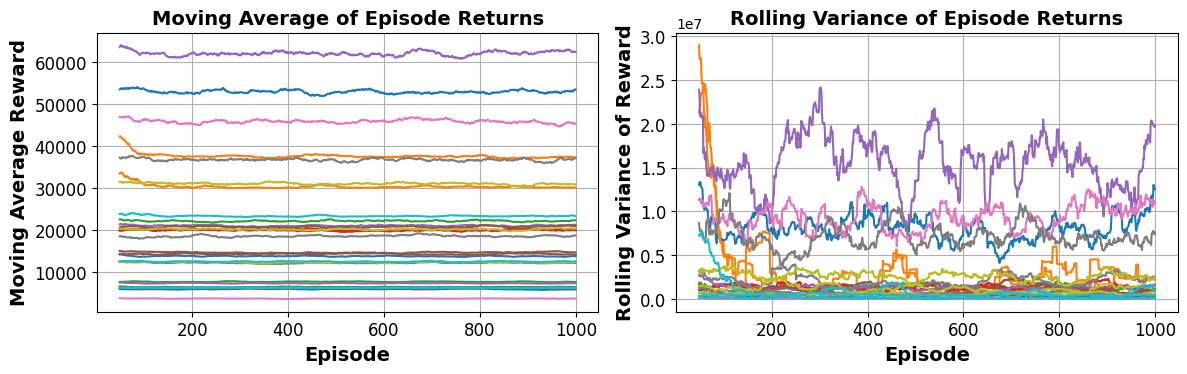

In [ ]:
def analyze_convergence(rewards_history, window_size=50):
    convergence_metrics = {}
    for pid, rewards in rewards_history.items():
        rewards_series = pd.Series(rewards)
        moving_avg = rewards_series.rolling(window=window_size).mean()
        rolling_variance = rewards_series.rolling(window=window_size).var()

        convergence_metrics[pid] = {
            'moving_avg_return': moving_avg,
            'rolling_variance_return': rolling_variance}
    return convergence_metrics
convergence_data = analyze_convergence(rewards_history)

def plot_convergence_metrics(convergence_data):
    products = convergence_data.keys()
    num_products = len(products)
    colors = plt.cm.get_cmap('tab10', num_products).colors
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    ax1 = axes[0]
    for i, pid in enumerate(products):
        ax1.plot(convergence_data[pid]['moving_avg_return'], label=f'{pid} (MA)', color=colors[i % len(colors)])
    ax1.set_title('Moving Average of Episode Returns', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Episode', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Moving Average Reward', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.grid()

    ax2 = axes[1]
    for i, pid in enumerate(products):
        ax2.plot(convergence_data[pid]['rolling_variance_return'], label=f'{pid} (Variance)', color=colors[i % len(colors)])
    ax2.set_title('Rolling Variance of Episode Returns', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Episode', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Rolling Variance of Reward', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.grid()

    plt.tight_layout()
    plt.show()

plot_convergence_metrics(convergence_data)


Found 28 products with sufficient weekly data
Episode 50/1000 | Total Reward: 627708.56
Episode 100/1000 | Total Reward: 649290.12
Episode 150/1000 | Total Reward: 663078.31
Episode 200/1000 | Total Reward: 649417.80
Episode 250/1000 | Total Reward: 653448.72
Episode 300/1000 | Total Reward: 632581.03
Episode 350/1000 | Total Reward: 647143.15
Episode 400/1000 | Total Reward: 643635.96
Episode 450/1000 | Total Reward: 656657.29
Episode 500/1000 | Total Reward: 674384.14
Episode 550/1000 | Total Reward: 621597.57
Episode 600/1000 | Total Reward: 642682.53
Episode 650/1000 | Total Reward: 620227.92
Episode 700/1000 | Total Reward: 647912.47
Episode 750/1000 | Total Reward: 663454.95
Episode 800/1000 | Total Reward: 642779.65
Episode 850/1000 | Total Reward: 642552.14
Episode 900/1000 | Total Reward: 655024.45
Episode 950/1000 | Total Reward: 646156.97
Episode 1000/1000 | Total Reward: 618114.77


    REINFORCEMENT LEARNING CONVERGENCE REPORT
    Training Episodes: 1000
    Number of Pro

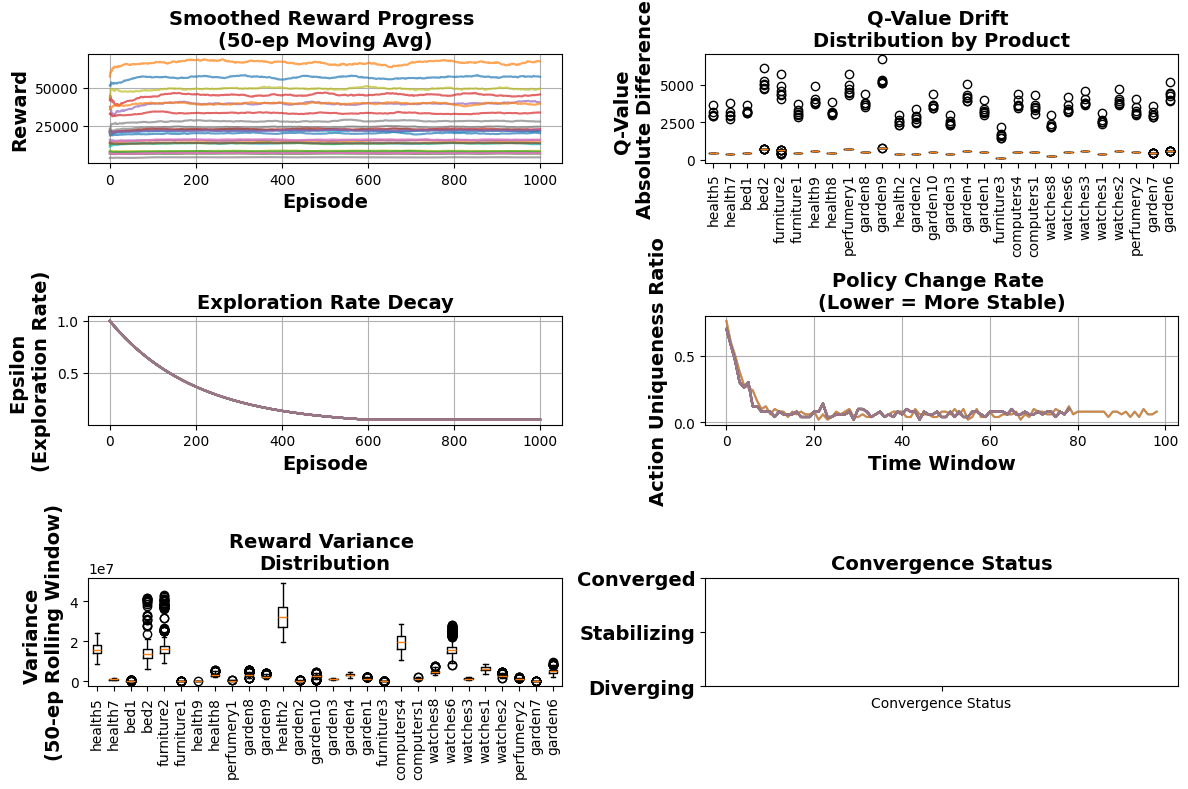

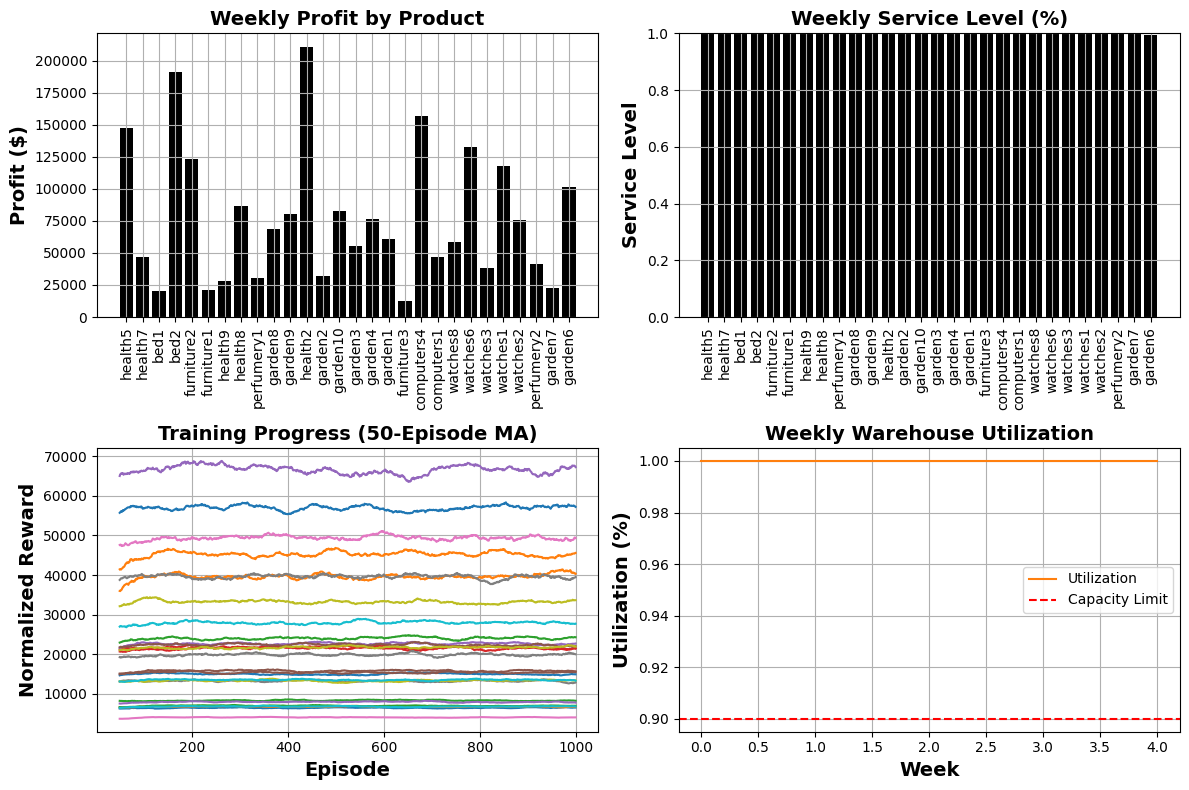

Report saved to retail_optimization_report.pkl


In [ ]:
def calculate_convergence_metrics(rewards_history, env, agents):
    metrics = {}

    policy_changes = []
    for pid, agent in agents.items():
        if hasattr(agent, 'memory') and len(agent.memory) > 100:
            recent_actions = [mem[1] for mem in agent.memory[-100:]]
            pcr = len(set(recent_actions)) / len(recent_actions)
            policy_changes.append(pcr)
    metrics['policy_change_rate'] = np.mean(policy_changes) if policy_changes else 0

    q_drifts = []
    for pid, agent in agents.items():
        if hasattr(agent, 'memory') and len(agent.memory) > 50:
            recent_q_changes = []
            for i in range(len(agent.memory)-50, len(agent.memory)-1):
                state, action, reward, next_state = agent.memory[i]
                state_tensor = torch.FloatTensor(state)
                with torch.no_grad():
                    current_q = agent(state_tensor.unsqueeze(0))[0, action].item()
                    next_q = agent.target_net(torch.FloatTensor(next_state).unsqueeze(0)).max().item()
                q_drift = abs(current_q - next_q)
                recent_q_changes.append(q_drift)
            q_drifts.append(np.mean(recent_q_changes))
    metrics['q_value_drift'] = np.mean(q_drifts) if q_drifts else 0

    episode_rewards = []
    for pid, rewards in rewards_history.items():
        if rewards:
            episode_rewards.append(np.mean(rewards[-20:]))
    metrics['avg_episode_reward'] = np.mean(episode_rewards) if episode_rewards else 0

    return_variances = []
    window_size = 50
    for pid, rewards in rewards_history.items():
        if len(rewards) > window_size:
            rolling_variance = pd.Series(rewards).rolling(window=window_size).var().dropna()
            return_variances.extend(rolling_variance.tolist())
    metrics['return_variance'] = np.mean(return_variances) if return_variances else 0

    exploration_rates = []
    for pid, agent in agents.items():
        exploration_rates.append(agent.epsilon)
    metrics['exploration_rate'] = np.mean(exploration_rates)

    stability_scores = []
    for pid, rewards in rewards_history.items():
        if len(rewards) > 100:
            recent_rewards = rewards[-100:]
            trend = np.polyfit(range(len(recent_rewards)), recent_rewards, 1)[0]
            volatility = np.std(recent_rewards)
            stability = 1 / (1 + abs(trend) + volatility)
            stability_scores.append(stability)
    metrics['stability_score'] = np.mean(stability_scores) if stability_scores else 0

    if metrics['q_value_drift'] < 0.1 and metrics['policy_change_rate'] < 0.2:
        metrics['convergence_status'] = "CONVERGED"
    elif metrics['q_value_drift'] < 0.3 and metrics['policy_change_rate'] < 0.4:
        metrics['convergence_status'] = "STABILIZING"
    else:
        metrics['convergence_status'] = "DIVERGING"

    return metrics

def generate_convergence_report(rewards_history, env, agents, episodes):
    metrics = calculate_convergence_metrics(rewards_history, env, agents)

    report = f"""
    REINFORCEMENT LEARNING CONVERGENCE REPORT
    {'=' * 60}
    Training Episodes: {episodes}
    Number of Products: {len(agents)}
    Timestamp: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

    CONVERGENCE METRICS:
    {'-' * 60}
    • Policy Change Rate: {metrics['policy_change_rate']:.4f}
      - Measures how frequently agents change their action selection
      - Ideal: < 0.2 (stable policy)
      - Current: {'✓ STABLE' if metrics['policy_change_rate'] < 0.2 else '⚠ CHANGING'}

    • Q-Value Drift: {metrics['q_value_drift']:.4f}
      - Measures stability of value function estimates
      - Ideal: < 0.1 (stable Q-values)
      - Current: {'✓ STABLE' if metrics['q_value_drift'] < 0.1 else '⚠ DRIFTING'}

    • Average Episode Reward: {metrics['avg_episode_reward']:.2f}
      - Recent average performance across all products

    • Return Variance (50-ep window): {metrics['return_variance']:.4f}
      - Measures reward consistency over time
      - Lower values indicate more stable learning

    • Exploration Rate: {metrics['exploration_rate']:.4f}
      - Current epsilon-greedy exploration probability
      - Target minimum: {agents[list(agents.keys())[0]].epsilon_min if agents else 'N/A'}

    • Stability Score: {metrics['stability_score']:.4f}
      - Composite measure of learning stability (0-1 scale)

    CONVERGENCE STATUS: {metrics['convergence_status']}
    {'✓' if metrics['convergence_status'] == 'CONVERGED' else '⚠' if metrics['convergence_status'] == 'STABILIZING' else '✗'}

    RECOMMENDATIONS:
    {'-' * 60}"""

    if metrics['convergence_status'] == "DIVERGING":
        report += f"""
    • CRITICAL: System is diverging - consider:
      - Reducing learning rate (current: {agents[list(agents.keys())[0]].optimizer.param_groups[0]['lr'] if agents else 'N/A'})
      - Increasing target network update frequency
      - Adding gradient clipping
      - Increasing batch size"""
    elif metrics['convergence_status'] == "STABILIZING":
        report += f"""
    • Continue training - system is stabilizing
    • Monitor Q-value drift for convergence"""
    else:
        report += f"""
    • System has converged - ready for deployment
    • Consider fine-tuning with reduced exploration"""

    report += f"""

    PRODUCT-SPECIFIC ANALYSIS:
    {'-' * 60}"""

    for pid, agent in agents.items():
        product_rewards = rewards_history.get(pid, [])
        if product_rewards:
            recent_avg = np.mean(product_rewards[-20:]) if len(product_rewards) >= 20 else np.mean(product_rewards)
            trend = np.polyfit(range(len(product_rewards[-50:])), product_rewards[-50:], 1)[0] if len(product_rewards) >= 50 else 0
            report += f"""
    • {pid}:
      - Recent Avg Reward: {recent_avg:.2f}
      - 50-ep Trend: {'↑' if trend > 0.1 else '→' if abs(trend) <= 0.1 else '↓'}
      - Exploration: {agent.epsilon:.3f}"""

    return report, metrics

def plot_convergence_diagnostics(rewards_history, metrics, agents):
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))

    ax1 = axes[0, 0]
    for pid, rewards in rewards_history.items():
        smoothed = pd.Series(rewards).rolling(window=50, min_periods=1).mean()
        ax1.plot(smoothed, label=pid, alpha=0.7)
    ax1.set_title('Smoothed Reward Progress \n(50-ep Moving Avg)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Episode',fontsize=14, fontweight='bold')
    ax1.set_ylabel('Reward',fontsize=14, fontweight='bold')
    # ax1.legend()
    ax1.grid(True)

    ax2 = axes[0, 1]
    q_drifts_by_product = []
    product_names = []
    for pid, agent in agents.items():
        if hasattr(agent, 'memory') and len(agent.memory) > 100:
            recent_q_changes = []
            for i in range(max(0, len(agent.memory)-100), len(agent.memory)-1):
                state, action, reward, next_state = agent.memory[i]
                state_tensor = torch.FloatTensor(state)
                with torch.no_grad():
                    current_q = agent(state_tensor.unsqueeze(0))[0, action].item()
                    next_q = agent.target_net(torch.FloatTensor(next_state).unsqueeze(0)).max().item()
                recent_q_changes.append(abs(current_q - next_q))
            q_drifts_by_product.append(recent_q_changes)
            product_names.append(pid)

    if q_drifts_by_product:
        ax2.boxplot(q_drifts_by_product, labels=product_names)
        ax2.set_title('Q-Value Drift \nDistribution by Product', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Q-Value \nAbsolute Difference', fontsize=14, fontweight='bold')
        ax2.tick_params(axis='x', rotation=90)

    ax3 = axes[1, 0]
    exploration_history = {pid: [] for pid in agents.keys()}
    for pid, agent in agents.items():
        eps = 1.0
        decay = agent.epsilon_decay
        min_eps = agent.epsilon_min
        history = []
        for _ in range(1000):
            history.append(eps)
            eps = max(min_eps, eps * decay)
        exploration_history[pid] = history[:len(rewards_history.get(pid, []))]

    for pid, history in exploration_history.items():
        if history:
            ax3.plot(history, label=pid, alpha=0.7)
    ax3.set_title('Exploration Rate Decay', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Episode', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Epsilon \n(Exploration Rate)', fontsize=14, fontweight='bold')
    # ax3.legend()
    ax3.grid(True)

    ax4 = axes[1, 1]
    policy_stability = []
    for pid, agent in agents.items():
        if hasattr(agent, 'memory') and len(agent.memory) > 200:
            action_changes = []
            window_size = 50
            for i in range(0, len(agent.memory)-window_size, window_size):
                window_actions = [mem[1] for mem in agent.memory[i:i+window_size]]
                uniqueness = len(set(window_actions)) / len(window_actions)
                action_changes.append(uniqueness)
            policy_stability.append((pid, action_changes))

    for pid, stability in policy_stability:
        ax4.plot(stability, label=pid, alpha=0.7)
    ax4.set_title('Policy Change Rate \n(Lower = More Stable)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Time Window', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Action Uniqueness Ratio', fontsize=14, fontweight='bold')
    # ax4.legend()
    ax4.grid(True)

    ax5 = axes[2, 0]
    variances = []
    labels = []
    for pid, rewards in rewards_history.items():
        if len(rewards) > 100:
            rolling_var = pd.Series(rewards).rolling(window=50).var().dropna()
            variances.append(rolling_var.values)
            labels.append(pid)

    if variances:
        ax5.boxplot(variances, labels=labels)
        ax5.set_title('Reward Variance \nDistribution', fontsize=14, fontweight='bold')
        ax5.set_ylabel('Variance \n(50-ep Rolling Window)', fontsize=14, fontweight='bold')
        ax5.tick_params(axis='x', rotation=90)

    ax6 = axes[2, 1]
    status_codes = {'CONVERGED': 2, 'STABILIZING': 1, 'DIVERGING': 0}
    ax6.bar(['Convergence Status'], [status_codes[metrics['convergence_status']]],
            color=['red', 'yellow', 'green'][status_codes[metrics['convergence_status']]])
    ax6.set_title('Convergence Status', fontsize=14, fontweight='bold')
    ax6.set_ylim(0, 2)
    ax6.set_yticks([0, 1, 2])
    ax6.set_yticklabels(['Diverging', 'Stabilizing', 'Converged'], fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return fig

if __name__ == "__main__":
    print(f"\nFound {len(products_data)} products with sufficient weekly data")
    coordinator = OptimizedMultiAgentCoordinator(products_data)
    rewards_history, final_env = coordinator.train(episodes=1000)

    convergence_report, metrics = generate_convergence_report(
        rewards_history, final_env, coordinator.agents, episodes=1000)

    print("\n" + "=" * 80)
    print(convergence_report)
    print("=" * 80)

    plot_convergence_diagnostics(rewards_history, metrics, coordinator.agents)

    full_report = generate_full_report(final_env, rewards_history)
    create_visualizations(
        full_report['performance_metrics'],
        full_report['training_history'],
        final_env)

    save_report(full_report)
    export_key_tables(full_report)

Prepared data for 28 products (min 4 weeks)

Found 28 products with sufficient weekly data
Episode 1/1000 | Total Reward: 11091.35 | Q-Drift: 0.0000
Episode 21/1000 | Total Reward: 11347.22 | Q-Drift: 0.6071
Episode 41/1000 | Total Reward: 11356.50 | Q-Drift: 0.4918
Episode 50/1000 | Total Reward: 11238.57
Episode 61/1000 | Total Reward: 11478.93 | Q-Drift: 0.3066
Episode 81/1000 | Total Reward: 11355.02 | Q-Drift: 0.2121
Episode 100/1000 | Total Reward: 11374.03
Episode 101/1000 | Total Reward: 11355.16 | Q-Drift: 0.1618
Episode 121/1000 | Total Reward: 11369.28 | Q-Drift: 0.1681
Episode 141/1000 | Total Reward: 11480.12 | Q-Drift: 0.1245
Episode 150/1000 | Total Reward: 11479.97
Episode 161/1000 | Total Reward: 11480.44 | Q-Drift: 0.0763
Episode 181/1000 | Total Reward: 11479.95 | Q-Drift: 0.1084
Episode 200/1000 | Total Reward: 11480.18
Episode 201/1000 | Total Reward: 11480.38 | Q-Drift: 0.1465
Episode 221/1000 | Total Reward: 11480.31 | Q-Drift: 0.1555
Episode 241/1000 | Total Rew

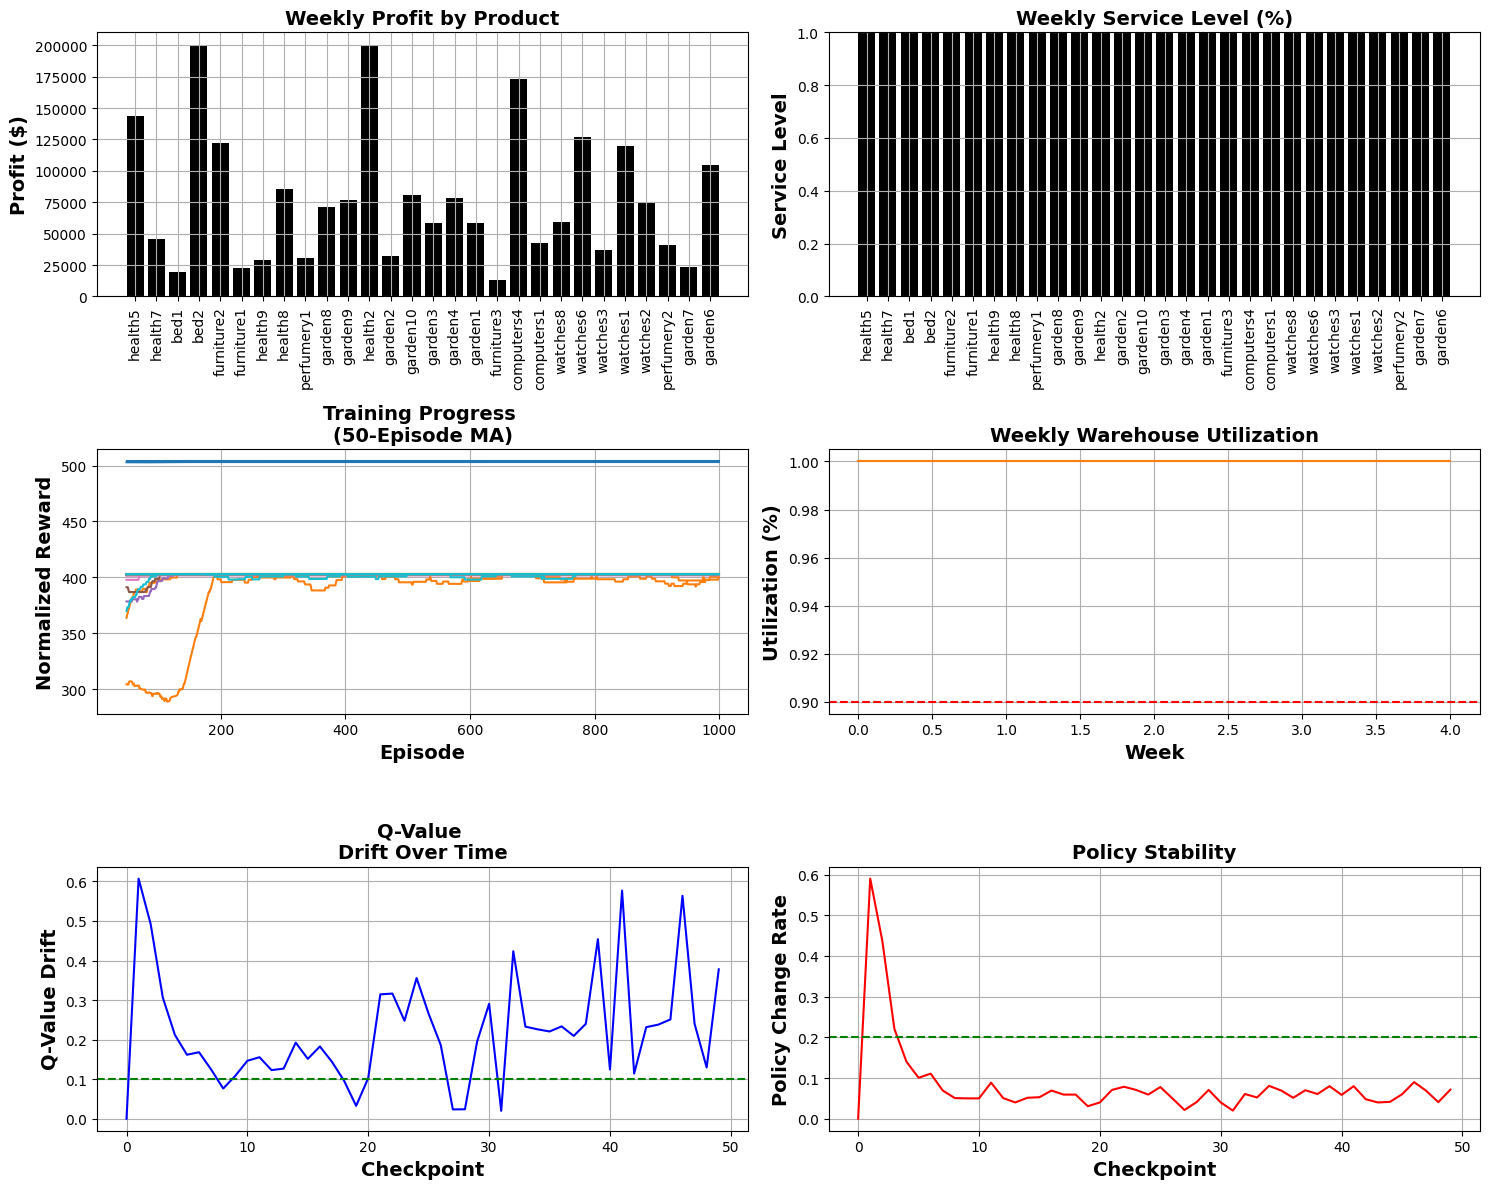

Report saved to retail_optimization_report.pkl

Final Convergence Status: DIVERGING
Final Q-Value Drift: 0.3778


In [ ]:
def prepare_weekly_data(df: pd.DataFrame, min_weeks: int = 4,
                        date_col: str = 'month_year') -> Dict[str, Tuple[List[int], List[float], float]]:
    try:
        df['date'] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.dropna(subset=['date'])

        df['year_week'] = df['date'].dt.to_period('W').astype(str)

        weekly_demand = (
            df.groupby(['product_id', 'year_week'], observed=True)['qty']
            .sum()
            .reset_index()
            .sort_values(['product_id', 'year_week']))

        product_counts = weekly_demand['product_id'].value_counts()
        valid_products = product_counts[product_counts >= min_weeks].index.tolist()

        if not valid_products:
            raise ValueError(f"No products with ≥ {min_weeks} weeks of data")

        products_data = {}
        for product_id in valid_products:
            product_demand = weekly_demand[weekly_demand['product_id'] == product_id]
            demand_series = (
                product_demand.sort_values('year_week')['qty']
                .tolist())

            price_df = (
                df[df['product_id'] == product_id]
                .groupby('year_week', observed=True)[['unit_price', 'qty']]
                .apply(lambda x: np.average(x['unit_price'], weights=x['qty']))
                .reset_index(name='weighted_price')
                .sort_values('year_week'))
            price_series = price_df['weighted_price'].tolist()

            product_data = df[df['product_id'] == product_id]
            valid_transactions = product_data[product_data['qty'] > 0]

            if len(valid_transactions) == 0:
                continue

            try:
                ref_price = np.average(
                    valid_transactions['unit_price'],
                    weights=valid_transactions['qty'])
            except:
                ref_price = valid_transactions['unit_price'].median()

            min_length = min(len(demand_series), len(price_series))
            if min_length < min_weeks:
                continue

            products_data[product_id] = (
                demand_series[:min_length],
                price_series[:min_length],
                ref_price)

        print(f"Prepared data for {len(products_data)} products (min {min_weeks} weeks)")
        return products_data

    except Exception as e:
        print(f"Data preparation failed: {str(e)}")
        return {}

class OptimizedSingleProductEnv:
    def __init__(self, demand_series: List[int], ref_price: float,
                 init_inventory: int = 500,
                 lead_time: int = 1,
                 elasticity: float = -0.8,
                 holding_rate: float = 0.015,
                 stockout_penalty: float = 5.0,
                 order_cost: float = 0.5,
                 safety_stock: int = 10,
                 service_weight: float = 100.0):

        self.service_weight = service_weight
        self.original_demand = [max(1, int(d)) for d in demand_series]
        self.ref_price = max(0.1, float(ref_price))
        self.weeks = len(self.original_demand)
        self.init_inventory = max(0, int(init_inventory))
        self.lead_time = min(max(1, int(lead_time)), self.weeks-1)
        self.elasticity = max(-5.0, min(0.0, float(elasticity)))
        self.holding_rate = max(0.0, float(holding_rate))
        self.stockout_penalty = max(0.0, float(stockout_penalty))
        self.order_cost = max(0.0, float(order_cost))
        self.safety_stock = max(0, int(safety_stock))
        self._calculate_demand_variability()
        self.reset()

    def _calculate_demand_variability(self):
        try:
            if self.weeks > self.lead_time:
                lt_demands = [sum(self.original_demand[i:i+self.lead_time])
                              for i in range(len(self.original_demand)-self.lead_time+1)]
                self.std_demand_lead_time = np.std(lt_demands) if len(lt_demands) > 1 else 3.0
            else:
                self.std_demand_lead_time = np.std(self.original_demand) if len(self.original_demand) > 1 else 3.0
        except:
            self.std_demand_lead_time = 3.0

    def reset(self):
        self.current_week = 0
        self.inventory = self.init_inventory
        self.total_profit = 0
        self.total_demand = 0
        self.total_sales = 0
        self.weekly_stats = []
        return self._get_state()

    def _get_state(self):
        return {
            'inventory': self.inventory,
            'current_week': self.current_week,
            'demand': self.original_demand[self.current_week] if self.current_week < self.weeks else 0,
            'avg_demand': np.mean(self.original_demand[:self.current_week+1]) if self.current_week > 0 else 0}

    def step(self, price: float, order_qty: int = 0) -> float:
        if self.current_week >= self.weeks:
            return 0.0

        try:
            base_demand = self.original_demand[self.current_week]
            price_factor = (max(0.1, price) / self.ref_price) ** self.elasticity
            noise = np.random.normal(0, 0.1 * base_demand)
            demand = max(1, int(base_demand * price_factor + noise))

            self.inventory += order_qty
            available = max(self.inventory - self.safety_stock, 0)
            sales_qty = min(available, demand)

            revenue = sales_qty * price
            holding_cost = self.inventory * self.holding_rate
            stockout_cost = max(demand - sales_qty, 0) * self.stockout_penalty
            order_cost = order_qty * self.order_cost
            profit = revenue - holding_cost - stockout_cost - order_cost
            service_level = sales_qty / demand if demand > 0 else 0.0

            scaled_reward = np.tanh(profit / 100.0) + self.service_weight * service_level

            prev_inventory = self.inventory
            self.inventory -= sales_qty
            self.total_profit += profit
            self.total_demand += demand
            self.total_sales += sales_qty

            self.weekly_stats.append({
                'week': self.current_week,
                'price': price,
                'order_qty': order_qty,
                'inventory': self.inventory,
                'demand': demand,
                'sales': sales_qty,
                'profit': profit,
                'service_level': service_level,
                'inventory_change': self.inventory - prev_inventory})

            self.current_week += 1
            return scaled_reward

        except Exception as e:
            print(f"Error in step: {str(e)}")
            return 0.0

    def service_level(self) -> float:
        if self.total_demand > 0:
            return self.total_sales / self.total_demand
        else:
            return 0.0

class MultiProductRetailEnv:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]],
                 warehouse_capacity: int = 4412,
                 shared_transport_cost: float = 0.2):
        self.products = {}
        self.warehouse_capacity = warehouse_capacity
        self.shared_transport_cost = shared_transport_cost
        self.current_week = 0
        self.shared_shipment_count = 0
        self.shared_costs = 0
        self.total_orders_this_week = defaultdict(int)
        self.weekly_warehouse_utilization = []
        self.metrics = {
            'shared_costs_total': 0,
            'over_utilization_penalties': 0,
            'cumulative_rewards': defaultdict(float)}

        for product_id, (demand_series, price_series, ref_price) in products_data.items():
            try:
                self.products[product_id] = {
                    'env': OptimizedSingleProductEnv(demand_series, ref_price),
                    'pending_orders': [],
                    'inventory': 0,
                    'space_required': max(1, int(ref_price/15))}
            except Exception as e:
                print(f"Error initializing product {product_id}: {str(e)}")
                continue

        if not self.products:
            raise ValueError("No valid products initialized")
        self.reset()

    def reset(self):
        self.current_week = 0
        self.shared_costs = 0
        self.shared_shipment_count = 0
        self.total_orders_this_week = defaultdict(int)
        self.weekly_warehouse_utilization = []
        self.metrics = {
            'shared_costs_total': 0,
            'over_utilization_penalties': 0,
            'cumulative_rewards': defaultdict(float)}

        for product_id, data in self.products.items():
            data['env'].reset()
            data['inventory'] = data['env'].init_inventory
            data['pending_orders'] = []
        return self.get_global_state()

    def get_global_state(self):
        return {
            'current_week': self.current_week,
            'warehouse_utilization': self.get_warehouse_utilization(),
            'total_orders': sum(self.total_orders_this_week.values()),
            'shared_costs': self.shared_costs}

    def get_warehouse_utilization(self):
        try:
            total_used = sum(data['inventory'] * data['space_required'] for data in self.products.values())
            return min(1.0, total_used / self.warehouse_capacity)
        except:
            return 0.0

    def step(self, actions: Dict[str, Tuple[float, int]]):
        max_weeks = max(len(data['env'].original_demand) for data in self.products.values())
        if self.current_week >= max_weeks:
            return self.get_global_state(), {}, True, {}

        individual_rewards = {}
        self.total_orders_this_week.clear()

        for product_id, (price, order_qty) in actions.items():
            if product_id not in self.products:
                continue
            if order_qty is None:
                max_order = 0
            else:
                product_data = self.products[product_id]
                max_order = self._get_max_order(product_id, order_qty)
            self.total_orders_this_week[product_id] = max_order
            if max_order > 0:
                arrival_week = self.current_week + product_data['env'].lead_time
                product_data['pending_orders'].append((arrival_week, max_order))

        for product_id, (price, order_qty) in actions.items():
            if product_id not in self.products:
                continue
            product_data = self.products[product_id]
            env = product_data['env']
            actual_order_qty = self.total_orders_this_week.get(product_id, 0)
            profit = env.step(price, actual_order_qty)
            product_data['inventory'] = env.inventory
            shared_cost_reduction = self.shared_transport_cost * len([pid for pid in actions if self.total_orders_this_week.get(pid, 0) > 0])
            individual_rewards[product_id] = profit + shared_cost_reduction

        active_orders = sum(1 for qty in self.total_orders_this_week.values() if qty > 0)
        if active_orders > 1:
            self.shared_shipment_count += 1
            self.shared_costs += self.shared_transport_cost * (active_orders - 1)
            self.metrics['shared_costs_total'] += self.shared_transport_cost * (active_orders - 1)

        self._process_order_arrivals()
        utilization = self.get_warehouse_utilization()
        self.weekly_warehouse_utilization.append(utilization)

        if utilization > 0.85:
            penalty = 50 * (utilization - 0.85)
            self.metrics['over_utilization_penalties'] += penalty
            penalty_per_product = penalty / len(individual_rewards) if individual_rewards else 0
            for product_id in individual_rewards:
                individual_rewards[product_id] -= penalty_per_product

        self.current_week += 1
        done = self.current_week >= max_weeks
        return self.get_global_state(), individual_rewards, done, {}

    def _get_max_order(self, product_id: str, requested_qty: int) -> int:
        if product_id not in self.products:
            return 0
        product_data = self.products[product_id]
        space_per_unit = product_data['space_required']
        used_space = 0
        for pid, data in self.products.items():
            current_inventory_space = data['inventory'] * data['space_required']
            pending_space = sum(qty * data['space_required'] for week, qty in data['pending_orders'] if week > self.current_week)
            used_space += current_inventory_space + pending_space
        available_space = max(0, self.warehouse_capacity - used_space)
        max_possible = available_space // space_per_unit
        return min(requested_qty, max_possible)

    def _process_order_arrivals(self):
        for product_id, product_data in self.products.items():
            arrived_qty = sum(qty for week, qty in product_data['pending_orders'] if week == self.current_week)
            product_data['inventory'] += arrived_qty
            product_data['pending_orders'] = [
                (week, qty) for week, qty in product_data['pending_orders']
                if week > self.current_week]

    def summarize(self):
        summary = {
            'total_weeks': self.current_week,
            'avg_utilization': np.mean(self.weekly_warehouse_utilization) if self.weekly_warehouse_utilization else 0,
            'shared_shipments': self.shared_shipment_count,
            'shared_costs_total': self.metrics['shared_costs_total'],
            'over_utilization_penalties': self.metrics['over_utilization_penalties'],
            'cumulative_rewards': dict(self.metrics['cumulative_rewards']),
            'product_service_levels': {pid: round(data['env'].service_level(), 3)
                                       for pid, data in self.products.items()}}
        return summary

class OptimizedProductAgent(nn.Module):
    def __init__(self,
                 input_size: int = 5,
                 hidden_size: int = 64,
                 price_bins: int = 10,
                 order_bins: int = 11,
                 lr: float = 0.0001):
        super().__init__()

        self.price_bins_count = price_bins
        self.order_bins_count = order_bins
        self.action_size = price_bins * order_bins

        self.price_bins = np.linspace(0.6, 1.4, self.price_bins_count)
        self.order_bins = np.linspace(0, 50, self.order_bins_count)

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size))

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.8)
        self.memory = []
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = 256
        self.target_update_freq = 10
        self.steps = 0
        self.target_net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size))
        self._update_target_net()

    def _update_target_net(self):
        self.target_net.load_state_dict(self.net.state_dict())

    def forward(self, x):
        return self.net(x)

    def get_action(self, state: Dict) -> Tuple[float, int]:
        if random.random() < self.epsilon:
            price_idx = random.randint(0, len(self.price_bins)-1)
            order_idx = random.randint(0, len(self.order_bins)-1)
            return self.price_bins[price_idx], self.order_bins[order_idx]

        state_tensor = torch.FloatTensor([
            state['inventory'],
            state['demand'],
            state['avg_demand'],
            state['global']['warehouse_utilization'],
            state['global']['current_week'] / 52])

        with torch.no_grad():
            q_values = self(state_tensor)
            q_values_2d = q_values.view(self.price_bins_count, self.order_bins_count)
            max_idx = torch.argmax(q_values_2d)
            price_idx = max_idx // self.order_bins_count
            order_idx = max_idx % self.order_bins_count

        return self.price_bins[price_idx], self.order_bins[order_idx]

    def act(self, state: List) -> Tuple[float, int]:
        if random.random() < self.epsilon:
            return random.uniform(0.6, 1.4), random.randint(0, 50)

        state_tensor = torch.FloatTensor(state)
        with torch.no_grad():
            q_values = self(state_tensor.unsqueeze(0))
            action_idx = torch.argmax(q_values).item()
            price_idx = action_idx // self.order_bins_count
            order_idx = action_idx % self.order_bins_count
            price_factor = self.price_bins[price_idx]
            order_qty = self.order_bins[order_idx]
        return price_factor, int(order_qty)

    def remember(self, state, action, reward, next_state, done=False):
        if isinstance(state, dict):
            price, order = action
            price_idx = np.argmin(np.abs(self.price_bins - price))
            order_idx = np.argmin(np.abs(self.order_bins - order))
            action_idx = price_idx * self.order_bins_count + order_idx
            state_tensor = [
                state['inventory'],
                state['demand'],
                state['avg_demand'],
                state['global']['warehouse_utilization'],
                state['global']['current_week'] / 52]
            next_state_tensor = [
                next_state['inventory'],
                next_state['current_week'],
                next_state['demand'],
                next_state['avg_demand'],
                next_state['global']['warehouse_utilization'],
                next_state['global']['current_week'] / 52] if next_state is not None else [0,0,0,0,0,0]
        else:
            price_factor, order_qty = action
            price_idx = np.argmin(np.abs(self.price_bins - price_factor))
            order_idx = np.argmin(np.abs(self.order_bins - order_qty))
            action_idx = price_idx * self.order_bins_count + order_idx
            state_tensor = state
            next_state_tensor = next_state if next_state is not None else [0,0,0,0]

        state_tensor_t = torch.FloatTensor(state_tensor)
        with torch.no_grad():
            current_q = self(state_tensor_t.unsqueeze(0))[0, action_idx].item()
            next_state_tensor_t = torch.FloatTensor(next_state_tensor)
            next_q = self.target_net(next_state_tensor_t.unsqueeze(0)).max().item()
            td_error = abs(reward + self.gamma * next_q - current_q)

        priority = td_error + 1e-5
        self.memory.append((state_tensor, action_idx, reward, next_state_tensor, priority))

    def replay(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        if len(self.memory) < batch_size:
            return

        priorities = np.array([mem[4] for mem in self.memory])
        probabilities = priorities / priorities.sum()
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)
        batch = [self.memory[i] for i in indices]

        states, action_indices, rewards, next_states, _ = zip(*batch)

        state_tensors = torch.FloatTensor(states)
        next_state_tensors = torch.FloatTensor(next_states)
        action_tensors = torch.LongTensor(action_indices).unsqueeze(1)
        reward_tensors = torch.FloatTensor(rewards)

        current_q = self(state_tensors).gather(1, action_tensors)

        with torch.no_grad():
            next_q = self.target_net(next_state_tensors).max(1)[0]
            target_q = reward_tensors + self.gamma * next_q

        loss = nn.SmoothL1Loss()(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)

        self.optimizer.step()
        self.scheduler.step()

        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self._update_target_net()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def validate(self):
        if len(self.memory) < 50:
            return 0.0

        recent_losses = []
        for i in range(-50, -1):
            state, action, reward, next_state, _ = self.memory[i]
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                current_q = self(state_tensor)[0, action].item()
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
                next_q = self.target_net(next_state_tensor).max().item()
                target_q = reward + self.gamma * next_q
                loss = abs(current_q - target_q)
                recent_losses.append(loss)

        return np.mean(recent_losses)

class OptimizedMultiAgentCoordinator:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]]):
        if not products_data:
            raise ValueError("No products data provided")

        self.env = MultiProductRetailEnv(products_data)
        self.agents = {}
        self.rewards_history = defaultdict(list)
        self.metrics = {'total_episode_rewards': []}
        self.convergence_metrics = []

        for product_id, (demand_series, price_series, ref_price) in products_data.items():
            self.agents[product_id] = OptimizedProductAgent(
                input_size=4,
                price_bins=10,
                order_bins=11,
                lr=0.0001)

    def train(self, episodes: int = 1000, eval_every: int = 50, batch_size=32):
        max_weeks = max([len(data['env'].original_demand) for data in self.env.products.values()])

        for ep in range(episodes):
            self.env.reset()
            episode_rewards = defaultdict(float)
            done = False

            for week in range(max_weeks):
                actions = {}
                for pid, agent in self.agents.items():
                    if self.env.products[pid]['env'].current_week < self.env.products[pid]['env'].weeks:
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        agent_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        price_factor, order_qty = agent.act(agent_state)
                        actual_price = price_factor * self.env.products[pid]['env'].ref_price
                        actions[pid] = (actual_price, order_qty)
                    else:
                        actions[pid] = (None, None)

                global_state, individual_rewards, done, _ = self.env.step(actions)

                for pid, reward in individual_rewards.items():
                    if pid in actions and actions[pid][0] is not None:
                        episode_rewards[pid] += reward
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        current_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        next_agent_state_data = self.env.products[pid]['env']._get_state()
                        next_state = [
                            next_agent_state_data['inventory'],
                            next_agent_state_data['current_week'],
                            next_agent_state_data['demand'],
                            next_agent_state_data['avg_demand']]
                        self.agents[pid].remember(
                            current_state,
                            (price_factor, order_qty),
                            reward,
                            next_state)
                        self.agents[pid].decay_epsilon()

                if done:
                    break

            for pid, agent in self.agents.items():
                validation_loss = agent.validate()
                if validation_loss < 1000:
                    agent.replay(batch_size)
                else:
                    print(f"Warning: Agent {pid} validation loss too high ({validation_loss:.2f}), skipping replay")

            total_episode_reward = sum(episode_rewards.values())
            self.metrics['total_episode_rewards'].append(total_episode_reward)

            for pid, reward in episode_rewards.items():
                self.rewards_history[pid].append(reward)

            if ep % 20 == 0:
                convergence_metrics = self.calculate_convergence_metrics()
                self.convergence_metrics.append(convergence_metrics)
                print(f"Episode {ep+1}/{episodes} | Total Reward: {total_episode_reward:.2f} | Q-Drift: {convergence_metrics['q_value_drift']:.4f}")

            if (ep+1) % eval_every == 0:
                print(f"Episode {ep+1}/{episodes} | Total Reward: {total_episode_reward:.2f}")

        return self.rewards_history, self.env

    def calculate_convergence_metrics(self):
        metrics = {}

        policy_changes = []
        for pid, agent in self.agents.items():
            if hasattr(agent, 'memory') and len(agent.memory) > 100:
                recent_actions = [mem[1] for mem in agent.memory[-100:]]
                pcr = len(set(recent_actions)) / len(recent_actions)
                policy_changes.append(pcr)
        metrics['policy_change_rate'] = np.mean(policy_changes) if policy_changes else 0

        q_drifts = []
        for pid, agent in self.agents.items():
            if hasattr(agent, 'memory') and len(agent.memory) > 50:
                recent_q_changes = []
                for i in range(len(agent.memory)-50, len(agent.memory)-1):
                    state, action, reward, next_state, _ = agent.memory[i]
                    state_tensor = torch.FloatTensor(state)
                    with torch.no_grad():
                        current_q = agent(state_tensor.unsqueeze(0))[0, action].item()
                        next_q = agent.target_net(torch.FloatTensor(next_state).unsqueeze(0)).max().item()
                    q_drift = abs(current_q - next_q)
                    recent_q_changes.append(q_drift)
                q_drifts.append(np.mean(recent_q_changes))
        metrics['q_value_drift'] = np.mean(q_drifts) if q_drifts else 0

        episode_rewards = []
        for pid, rewards in self.rewards_history.items():
            if rewards:
                episode_rewards.append(np.mean(rewards[-20:]))
        metrics['avg_episode_reward'] = np.mean(episode_rewards) if episode_rewards else 0

        return_variances = []
        window_size = 50
        for pid, rewards in self.rewards_history.items():
            if len(rewards) > window_size:
                rolling_variance = pd.Series(rewards).rolling(window=window_size).var().dropna()
                return_variances.extend(rolling_variance.tolist())
        metrics['return_variance'] = np.mean(return_variances) if return_variances else 0

        exploration_rates = []
        for pid, agent in self.agents.items():
            exploration_rates.append(agent.epsilon)
        metrics['exploration_rate'] = np.mean(exploration_rates)

        if metrics['q_value_drift'] < 0.1 and metrics['policy_change_rate'] < 0.2:
            metrics['convergence_status'] = "CONVERGED"
        elif metrics['q_value_drift'] < 0.3 and metrics['policy_change_rate'] < 0.4:
            metrics['convergence_status'] = "STABILIZING"
        else:
            metrics['convergence_status'] = "DIVERGING"

        return metrics

    def evaluate(self, num_episodes: int = 10):
        results = {}
        for pid in self.agents.keys():
            results[pid] = {
                'total_profit': 0,
                'total_demand': 0,
                'total_sales': 0,
                'weekly_stats': []}
        max_weeks = max([len(data['env'].original_demand) for data in self.env.products.values()])

        for _ in range(num_episodes):
            self.env.reset()
            for week in range(max_weeks):
                actions = {}
                for pid, agent in self.agents.items():
                    if self.env.products[pid]['env'].current_week < self.env.products[pid]['env'].weeks:
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        agent_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        price_factor, order_qty = agent.act(agent_state)
                        actual_price = price_factor * self.env.products[pid]['env'].ref_price
                        actions[pid] = (actual_price, order_qty)
                    else:
                        actions[pid] = (None, None)

                global_state, individual_rewards, done, _ = self.env.step(actions)

                for pid in self.agents.keys():
                    if pid in self.env.products:
                        env = self.env.products[pid]['env']
                        results[pid]['total_profit'] += env.total_profit
                        results[pid]['total_demand'] += env.total_demand
                        results[pid]['total_sales'] += env.total_sales
                        latest_weekly_stat = next(
                            (item for item in reversed(env.weekly_stats) if item['week'] == env.current_week - 1),
                            None)
                        if latest_weekly_stat:
                             results[pid]['weekly_stats'].append(latest_weekly_stat)
                if done:
                    break

        for pid in results.keys():
            results[pid]['total_profit'] /= num_episodes
            results[pid]['total_demand'] /= num_episodes
            results[pid]['total_sales'] /= num_episodes
            results[pid]['service_level'] = results[pid]['total_sales'] / results[pid]['total_demand'] if results[pid]['total_demand'] > 0 else 0

        return results

def generate_performance_report(results, env):
    inventory_metrics = {}
    for pid, stats in results.items():
        inventory_levels = [w['inventory'] for w in stats['weekly_stats']]
        avg_inventory = np.mean(inventory_levels)
        inventory_turnover = stats['total_sales'] / avg_inventory if avg_inventory > 0 else 0
        stockout_weeks = sum(1 for w in stats['weekly_stats'] if w.get('service_level', 1) < 0.5)
        avg_service = np.mean([w.get('service_level', 0) for w in stats['weekly_stats']])

        inventory_metrics[pid] = {
            'avg_inventory': avg_inventory,
            'inventory_turnover': inventory_turnover,
            'stockout_weeks': stockout_weeks,
            'max_inventory': max(inventory_levels) if inventory_levels else 0,
            'min_inventory': min(inventory_levels) if inventory_levels else 0,
            'avg_service': avg_service,
            'avg_demand': np.mean([w.get('demand', 0) for w in stats['weekly_stats']])}

    total_profit = sum(stats['total_profit'] for stats in results.values())
    profit_share = {pid: stats['total_profit'] / total_profit for pid, stats in results.items()}

    report = {
        'summary_metrics': {
            'total_profit': total_profit,
            'avg_service_level': np.mean([metrics['avg_service'] for metrics in inventory_metrics.values()]),
            'warehouse_stats': {
                'peak_utilization': max(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'avg_utilization': np.mean(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'overcapacity_weeks': sum(u > 0.85 for u in env.weekly_warehouse_utilization)},
            'shared_shipments': env.shared_shipment_count,
            'shared_costs_total': env.metrics['shared_costs_total'],
            'over_utilization_penalties': env.metrics['over_utilization_penalties'],
            'cumulative_rewards': dict(env.metrics['cumulative_rewards']),
            'product_service_levels': {pid: round(data['env'].service_level(), 3) for pid, data in env.products.items()},
            'profit_share': profit_share},
        'product_breakdown': {
            pid: {**stats, **inventory_metrics[pid]} for pid, stats in results.items()}}

    return report

def generate_executive_summary(report):
    sm = report['summary_metrics']
    products = report['product_breakdown']

    best_product = max(products.items(), key=lambda x: x[1]['avg_service'])
    worst_product = min(products.items(), key=lambda x: x[1]['avg_service'])
    most_profitable = max(products.items(), key=lambda x: x[1]['total_profit'])

    summary = f"""
    RETAIL OPTIMIZATION REPORT - WEEKLY OPERATIONS
    {'=' * 70}

    SYSTEM PERFORMANCE SUMMARY
    {'-' * 70}
    • Total Profit: ${sm['total_profit']:,.2f}
    • Average Service Level: {sm['avg_service_level']:.1%}
      (Target: 70%+, Current Gap: {(0.7 - sm['avg_service_level']):.1%})
    • Warehouse Utilization:
      - Peak: {sm['warehouse_stats']['peak_utilization']:.1%}
      - Average: {sm['warehouse_stats']['avg_utilization']:.1%}
      - Overcapacity Weeks: {sm['warehouse_stats']['overcapacity_weeks']}
    • Shared Shipments: {sm['shared_shipments']} (Cost Savings: ${sm['shared_costs_total']:,.2f})

    PRODUCT PERFORMANCE HIGHLIGHTS
    {'-' * 70}
    • Best Service: {best_product[0]} ({best_product[1]['avg_service']:.1%})
    • Worst Service: {worst_product[0]} ({worst_product[1]['avg_service']:.1%})
    • Most Profitable: {most_profitable[0]} (${most_profitable[1]['total_profit']:,.2f})

    KEY RECOMMENDATIONS
    {'-' * 70}"""

    if sm['warehouse_stats']['avg_utilization'] < 0.7:
        summary += "\n• Warehouse space underutilized - consider consolidation"
    elif sm['warehouse_stats']['avg_utilization'] > 0.9:
        summary += "\n• Warehouse frequently at capacity - optimize space allocation"

    if sm['avg_service_level'] < 0.9:
        summary += "\n• Service levels below target - review safety stocks"
    elif sm['avg_service_level'] > 0.98:
        summary += "\n• Service levels very high - opportunity to reduce inventory"

    low_service_products = [
        (pid, data) for pid, data in products.items()
        if data['avg_service'] < 0.5]
    if low_service_products:
        summary += "\n\nCRITICAL PRODUCTS NEEDING ATTENTION:"
        for pid, data in sorted(low_service_products, key=lambda x: x[1]['avg_service'])[:3]:
            summary += f"\n  - {pid}: Service Level {data['avg_service']:.1%} (Stockouts: {data['stockout_weeks']} weeks)"

    return summary

def create_visualizations(report, rewards_history, env, convergence_metrics=None):
    products = list(report['product_breakdown'].keys())
    colors = plt.cm.get_cmap('tab10', len(products)).colors

    if convergence_metrics:
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    ax1 = axes[0, 0] if convergence_metrics else axes[0]
    profits = [report['product_breakdown'][p]['total_profit'] for p in products]
    ax1.bar(products, profits, color='k')
    ax1.set_title('Weekly Profit by Product', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Profit ($)', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=90)
    ax1.tick_params(axis='y')
    ax1.grid()

    ax2 = axes[0, 1] if convergence_metrics else axes[1]
    service_levels = [report['product_breakdown'][p]['service_level'] for p in products]
    ax2.bar(products, service_levels, color='k')
    ax2.set_title('Weekly Service Level (%)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Service Level', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='y')
    ax2.set_ylim(0, 1.0)
    ax2.grid()
    ax2.tick_params(axis='x', rotation=90)

    ax3 = axes[1, 0] if convergence_metrics else axes[2]
    for i, (pid, rewards) in enumerate(rewards_history.items()):
        ax3.plot(pd.Series(rewards).rolling(50).mean(), label=pid, color=colors[i % len(colors)])
    ax3.set_title('Training Progress \n(50-Episode MA)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Episode', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Normalized Reward', fontsize=14, fontweight='bold')
    ax3.grid(True)

    ax4 = axes[1, 1] if convergence_metrics else axes[3]
    ax4.plot(env.weekly_warehouse_utilization, label='Utilization', color=colors[3])
    ax4.axhline(y=0.9, color='r', linestyle='--', label='Capacity Limit')
    ax4.set_title('Weekly Warehouse Utilization', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Week', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Utilization (%)', fontsize=14, fontweight='bold')
    # ax4.legend()
    ax4.grid()

    if convergence_metrics:
        ax5 = axes[2, 0]
        q_drifts = [m['q_value_drift'] for m in convergence_metrics]
        ax5.plot(q_drifts, 'b-', label='Q-Value Drift')
        ax5.axhline(y=0.1, color='g', linestyle='--', label='Stable Threshold')
        ax5.set_title('Q-Value \nDrift Over Time', fontsize=14, fontweight='bold')
        ax5.set_xlabel('Checkpoint', fontsize=14, fontweight='bold')
        ax5.set_ylabel('Q-Value Drift', fontsize=14, fontweight='bold')
        # ax5.legend()
        ax5.grid()

        ax6 = axes[2, 1]
        policy_changes = [m['policy_change_rate'] for m in convergence_metrics]
        ax6.plot(policy_changes, 'r-', label='Policy Change Rate')
        ax6.axhline(y=0.2, color='g', linestyle='--', label='Stable Threshold')
        ax6.set_title('Policy Stability', fontsize=14, fontweight='bold')
        ax6.set_xlabel('Checkpoint', fontsize=14, fontweight='bold')
        ax6.set_ylabel('Policy Change Rate', fontsize=14, fontweight='bold')
        # ax6.legend()
        ax6.grid()

    plt.tight_layout()
    plt.show()

def generate_full_report(env, rewards_history, convergence_metrics=None):
    results = coordinator.evaluate()
    performance_report = generate_performance_report(results, env)

    report_package = {
        'executive_summary': generate_executive_summary(performance_report),
        'performance_metrics': performance_report,
        'training_history': rewards_history,
        'convergence_metrics': convergence_metrics,
        'environment_state': env,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

    return report_package

def save_report(report, filename='retail_optimization_report.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(report, f)
    print(f"Report saved to {filename}")

def load_report(filename='retail_optimization_report.pkl'):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def export_key_tables(report):
    product_data = []
    for pid, stats in report['performance_metrics']['product_breakdown'].items():
        product_data.append({
            'product_id': pid,
            'total_profit': stats['total_profit'],
            'avg_service_level': stats['avg_service'],
            'avg_inventory': stats['avg_inventory'],
            'inventory_turns': stats['inventory_turnover'],
            'stockout_weeks': stats['stockout_weeks'],
            'profit_share': report['performance_metrics']['summary_metrics']['profit_share'][pid]})
    pd.DataFrame(product_data).to_csv('product_performance.csv', index=False)

if __name__ == "__main__":
    products_data = prepare_weekly_data(df)
    print(f"\nFound {len(products_data)} products with sufficient weekly data")

    coordinator = OptimizedMultiAgentCoordinator(products_data)
    rewards_history, final_env = coordinator.train(episodes=1000)

    full_report = generate_full_report(final_env, rewards_history, coordinator.convergence_metrics)
    print("\n" + "=" * 80)
    print(full_report['executive_summary'])
    print("=" * 80)

    create_visualizations(
        full_report['performance_metrics'],
        full_report['training_history'],
        final_env,
        full_report['convergence_metrics'])

    save_report(full_report)
    export_key_tables(full_report)

    if coordinator.convergence_metrics:
        final_status = coordinator.convergence_metrics[-1]['convergence_status']
        q_drift = coordinator.convergence_metrics[-1]['q_value_drift']
        print(f"\nFinal Convergence Status: {final_status}")
        print(f"Final Q-Value Drift: {q_drift:.4f}")

Prepared data for 28 products (min 4 weeks)

Found 28 products with sufficient weekly data
Episode 1/1000 | Total Reward: 11032.90 | Q-Drift: 0.0000
Episode 21/1000 | Total Reward: 11279.74 | Q-Drift: 0.6055
Episode 41/1000 | Total Reward: 11020.39 | Q-Drift: 0.5980
Episode 50/1000 | Total Reward: 10997.87
Episode 61/1000 | Total Reward: 10838.95 | Q-Drift: 0.5546
Episode 81/1000 | Total Reward: 10919.80 | Q-Drift: 0.4734
Episode 100/1000 | Total Reward: 10989.34
Episode 101/1000 | Total Reward: 10961.70 | Q-Drift: 0.3718
Episode 121/1000 | Total Reward: 11073.60 | Q-Drift: 0.3423
Episode 141/1000 | Total Reward: 11074.62 | Q-Drift: 0.2860
Episode 150/1000 | Total Reward: 10963.71
Episode 161/1000 | Total Reward: 10870.98 | Q-Drift: 0.2586
Episode 181/1000 | Total Reward: 10940.38 | Q-Drift: 0.2976
Episode 200/1000 | Total Reward: 10702.28
Episode 201/1000 | Total Reward: 10659.08 | Q-Drift: 0.2550
Episode 221/1000 | Total Reward: 10799.66 | Q-Drift: 0.2926
Episode 241/1000 | Total Rew

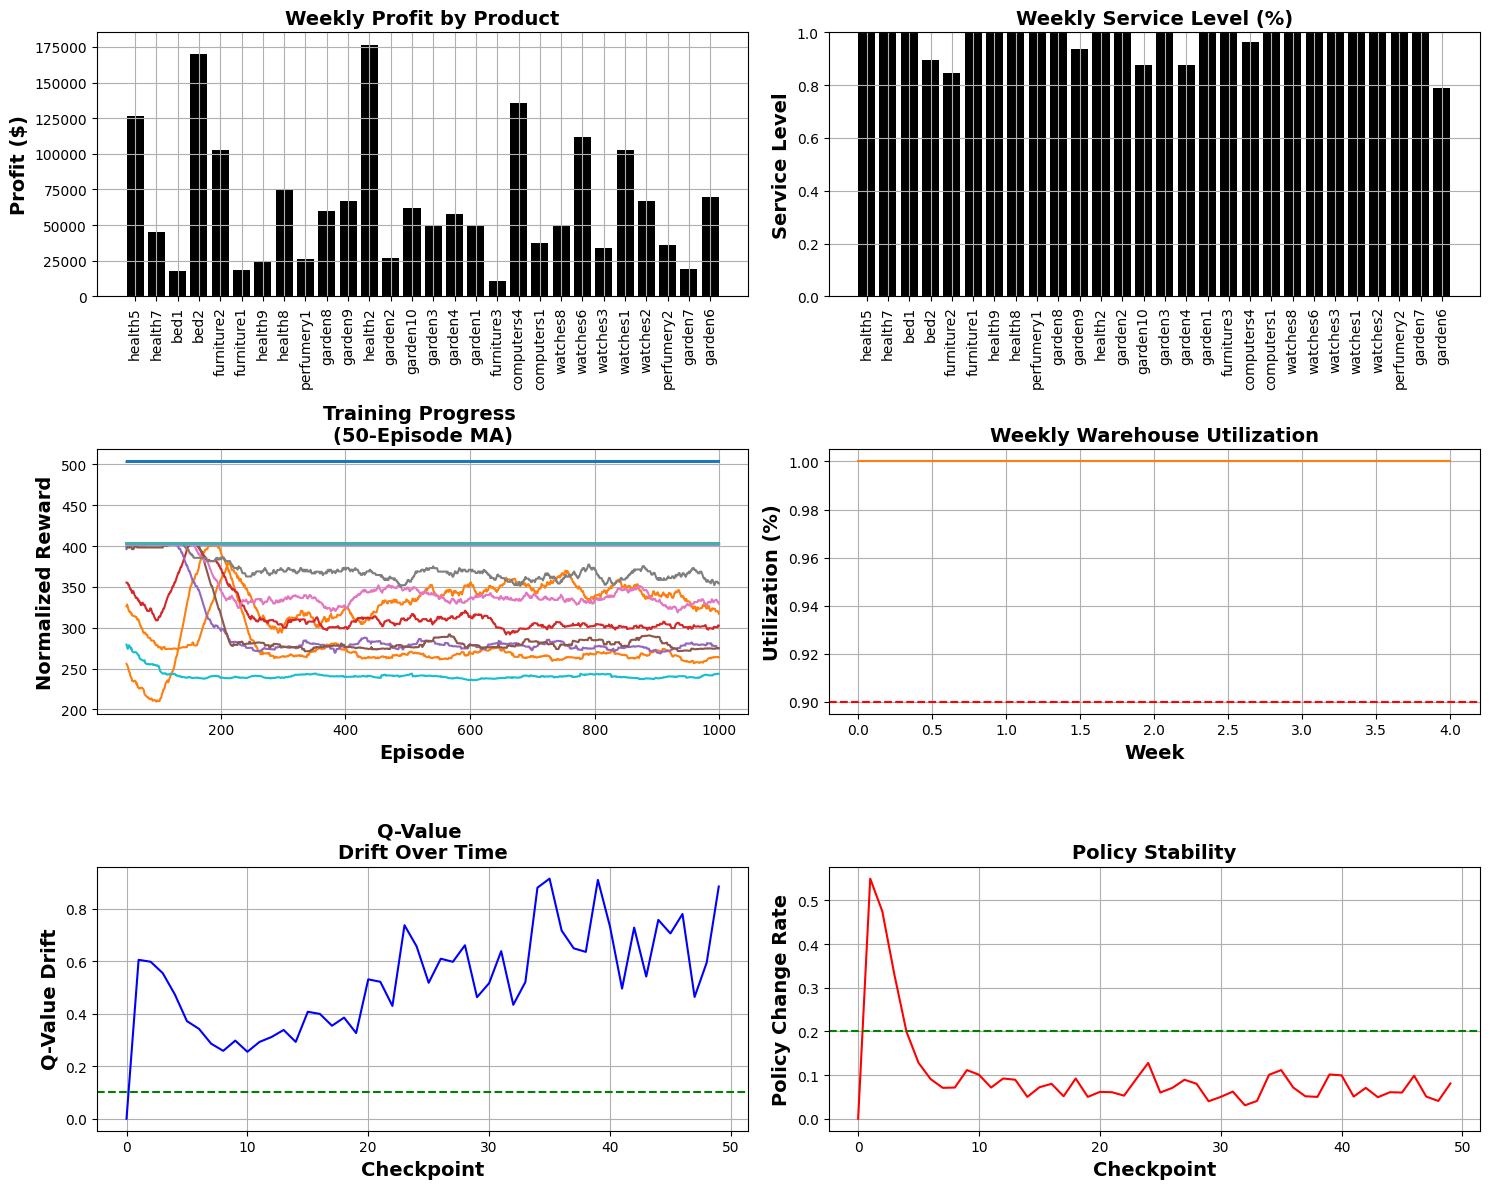

Report saved to retail_optimization_report.pkl

Final Convergence Status: DIVERGING
Final Q-Value Drift: 0.8848


In [ ]:
def prepare_weekly_data(df: pd.DataFrame, min_weeks: int = 4,
                        date_col: str = 'month_year') -> Dict[str, Tuple[List[int], List[float], float]]:
    try:
        df['date'] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.dropna(subset=['date'])

        df['year_week'] = df['date'].dt.to_period('W').astype(str)

        weekly_demand = (
            df.groupby(['product_id', 'year_week'], observed=True)['qty']
            .sum()
            .reset_index()
            .sort_values(['product_id', 'year_week']))

        product_counts = weekly_demand['product_id'].value_counts()
        valid_products = product_counts[product_counts >= min_weeks].index.tolist()

        if not valid_products:
            raise ValueError(f"No products with ≥ {min_weeks} weeks of data")

        products_data = {}
        for product_id in valid_products:
            product_demand = weekly_demand[weekly_demand['product_id'] == product_id]
            demand_series = (
                product_demand.sort_values('year_week')['qty']
                .tolist())

            price_df = (
                df[df['product_id'] == product_id]
                .groupby('year_week', observed=True)[['unit_price', 'qty']]
                .apply(lambda x: np.average(x['unit_price'], weights=x['qty']))
                .reset_index(name='weighted_price')
                .sort_values('year_week'))
            price_series = price_df['weighted_price'].tolist()

            product_data = df[df['product_id'] == product_id]
            valid_transactions = product_data[product_data['qty'] > 0]

            if len(valid_transactions) == 0:
                continue

            try:
                ref_price = np.average(
                    valid_transactions['unit_price'],
                    weights=valid_transactions['qty'])
            except:
                ref_price = valid_transactions['unit_price'].median()

            min_length = min(len(demand_series), len(price_series))
            if min_length < min_weeks:
                continue

            products_data[product_id] = (
                demand_series[:min_length],
                price_series[:min_length],
                ref_price)

        print(f"Prepared data for {len(products_data)} products (min {min_weeks} weeks)")
        return products_data

    except Exception as e:
        print(f"Data preparation failed: {str(e)}")
        return {}

class OptimizedSingleProductEnv:
    def __init__(self, demand_series: List[int], ref_price: float,
                 init_inventory: int = 500,
                 lead_time: int = 1,
                 elasticity: float = -0.8,
                 holding_rate: float = 0.015,
                 stockout_penalty: float = 5.0,
                 order_cost: float = 0.5,
                 safety_stock: int = 10,
                 service_weight: float = 100.0):

        self.service_weight = service_weight
        self.original_demand = [max(1, int(d)) for d in demand_series]
        self.ref_price = max(0.1, float(ref_price))
        self.weeks = len(self.original_demand)
        self.init_inventory = max(0, int(init_inventory))
        self.lead_time = min(max(1, int(lead_time)), self.weeks-1)
        self.elasticity = max(-5.0, min(0.0, float(elasticity)))
        self.holding_rate = max(0.0, float(holding_rate))
        self.stockout_penalty = max(0.0, float(stockout_penalty))
        self.order_cost = max(0.0, float(order_cost))
        self.safety_stock = max(0, int(safety_stock))
        self._calculate_demand_variability()
        self.reset()

    def _calculate_demand_variability(self):
        try:
            if self.weeks > self.lead_time:
                lt_demands = [sum(self.original_demand[i:i+self.lead_time])
                              for i in range(len(self.original_demand)-self.lead_time+1)]
                self.std_demand_lead_time = np.std(lt_demands) if len(lt_demands) > 1 else 3.0
            else:
                self.std_demand_lead_time = np.std(self.original_demand) if len(self.original_demand) > 1 else 3.0
        except:
            self.std_demand_lead_time = 3.0

    def reset(self):
        self.current_week = 0
        self.inventory = self.init_inventory
        self.total_profit = 0
        self.total_demand = 0
        self.total_sales = 0
        self.weekly_stats = []
        return self._get_state()

    def _get_state(self):
        return {
            'inventory': self.inventory,
            'current_week': self.current_week,
            'demand': self.original_demand[self.current_week] if self.current_week < self.weeks else 0,
            'avg_demand': np.mean(self.original_demand[:self.current_week+1]) if self.current_week > 0 else 0}

    def step(self, price: float, order_qty: int = 0) -> float:
        if self.current_week >= self.weeks:
            return 0.0

        try:
            base_demand = self.original_demand[self.current_week]
            price_factor = (max(0.1, price) / self.ref_price) ** self.elasticity
            noise = np.random.normal(0, 0.1 * base_demand)
            demand = max(1, int(base_demand * price_factor + noise))

            self.inventory += order_qty
            available = max(self.inventory - self.safety_stock, 0)
            sales_qty = min(available, demand)

            revenue = sales_qty * price
            holding_cost = self.inventory * self.holding_rate
            stockout_cost = max(demand - sales_qty, 0) * self.stockout_penalty
            order_cost = order_qty * self.order_cost
            profit = revenue - holding_cost - stockout_cost - order_cost
            service_level = sales_qty / demand if demand > 0 else 0.0

            scaled_reward = np.tanh(profit / 100.0) + self.service_weight * service_level

            prev_inventory = self.inventory
            self.inventory -= sales_qty
            self.total_profit += profit
            self.total_demand += demand
            self.total_sales += sales_qty

            self.weekly_stats.append({
                'week': self.current_week,
                'price': price,
                'order_qty': order_qty,
                'inventory': self.inventory,
                'demand': demand,
                'sales': sales_qty,
                'profit': profit,
                'service_level': service_level,
                'inventory_change': self.inventory - prev_inventory})

            self.current_week += 1
            return scaled_reward

        except Exception as e:
            print(f"Error in step: {str(e)}")
            return 0.0

    def service_level(self) -> float:
        if self.total_demand > 0:
            return self.total_sales / self.total_demand
        else:
            return 0.0

class MultiProductRetailEnv:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]],
                 warehouse_capacity: int = 4412,
                 shared_transport_cost: float = 0.2):
        self.products = {}
        self.warehouse_capacity = warehouse_capacity
        self.shared_transport_cost = shared_transport_cost
        self.current_week = 0
        self.shared_shipment_count = 0
        self.shared_costs = 0
        self.total_orders_this_week = defaultdict(int)
        self.weekly_warehouse_utilization = []
        self.metrics = {
            'shared_costs_total': 0,
            'over_utilization_penalties': 0,
            'cumulative_rewards': defaultdict(float)}

        for product_id, (demand_series, price_series, ref_price) in products_data.items():
            try:
                self.products[product_id] = {
                    'env': OptimizedSingleProductEnv(demand_series, ref_price),
                    'pending_orders': [],
                    'inventory': 0,
                    'space_required': max(1, int(ref_price/15))}
            except Exception as e:
                print(f"Error initializing product {product_id}: {str(e)}")
                continue

        if not self.products:
            raise ValueError("No valid products initialized")
        self.reset()

    def reset(self):
        self.current_week = 0
        self.shared_costs = 0
        self.shared_shipment_count = 0
        self.total_orders_this_week = defaultdict(int)
        self.weekly_warehouse_utilization = []
        self.metrics = {
            'shared_costs_total': 0,
            'over_utilization_penalties': 0,
            'cumulative_rewards': defaultdict(float)}

        for product_id, data in self.products.items():
            data['env'].reset()
            data['inventory'] = data['env'].init_inventory
            data['pending_orders'] = []
        return self.get_global_state()

    def get_global_state(self):
        return {
            'current_week': self.current_week,
            'warehouse_utilization': self.get_warehouse_utilization(),
            'total_orders': sum(self.total_orders_this_week.values()),
            'shared_costs': self.shared_costs}

    def get_warehouse_utilization(self):
        try:
            total_used = sum(data['inventory'] * data['space_required'] for data in self.products.values())
            return min(1.0, total_used / self.warehouse_capacity)
        except:
            return 0.0

    def step(self, actions: Dict[str, Tuple[float, int]]):
        max_weeks = max(len(data['env'].original_demand) for data in self.products.values())
        if self.current_week >= max_weeks:
            return self.get_global_state(), {}, True, {}

        individual_rewards = {}
        self.total_orders_this_week.clear()

        for product_id, (price, order_qty) in actions.items():
            if product_id not in self.products:
                continue
            if order_qty is None:
                max_order = 0
            else:
                product_data = self.products[product_id]
                max_order = self._get_max_order(product_id, order_qty)
            self.total_orders_this_week[product_id] = max_order
            if max_order > 0:
                arrival_week = self.current_week + product_data['env'].lead_time
                product_data['pending_orders'].append((arrival_week, max_order))

        for product_id, (price, order_qty) in actions.items():
            if product_id not in self.products:
                continue
            product_data = self.products[product_id]
            env = product_data['env']
            actual_order_qty = self.total_orders_this_week.get(product_id, 0)
            profit = env.step(price, actual_order_qty)
            product_data['inventory'] = env.inventory
            shared_cost_reduction = self.shared_transport_cost * len([pid for pid in actions if self.total_orders_this_week.get(pid, 0) > 0])
            individual_rewards[product_id] = profit + shared_cost_reduction

        active_orders = sum(1 for qty in self.total_orders_this_week.values() if qty > 0)
        if active_orders > 1:
            self.shared_shipment_count += 1
            self.shared_costs += self.shared_transport_cost * (active_orders - 1)
            self.metrics['shared_costs_total'] += self.shared_transport_cost * (active_orders - 1)

        self._process_order_arrivals()
        utilization = self.get_warehouse_utilization()
        self.weekly_warehouse_utilization.append(utilization)

        if utilization > 0.85:
            penalty = 50 * (utilization - 0.85)
            self.metrics['over_utilization_penalties'] += penalty
            penalty_per_product = penalty / len(individual_rewards) if individual_rewards else 0
            for product_id in individual_rewards:
                individual_rewards[product_id] -= penalty_per_product

        self.current_week += 1
        done = self.current_week >= max_weeks
        return self.get_global_state(), individual_rewards, done, {}

    def _get_max_order(self, product_id: str, requested_qty: int) -> int:
        if product_id not in self.products:
            return 0
        product_data = self.products[product_id]
        space_per_unit = product_data['space_required']
        used_space = 0
        for pid, data in self.products.items():
            current_inventory_space = data['inventory'] * data['space_required']
            pending_space = sum(qty * data['space_required'] for week, qty in data['pending_orders'] if week > self.current_week)
            used_space += current_inventory_space + pending_space
        available_space = max(0, self.warehouse_capacity - used_space)
        max_possible = available_space // space_per_unit
        return min(requested_qty, max_possible)

    def _process_order_arrivals(self):
        for product_id, product_data in self.products.items():
            arrived_qty = sum(qty for week, qty in product_data['pending_orders'] if week == self.current_week)
            product_data['inventory'] += arrived_qty
            product_data['pending_orders'] = [
                (week, qty) for week, qty in product_data['pending_orders']
                if week > self.current_week]

    def summarize(self):
        summary = {
            'total_weeks': self.current_week,
            'avg_utilization': np.mean(self.weekly_warehouse_utilization) if self.weekly_warehouse_utilization else 0,
            'shared_shipments': self.shared_shipment_count,
            'shared_costs_total': self.metrics['shared_costs_total'],
            'over_utilization_penalties': self.metrics['over_utilization_penalties'],
            'cumulative_rewards': dict(self.metrics['cumulative_rewards']),
            'product_service_levels': {pid: round(data['env'].service_level(), 3)
                                       for pid, data in self.products.items()}}
        return summary

class OptimizedProductAgent(nn.Module):
    def __init__(self,
                 input_size: int = 5,
                 hidden_size: int = 64,
                 price_bins: int = 10,
                 order_bins: int = 11,
                 lr: float = 0.0001):
        super().__init__()

        self.price_bins_count = price_bins
        self.order_bins_count = order_bins
        self.action_size = price_bins * order_bins

        self.price_bins = np.linspace(0.6, 1.4, self.price_bins_count)
        self.order_bins = np.linspace(0, 50, self.order_bins_count)

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size))

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.8)
        self.memory = []
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = 256
        self.target_update_freq = 10
        self.steps = 0
        self.target_net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size))
        self._update_target_net()

    def _update_target_net(self):
        self.target_net.load_state_dict(self.net.state_dict())

    def forward(self, x):
        return self.net(x)

    def get_action(self, state: Dict) -> Tuple[float, int]:
        if random.random() < self.epsilon:
            price_idx = random.randint(0, len(self.price_bins)-1)
            order_idx = random.randint(0, len(self.order_bins)-1)
            return self.price_bins[price_idx], self.order_bins[order_idx]

        state_tensor = torch.FloatTensor([
            state['inventory'],
            state['demand'],
            state['avg_demand'],
            state['global']['warehouse_utilization'],
            state['global']['current_week'] / 52])

        with torch.no_grad():
            q_values = self(state_tensor)
            q_values_2d = q_values.view(self.price_bins_count, self.order_bins_count)
            max_idx = torch.argmax(q_values_2d)
            price_idx = max_idx // self.order_bins_count
            order_idx = max_idx % self.order_bins_count

        return self.price_bins[price_idx], self.order_bins[order_idx]

    def act(self, state: List) -> Tuple[float, int]:
        if random.random() < self.epsilon:
            return random.uniform(0.6, 1.4), random.randint(0, 50)

        state_tensor = torch.FloatTensor(state)
        with torch.no_grad():
            q_values = self(state_tensor.unsqueeze(0))
            action_idx = torch.argmax(q_values).item()
            price_idx = action_idx // self.order_bins_count
            order_idx = action_idx % self.order_bins_count
            price_factor = self.price_bins[price_idx]
            order_qty = self.order_bins[order_idx]
        return price_factor, int(order_qty)

    def remember(self, state, action, reward, next_state, done=False):
        if isinstance(state, dict):
            price, order = action
            price_idx = np.argmin(np.abs(self.price_bins - price))
            order_idx = np.argmin(np.abs(self.order_bins - order))
            action_idx = price_idx * self.order_bins_count + order_idx
            state_tensor = [
                state['inventory'],
                state['demand'],
                state['avg_demand'],
                state['global']['warehouse_utilization'],
                state['global']['current_week'] / 52]
            next_state_tensor = [
                next_state['inventory'],
                next_state['current_week'],
                next_state['demand'],
                next_state['avg_demand'],
                next_state['global']['warehouse_utilization'],
                next_state['global']['current_week'] / 52] if next_state is not None else [0,0,0,0,0,0]
        else:
            price_factor, order_qty = action
            price_idx = np.argmin(np.abs(self.price_bins - price_factor))
            order_idx = np.argmin(np.abs(self.order_bins - order_qty))
            action_idx = price_idx * self.order_bins_count + order_idx
            state_tensor = state
            next_state_tensor = next_state if next_state is not None else [0,0,0,0]

        state_tensor_t = torch.FloatTensor(state_tensor)
        with torch.no_grad():
            current_q = self(state_tensor_t.unsqueeze(0))[0, action_idx].item()
            next_state_tensor_t = torch.FloatTensor(next_state_tensor)
            next_q = self.target_net(next_state_tensor_t.unsqueeze(0)).max().item()
            td_error = abs(reward + self.gamma * next_q - current_q)

        priority = td_error + 1e-5
        self.memory.append((state_tensor, action_idx, reward, next_state_tensor, priority))

    def replay(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        if len(self.memory) < batch_size:
            return

        priorities = np.array([mem[4] for mem in self.memory])
        probabilities = priorities / priorities.sum()
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)
        batch = [self.memory[i] for i in indices]

        states, action_indices, rewards, next_states, _ = zip(*batch)

        state_tensors = torch.FloatTensor(states)
        next_state_tensors = torch.FloatTensor(next_states)
        action_tensors = torch.LongTensor(action_indices).unsqueeze(1)
        reward_tensors = torch.FloatTensor(rewards)

        current_q = self(state_tensors).gather(1, action_tensors)

        with torch.no_grad():
            next_q = self.target_net(next_state_tensors).max(1)[0]
            target_q = reward_tensors + self.gamma * next_q

        loss = nn.SmoothL1Loss()(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)

        self.optimizer.step()
        self.scheduler.step()

        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self._update_target_net()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def validate(self):
        """Simple validation to check for divergence"""
        if len(self.memory) < 50:
            return 0.0

        recent_losses = []
        for i in range(-50, -1):
            state, action, reward, next_state, _ = self.memory[i]
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                current_q = self(state_tensor)[0, action].item()
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
                next_q = self.target_net(next_state_tensor).max().item()
                target_q = reward + self.gamma * next_q
                loss = abs(current_q - target_q)
                recent_losses.append(loss)

        return np.mean(recent_losses)

class OptimizedMultiAgentCoordinator:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]]):
        if not products_data:
            raise ValueError("No products data provided")

        self.env = MultiProductRetailEnv(products_data)
        self.agents = {}
        self.rewards_history = defaultdict(list)
        self.metrics = {'total_episode_rewards': []}
        self.convergence_metrics = []

        for product_id, (demand_series, price_series, ref_price) in products_data.items():
            self.agents[product_id] = OptimizedProductAgent(
                input_size=4,
                price_bins=10,
                order_bins=11,
                lr=0.0001)

    def train(self, episodes: int = 1000, eval_every: int = 50, batch_size=32):
        max_weeks = max([len(data['env'].original_demand) for data in self.env.products.values()])

        for ep in range(episodes):
            self.env.reset()
            episode_rewards = defaultdict(float)
            done = False

            for week in range(max_weeks):
                actions = {}
                for pid, agent in self.agents.items():
                    if self.env.products[pid]['env'].current_week < self.env.products[pid]['env'].weeks:
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        agent_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        price_factor, order_qty = agent.act(agent_state)
                        actual_price = price_factor * self.env.products[pid]['env'].ref_price
                        actions[pid] = (actual_price, order_qty)
                    else:
                        actions[pid] = (None, None)

                global_state, individual_rewards, done, _ = self.env.step(actions)

                for pid, reward in individual_rewards.items():
                    if pid in actions and actions[pid][0] is not None:
                        episode_rewards[pid] += reward
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        current_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        next_agent_state_data = self.env.products[pid]['env']._get_state()
                        next_state = [
                            next_agent_state_data['inventory'],
                            next_agent_state_data['current_week'],
                            next_agent_state_data['demand'],
                            next_agent_state_data['avg_demand']]
                        self.agents[pid].remember(
                            current_state,
                            (price_factor, order_qty),
                            reward,
                            next_state)
                        self.agents[pid].decay_epsilon()

                if done:
                    break

            for pid, agent in self.agents.items():
                validation_loss = agent.validate()
                if validation_loss < 1000:
                    agent.replay(batch_size)
                else:
                    print(f"Warning: Agent {pid} validation loss too high ({validation_loss:.2f}), skipping replay")

            total_episode_reward = sum(episode_rewards.values())
            self.metrics['total_episode_rewards'].append(total_episode_reward)

            for pid, reward in episode_rewards.items():
                self.rewards_history[pid].append(reward)
            if ep % 20 == 0:
                convergence_metrics = self.calculate_convergence_metrics()
                self.convergence_metrics.append(convergence_metrics)
                print(f"Episode {ep+1}/{episodes} | Total Reward: {total_episode_reward:.2f} | Q-Drift: {convergence_metrics['q_value_drift']:.4f}")

            if (ep+1) % eval_every == 0:
                print(f"Episode {ep+1}/{episodes} | Total Reward: {total_episode_reward:.2f}")

        return self.rewards_history, self.env

    def calculate_convergence_metrics(self):
        metrics = {}

        # Policy Change Rate
        policy_changes = []
        for pid, agent in self.agents.items():
            if hasattr(agent, 'memory') and len(agent.memory) > 100:
                recent_actions = [mem[1] for mem in agent.memory[-100:]]
                pcr = len(set(recent_actions)) / len(recent_actions)
                policy_changes.append(pcr)
        metrics['policy_change_rate'] = np.mean(policy_changes) if policy_changes else 0

        # Q-Value Drift
        q_drifts = []
        for pid, agent in self.agents.items():
            if hasattr(agent, 'memory') and len(agent.memory) > 50:
                recent_q_changes = []
                for i in range(len(agent.memory)-50, len(agent.memory)-1):
                    state, action, reward, next_state, _ = agent.memory[i]
                    state_tensor = torch.FloatTensor(state)
                    with torch.no_grad():
                        current_q = agent(state_tensor.unsqueeze(0))[0, action].item()
                        next_q = agent.target_net(torch.FloatTensor(next_state).unsqueeze(0)).max().item()
                    q_drift = abs(current_q - next_q)
                    recent_q_changes.append(q_drift)
                q_drifts.append(np.mean(recent_q_changes))
        metrics['q_value_drift'] = np.mean(q_drifts) if q_drifts else 0

        # Average Episode Reward
        episode_rewards = []
        for pid, rewards in self.rewards_history.items():
            if rewards:
                episode_rewards.append(np.mean(rewards[-20:]))
        metrics['avg_episode_reward'] = np.mean(episode_rewards) if episode_rewards else 0

        # Return Variance
        return_variances = []
        window_size = 50
        for pid, rewards in self.rewards_history.items():
            if len(rewards) > window_size:
                rolling_variance = pd.Series(rewards).rolling(window=window_size).var().dropna()
                return_variances.extend(rolling_variance.tolist())
        metrics['return_variance'] = np.mean(return_variances) if return_variances else 0

        # Exploration Rate
        exploration_rates = []
        for pid, agent in self.agents.items():
            exploration_rates.append(agent.epsilon)
        metrics['exploration_rate'] = np.mean(exploration_rates)

        # Convergence Status
        if metrics['q_value_drift'] < 0.1 and metrics['policy_change_rate'] < 0.2:
            metrics['convergence_status'] = "CONVERGED"
        elif metrics['q_value_drift'] < 0.3 and metrics['policy_change_rate'] < 0.4:
            metrics['convergence_status'] = "STABILIZING"
        else:
            metrics['convergence_status'] = "DIVERGING"

        return metrics

    def evaluate(self, num_episodes: int = 10):
        results = {}
        for pid in self.agents.keys():
            results[pid] = {
                'total_profit': 0,
                'total_demand': 0,
                'total_sales': 0,
                'weekly_stats': []}
        max_weeks = max([len(data['env'].original_demand) for data in self.env.products.values()])

        for _ in range(num_episodes):
            self.env.reset()
            for week in range(max_weeks):
                actions = {}
                for pid, agent in self.agents.items():
                    if self.env.products[pid]['env'].current_week < self.env.products[pid]['env'].weeks:
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        agent_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        price_factor, order_qty = agent.act(agent_state)
                        actual_price = price_factor * self.env.products[pid]['env'].ref_price
                        actions[pid] = (actual_price, order_qty)
                    else:
                        actions[pid] = (None, None)

                global_state, individual_rewards, done, _ = self.env.step(actions)

                for pid in self.agents.keys():
                    if pid in self.env.products:
                        env = self.env.products[pid]['env']
                        results[pid]['total_profit'] += env.total_profit
                        results[pid]['total_demand'] += env.total_demand
                        results[pid]['total_sales'] += env.total_sales
                        latest_weekly_stat = next(
                            (item for item in reversed(env.weekly_stats) if item['week'] == env.current_week - 1),
                            None)
                        if latest_weekly_stat:
                             results[pid]['weekly_stats'].append(latest_weekly_stat)
                if done:
                    break

        for pid in results.keys():
            results[pid]['total_profit'] /= num_episodes
            results[pid]['total_demand'] /= num_episodes
            results[pid]['total_sales'] /= num_episodes
            results[pid]['service_level'] = results[pid]['total_sales'] / results[pid]['total_demand'] if results[pid]['total_demand'] > 0 else 0

        return results

def generate_performance_report(results, env):
    inventory_metrics = {}
    for pid, stats in results.items():
        inventory_levels = [w['inventory'] for w in stats['weekly_stats']]
        avg_inventory = np.mean(inventory_levels)
        inventory_turnover = stats['total_sales'] / avg_inventory if avg_inventory > 0 else 0
        stockout_weeks = sum(1 for w in stats['weekly_stats'] if w.get('service_level', 1) < 0.5)
        avg_service = np.mean([w.get('service_level', 0) for w in stats['weekly_stats']])

        inventory_metrics[pid] = {
            'avg_inventory': avg_inventory,
            'inventory_turnover': inventory_turnover,
            'stockout_weeks': stockout_weeks,
            'max_inventory': max(inventory_levels) if inventory_levels else 0,
            'min_inventory': min(inventory_levels) if inventory_levels else 0,
            'avg_service': avg_service,
            'avg_demand': np.mean([w.get('demand', 0) for w in stats['weekly_stats']])}

    total_profit = sum(stats['total_profit'] for stats in results.values())
    profit_share = {pid: stats['total_profit'] / total_profit for pid, stats in results.items()}

    report = {
        'summary_metrics': {
            'total_profit': total_profit,
            'avg_service_level': np.mean([metrics['avg_service'] for metrics in inventory_metrics.values()]),
            'warehouse_stats': {
                'peak_utilization': max(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'avg_utilization': np.mean(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'overcapacity_weeks': sum(u > 0.85 for u in env.weekly_warehouse_utilization)},
            'shared_shipments': env.shared_shipment_count,
            'shared_costs_total': env.metrics['shared_costs_total'],
            'over_utilization_penalties': env.metrics['over_utilization_penalties'],
            'cumulative_rewards': dict(env.metrics['cumulative_rewards']),
            'product_service_levels': {pid: round(data['env'].service_level(), 3) for pid, data in env.products.items()},
            'profit_share': profit_share},
        'product_breakdown': {
            pid: {**stats, **inventory_metrics[pid]} for pid, stats in results.items()}}

    return report

def generate_executive_summary(report):
    sm = report['summary_metrics']
    products = report['product_breakdown']

    best_product = max(products.items(), key=lambda x: x[1]['avg_service'])
    worst_product = min(products.items(), key=lambda x: x[1]['avg_service'])
    most_profitable = max(products.items(), key=lambda x: x[1]['total_profit'])

    summary = f"""
    RETAIL OPTIMIZATION REPORT - WEEKLY OPERATIONS
    {'=' * 70}

    SYSTEM PERFORMANCE SUMMARY
    {'-' * 70}
    • Total Profit: ${sm['total_profit']:,.2f}
    • Average Service Level: {sm['avg_service_level']:.1%}
      (Target: 70%+, Current Gap: {(0.7 - sm['avg_service_level']):.1%})
    • Warehouse Utilization:
      - Peak: {sm['warehouse_stats']['peak_utilization']:.1%}
      - Average: {sm['warehouse_stats']['avg_utilization']:.1%}
      - Overcapacity Weeks: {sm['warehouse_stats']['overcapacity_weeks']}
    • Shared Shipments: {sm['shared_shipments']} (Cost Savings: ${sm['shared_costs_total']:,.2f})

    PRODUCT PERFORMANCE HIGHLIGHTS
    {'-' * 70}
    • Best Service: {best_product[0]} ({best_product[1]['avg_service']:.1%})
    • Worst Service: {worst_product[0]} ({worst_product[1]['avg_service']:.1%})
    • Most Profitable: {most_profitable[0]} (${most_profitable[1]['total_profit']:,.2f})

    KEY RECOMMENDATIONS
    {'-' * 70}"""

    if sm['warehouse_stats']['avg_utilization'] < 0.7:
        summary += "\n• Warehouse space underutilized - consider consolidation"
    elif sm['warehouse_stats']['avg_utilization'] > 0.9:
        summary += "\n• Warehouse frequently at capacity - optimize space allocation"

    if sm['avg_service_level'] < 0.9:
        summary += "\n• Service levels below target - review safety stocks"
    elif sm['avg_service_level'] > 0.98:
        summary += "\n• Service levels very high - opportunity to reduce inventory"

    low_service_products = [
        (pid, data) for pid, data in products.items()
        if data['avg_service'] < 0.5]
    if low_service_products:
        summary += "\n\nCRITICAL PRODUCTS NEEDING ATTENTION:"
        for pid, data in sorted(low_service_products, key=lambda x: x[1]['avg_service'])[:3]:
            summary += f"\n  - {pid}: Service Level {data['avg_service']:.1%} (Stockouts: {data['stockout_weeks']} weeks)"

    return summary

def create_visualizations(report, rewards_history, env, convergence_metrics=None):
    products = list(report['product_breakdown'].keys())
    colors = plt.cm.get_cmap('tab10', len(products)).colors

    if convergence_metrics:
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    ax1 = axes[0, 0] if convergence_metrics else axes[0]
    profits = [report['product_breakdown'][p]['total_profit'] for p in products]
    ax1.bar(products, profits, color='k')
    ax1.set_title('Weekly Profit by Product', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Profit ($)', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=90)
    ax1.tick_params(axis='y')
    ax1.grid()

    ax2 = axes[0, 1] if convergence_metrics else axes[1]
    service_levels = [report['product_breakdown'][p]['service_level'] for p in products]
    ax2.bar(products, service_levels, color='k')
    ax2.set_title('Weekly Service Level (%)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Service Level', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='y')
    ax2.set_ylim(0, 1.0)
    ax2.grid()
    ax2.tick_params(axis='x', rotation=90)

    ax3 = axes[1, 0] if convergence_metrics else axes[2]
    for i, (pid, rewards) in enumerate(rewards_history.items()):
        ax3.plot(pd.Series(rewards).rolling(50).mean(), label=pid, color=colors[i % len(colors)])
    ax3.set_title('Training Progress \n(50-Episode MA)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Episode', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Normalized Reward', fontsize=14, fontweight='bold')
    ax3.grid(True)

    ax4 = axes[1, 1] if convergence_metrics else axes[3]
    ax4.plot(env.weekly_warehouse_utilization, label='Utilization', color=colors[3])
    ax4.axhline(y=0.9, color='r', linestyle='--', label='Capacity Limit')
    ax4.set_title('Weekly Warehouse Utilization', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Week', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Utilization (%)', fontsize=14, fontweight='bold')
    # ax4.legend()
    ax4.grid()

    if convergence_metrics:
        ax5 = axes[2, 0]
        q_drifts = [m['q_value_drift'] for m in convergence_metrics]
        ax5.plot(q_drifts, 'b-', label='Q-Value Drift')
        ax5.axhline(y=0.1, color='g', linestyle='--', label='Stable Threshold')
        ax5.set_title('Q-Value \nDrift Over Time', fontsize=14, fontweight='bold')
        ax5.set_xlabel('Checkpoint', fontsize=14, fontweight='bold')
        ax5.set_ylabel('Q-Value Drift', fontsize=14, fontweight='bold')
        # ax5.legend()
        ax5.grid()

        ax6 = axes[2, 1]
        policy_changes = [m['policy_change_rate'] for m in convergence_metrics]
        ax6.plot(policy_changes, 'r-', label='Policy Change Rate')
        ax6.axhline(y=0.2, color='g', linestyle='--', label='Stable Threshold')
        ax6.set_title('Policy Stability', fontsize=14, fontweight='bold')
        ax6.set_xlabel('Checkpoint', fontsize=14, fontweight='bold')
        ax6.set_ylabel('Policy Change Rate', fontsize=14, fontweight='bold')
        # ax6.legend()
        ax6.grid()

    plt.tight_layout()
    plt.show()

def generate_full_report(env, rewards_history, convergence_metrics=None):
    results = coordinator.evaluate()
    performance_report = generate_performance_report(results, env)

    report_package = {
        'executive_summary': generate_executive_summary(performance_report),
        'performance_metrics': performance_report,
        'training_history': rewards_history,
        'convergence_metrics': convergence_metrics,
        'environment_state': env,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

    return report_package

def save_report(report, filename='retail_optimization_report.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(report, f)
    print(f"Report saved to {filename}")

def load_report(filename='retail_optimization_report.pkl'):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def export_key_tables(report):
    product_data = []
    for pid, stats in report['performance_metrics']['product_breakdown'].items():
        product_data.append({
            'product_id': pid,
            'total_profit': stats['total_profit'],
            'avg_service_level': stats['avg_service'],
            'avg_inventory': stats['avg_inventory'],
            'inventory_turns': stats['inventory_turnover'],
            'stockout_weeks': stats['stockout_weeks'],
            'profit_share': report['performance_metrics']['summary_metrics']['profit_share'][pid]})
    pd.DataFrame(product_data).to_csv('product_performance.csv', index=False)

if __name__ == "__main__":
    products_data = prepare_weekly_data(df)
    print(f"\nFound {len(products_data)} products with sufficient weekly data")

    coordinator = OptimizedMultiAgentCoordinator(products_data)
    rewards_history, final_env = coordinator.train(episodes=1000)

    full_report = generate_full_report(final_env, rewards_history, coordinator.convergence_metrics)
    print("\n" + "=" * 80)
    print(full_report['executive_summary'])
    print("=" * 80)

    create_visualizations(
        full_report['performance_metrics'],
        full_report['training_history'],
        final_env,
        full_report['convergence_metrics'])

    save_report(full_report)
    export_key_tables(full_report)

    if coordinator.convergence_metrics:
        final_status = coordinator.convergence_metrics[-1]['convergence_status']
        q_drift = coordinator.convergence_metrics[-1]['q_value_drift']
        print(f"\nFinal Convergence Status: {final_status}")
        print(f"Final Q-Value Drift: {q_drift:.4f}")

- Decrease the Learning Rate: This is the first and most important knob to turn. Try reducing it by an order of magnitude (e.g., from 1e-3 to 1e-4 or 5e-5).

- Increase the Replay Buffer Size: Make the buffer much larger. This ensures the agent always trains on a more stationary and diverse distribution of data, preventing catastrophic forgetting.

- Increase Target Network Update Frequency: If you are using a hard update (e.g., every C steps), try reducing C to update the target network more often. Alternatively, implement a soft update ( Polyak averaging: θ_target = τ * θ_online + (1-τ) * θ_target ) with a very small τ (e.g., 0.005).

- Implement Gradient Clipping: Clip the gradients to a maximum norm (e.g., 1.0 or 10.0) to prevent a single batch from causing catastrophic divergence.

- Plot the Loss: Alongside the Q-values, plot the Mean Squared Error (MSE) loss. You will almost certainly see it spike dramatically during the divergent phases, confirming the analysis.



## **Refined Convergence criteria**

Prepared data for 28 products (min 4 weeks)

Found 28 products with sufficient weekly data
Episode 1/1000 ✓ | Reward: 11448.05 | Q-Drift: 0.0000 | Status: CONVERGED
Episode 21/1000 ↗ | Reward: 11192.33 | Q-Drift: 0.5587 | Status: LEARNING
Episode 41/1000 ↗ | Reward: 11050.81 | Q-Drift: 0.4945 | Status: LEARNING
Episode 50/1000 | Total Reward: 11196.65
Episode 61/1000 ↗ | Reward: 11065.76 | Q-Drift: 0.4158 | Status: LEARNING
Episode 81/1000 ↗ | Reward: 11113.36 | Q-Drift: 0.3299 | Status: LEARNING
Episode 100/1000 | Total Reward: 11054.63
Episode 101/1000 ↗ | Reward: 11153.21 | Q-Drift: 0.2832 | Status: LEARNING
Episode 121/1000 ↗ | Reward: 11170.13 | Q-Drift: 0.2380 | Status: LEARNING
Episode 141/1000 ↗ | Reward: 11215.62 | Q-Drift: 0.2055 | Status: LEARNING
Episode 150/1000 | Total Reward: 11334.55
Episode 161/1000 ↗ | Reward: 11307.82 | Q-Drift: 0.1967 | Status: LEARNING
Episode 181/1000 ↗ | Reward: 11250.35 | Q-Drift: 0.1951 | Status: LEARNING
Episode 200/1000 | Total Reward: 11072.

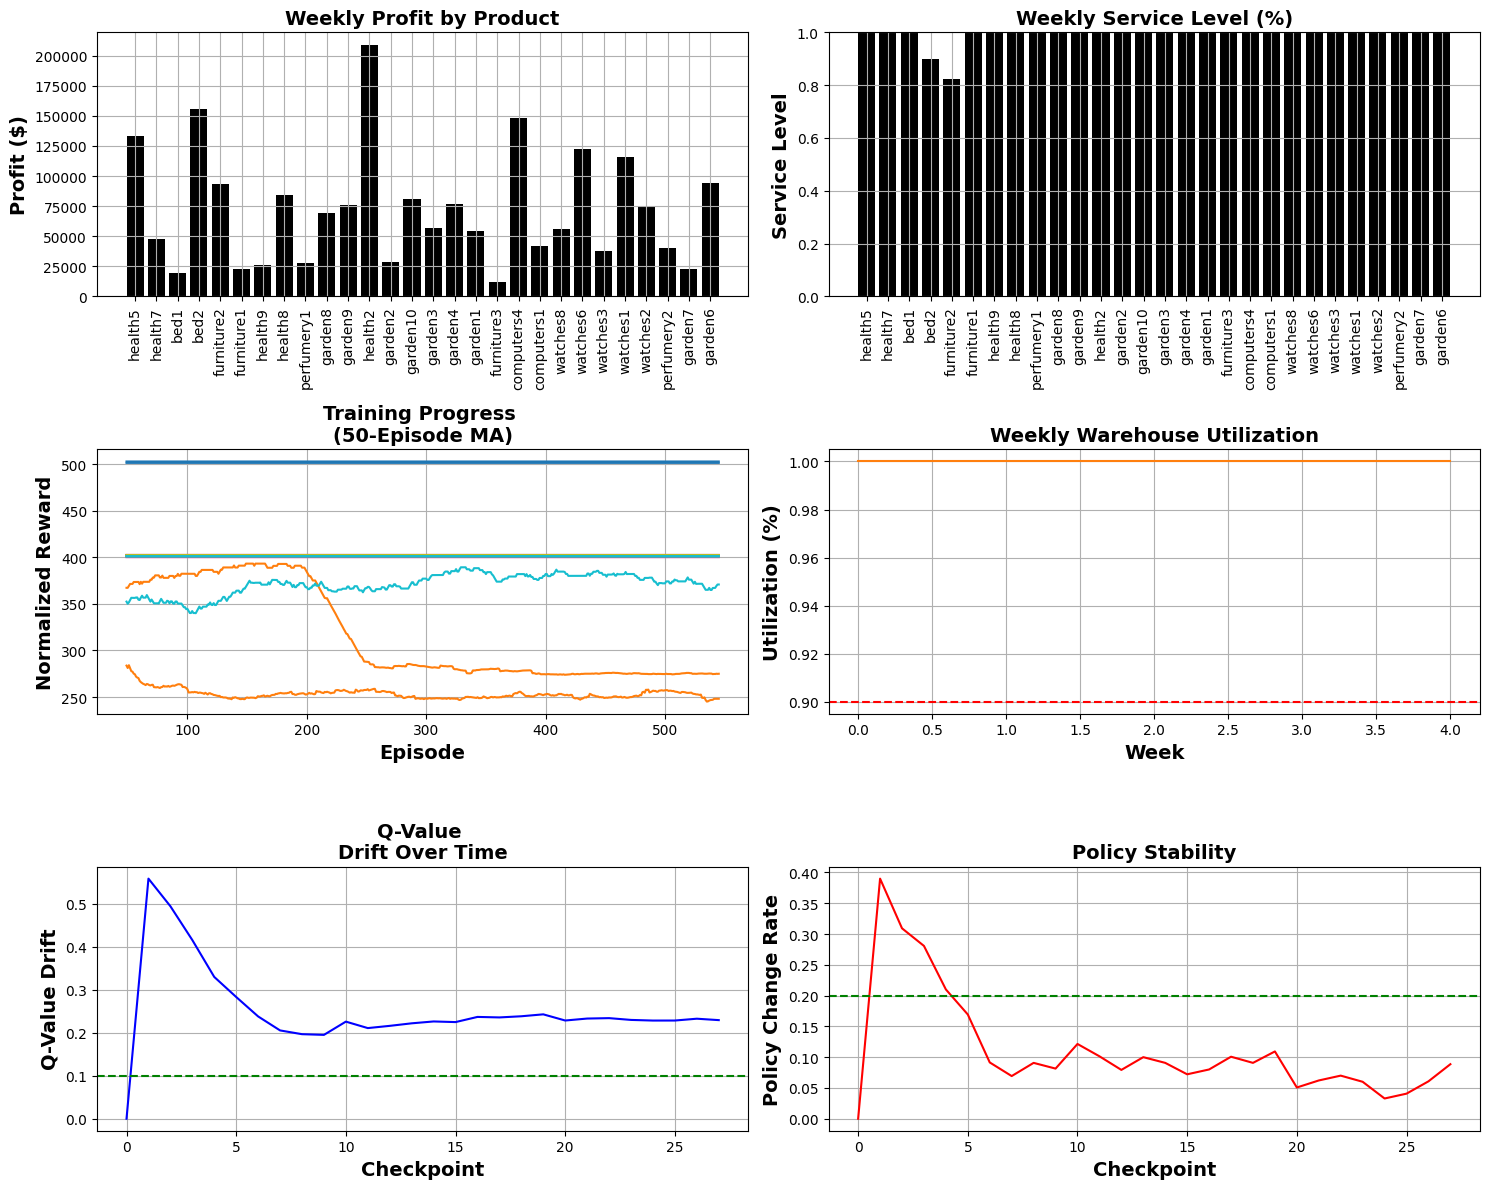

Report saved to retail_optimization_report.pkl

Final Convergence Status: LEARNING
Final Q-Value Drift: 0.2294


In [ ]:
def prepare_weekly_data(df: pd.DataFrame, min_weeks: int = 4,
                        date_col: str = 'month_year') -> Dict[str, Tuple[List[int], List[float], float]]:
    try:
        df['date'] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.dropna(subset=['date'])

        df['year_week'] = df['date'].dt.to_period('W').astype(str)

        weekly_demand = (
            df.groupby(['product_id', 'year_week'], observed=True)['qty']
            .sum()
            .reset_index()
            .sort_values(['product_id', 'year_week']))

        product_counts = weekly_demand['product_id'].value_counts()
        valid_products = product_counts[product_counts >= min_weeks].index.tolist()

        if not valid_products:
            raise ValueError(f"No products with ≥ {min_weeks} weeks of data")

        products_data = {}
        for product_id in valid_products:
            product_demand = weekly_demand[weekly_demand['product_id'] == product_id]
            demand_series = (
                product_demand.sort_values('year_week')['qty']
                .tolist())

            price_df = (
                df[df['product_id'] == product_id]
                .groupby('year_week', observed=True)[['unit_price', 'qty']]
                .apply(lambda x: np.average(x['unit_price'], weights=x['qty']))
                .reset_index(name='weighted_price')
                .sort_values('year_week'))
            price_series = price_df['weighted_price'].tolist()

            product_data = df[df['product_id'] == product_id]
            valid_transactions = product_data[product_data['qty'] > 0]

            if len(valid_transactions) == 0:
                continue

            try:
                ref_price = np.average(
                    valid_transactions['unit_price'],
                    weights=valid_transactions['qty'])
            except:
                ref_price = valid_transactions['unit_price'].median()

            min_length = min(len(demand_series), len(price_series))
            if min_length < min_weeks:
                continue

            products_data[product_id] = (
                demand_series[:min_length],
                price_series[:min_length],
                ref_price)

        print(f"Prepared data for {len(products_data)} products (min {min_weeks} weeks)")
        return products_data

    except Exception as e:
        print(f"Data preparation failed: {str(e)}")
        return {}

class OptimizedSingleProductEnv:
    def __init__(self, demand_series: List[int], ref_price: float,
                 init_inventory: int = 500,
                 lead_time: int = 1,
                 elasticity: float = -0.8,
                 holding_rate: float = 0.015,
                 stockout_penalty: float = 5.0,
                 order_cost: float = 0.5,
                 safety_stock: int = 10,
                 service_weight: float = 100.0):

        self.service_weight = service_weight
        self.original_demand = [max(1, int(d)) for d in demand_series]
        self.ref_price = max(0.1, float(ref_price))
        self.weeks = len(self.original_demand)
        self.init_inventory = max(0, int(init_inventory))
        self.lead_time = min(max(1, int(lead_time)), self.weeks-1)
        self.elasticity = max(-5.0, min(0.0, float(elasticity)))
        self.holding_rate = max(0.0, float(holding_rate))
        self.stockout_penalty = max(0.0, float(stockout_penalty))
        self.order_cost = max(0.0, float(order_cost))
        self.safety_stock = max(0, int(safety_stock))
        self.avg_demand = np.mean(self.original_demand) if self.original_demand else 1
        self._calculate_demand_variability()
        self.reset()

    def _calculate_demand_variability(self):
        try:
            if self.weeks > self.lead_time:
                lt_demands = [sum(self.original_demand[i:i+self.lead_time])
                              for i in range(len(self.original_demand)-self.lead_time+1)]
                self.std_demand_lead_time = np.std(lt_demands) if len(lt_demands) > 1 else 3.0
            else:
                self.std_demand_lead_time = np.std(self.original_demand) if len(self.original_demand) > 1 else 3.0
        except:
            self.std_demand_lead_time = 3.0

    def reset(self):
        self.current_week = 0
        self.inventory = self.init_inventory
        self.total_profit = 0
        self.total_demand = 0
        self.total_sales = 0
        self.weekly_stats = []
        return self._get_state()

    def _get_state(self):
        return {
            'inventory': self.inventory,
            'current_week': self.current_week,
            'demand': self.original_demand[self.current_week] if self.current_week < self.weeks else 0,
            'avg_demand': np.mean(self.original_demand[:self.current_week+1]) if self.current_week > 0 else 0}

    def step(self, price: float, order_qty: int = 0) -> float:
        if self.current_week >= self.weeks:
            return 0.0

        try:
            min_price = self.ref_price * 0.7
            price = max(min_price, price)

            base_demand = self.original_demand[self.current_week]
            price_factor = (max(0.1, price) / self.ref_price) ** self.elasticity
            noise = np.random.normal(0, 0.1 * base_demand)
            demand = max(1, int(base_demand * price_factor + noise))

            self.inventory += order_qty
            available = max(self.inventory - self.safety_stock, 0)
            sales_qty = min(available, demand)

            revenue = sales_qty * price
            holding_cost = self.inventory * self.holding_rate
            stockout_cost = max(demand - sales_qty, 0) * self.stockout_penalty
            order_cost = order_qty * self.order_cost
            profit = revenue - holding_cost - stockout_cost - order_cost
            service_level = sales_qty / demand if demand > 0 else 0.0

            profit_penalty = np.tanh(profit / 1000.0)
            service_bonus = self.service_weight * service_level * (1.0 if profit > 0 else 0.2)
            inventory_penalty = -0.01 * (self.inventory / max(1, self.avg_demand))

            scaled_reward = profit_penalty + service_bonus + inventory_penalty

            prev_inventory = self.inventory
            self.inventory -= sales_qty
            self.total_profit += profit
            self.total_demand += demand
            self.total_sales += sales_qty

            self.weekly_stats.append({
                'week': self.current_week,
                'price': price,
                'order_qty': order_qty,
                'inventory': self.inventory,
                'demand': demand,
                'sales': sales_qty,
                'profit': profit,
                'service_level': service_level,
                'inventory_change': self.inventory - prev_inventory})

            self.current_week += 1
            return scaled_reward

        except Exception as e:
            print(f"Error in step: {str(e)}")
            return 0.0

    def service_level(self) -> float:
        if self.total_demand > 0:
            return self.total_sales / self.total_demand
        else:
            return 0.0

class MultiProductRetailEnv:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]],
                 warehouse_capacity: int = 4412,
                 shared_transport_cost: float = 0.2):
        self.products = {}
        self.warehouse_capacity = warehouse_capacity
        self.shared_transport_cost = shared_transport_cost
        self.current_week = 0
        self.shared_shipment_count = 0
        self.shared_costs = 0
        self.total_orders_this_week = defaultdict(int)
        self.weekly_warehouse_utilization = []
        self.metrics = {
            'shared_costs_total': 0,
            'over_utilization_penalties': 0,
            'cumulative_rewards': defaultdict(float)}

        for product_id, (demand_series, price_series, ref_price) in products_data.items():
            try:
                self.products[product_id] = {
                    'env': OptimizedSingleProductEnv(demand_series, ref_price),
                    'pending_orders': [],
                    'inventory': 0,
                    'space_required': max(1, int(ref_price/15))}
            except Exception as e:
                print(f"Error initializing product {product_id}: {str(e)}")
                continue

        if not self.products:
            raise ValueError("No valid products initialized")
        self.reset()

    def reset(self):
        self.current_week = 0
        self.shared_costs = 0
        self.shared_shipment_count = 0
        self.total_orders_this_week = defaultdict(int)
        self.weekly_warehouse_utilization = []
        self.metrics = {
            'shared_costs_total': 0,
            'over_utilization_penalties': 0,
            'cumulative_rewards': defaultdict(float)}

        for product_id, data in self.products.items():
            data['env'].reset()
            data['inventory'] = data['env'].init_inventory
            data['pending_orders'] = []
        return self.get_global_state()

    def get_global_state(self):
        return {
            'current_week': self.current_week,
            'warehouse_utilization': self.get_warehouse_utilization(),
            'total_orders': sum(self.total_orders_this_week.values()),
            'shared_costs': self.shared_costs}

    def get_warehouse_utilization(self):
        try:
            total_used = sum(data['inventory'] * data['space_required'] for data in self.products.values())
            return min(1.0, total_used / self.warehouse_capacity)
        except:
            return 0.0

    def step(self, actions: Dict[str, Tuple[float, int]]):
        max_weeks = max(len(data['env'].original_demand) for data in self.products.values())
        if self.current_week >= max_weeks:
            return self.get_global_state(), {}, True, {}

        individual_rewards = {}
        self.total_orders_this_week.clear()

        for product_id, (price, order_qty) in actions.items():
            if product_id not in self.products:
                continue
            if order_qty is None:
                max_order = 0
            else:
                product_data = self.products[product_id]
                max_order = self._get_max_order(product_id, order_qty)
            self.total_orders_this_week[product_id] = max_order
            if max_order > 0:
                arrival_week = self.current_week + product_data['env'].lead_time
                product_data['pending_orders'].append((arrival_week, max_order))

        for product_id, (price, order_qty) in actions.items():
            if product_id not in self.products:
                continue
            product_data = self.products[product_id]
            env = product_data['env']
            actual_order_qty = self.total_orders_this_week.get(product_id, 0)
            profit = env.step(price, actual_order_qty)
            product_data['inventory'] = env.inventory
            shared_cost_reduction = self.shared_transport_cost * len([pid for pid in actions if self.total_orders_this_week.get(pid, 0) > 0])
            individual_rewards[product_id] = profit + shared_cost_reduction

        active_orders = sum(1 for qty in self.total_orders_this_week.values() if qty > 0)
        if active_orders > 1:
            self.shared_shipment_count += 1
            self.shared_costs += self.shared_transport_cost * (active_orders - 1)
            self.metrics['shared_costs_total'] += self.shared_transport_cost * (active_orders - 1)

        self._process_order_arrivals()
        utilization = self.get_warehouse_utilization()
        self.weekly_warehouse_utilization.append(utilization)

        if utilization > 0.85:
            penalty = 50 * (utilization - 0.85)
            self.metrics['over_utilization_penalties'] += penalty
            penalty_per_product = penalty / len(individual_rewards) if individual_rewards else 0
            for product_id in individual_rewards:
                individual_rewards[product_id] -= penalty_per_product

        self.current_week += 1
        done = self.current_week >= max_weeks
        return self.get_global_state(), individual_rewards, done, {}

    def _get_max_order(self, product_id: str, requested_qty: int) -> int:
        if product_id not in self.products:
            return 0
        product_data = self.products[product_id]
        space_per_unit = product_data['space_required']
        used_space = 0
        for pid, data in self.products.items():
            current_inventory_space = data['inventory'] * data['space_required']
            pending_space = sum(qty * data['space_required'] for week, qty in data['pending_orders'] if week > self.current_week)
            used_space += current_inventory_space + pending_space
        available_space = max(0, self.warehouse_capacity - used_space)
        max_possible = available_space / space_per_unit
        return min(requested_qty, int(max_possible))

    def _process_order_arrivals(self):
        for product_id, product_data in self.products.items():
            arrived_qty = sum(qty for week, qty in product_data['pending_orders'] if week == self.current_week)
            product_data['inventory'] += arrived_qty
            product_data['pending_orders'] = [
                (week, qty) for week, qty in product_data['pending_orders']
                if week > self.current_week]

    def summarize(self):
        summary = {
            'total_weeks': self.current_week,
            'avg_utilization': np.mean(self.weekly_warehouse_utilization) if self.weekly_warehouse_utilization else 0,
            'shared_shipments': self.shared_shipment_count,
            'shared_costs_total': self.metrics['shared_costs_total'],
            'over_utilization_penalties': self.metrics['over_utilization_penalties'],
            'cumulative_rewards': dict(self.metrics['cumulative_rewards']),
            'product_service_levels': {pid: round(data['env'].service_level(), 3)
                                       for pid, data in self.products.items()}}
        return summary

class OptimizedProductAgent(nn.Module):
    def __init__(self,
                 input_size: int = 5,
                 hidden_size: int = 64,
                 price_bins: int = 10,
                 order_bins: int = 11,
                 lr: float = 0.00005):
        super().__init__()

        self.price_bins_count = price_bins
        self.order_bins_count = order_bins
        self.action_size = price_bins * order_bins

        self.price_bins = np.linspace(0.8, 1.5, self.price_bins_count)
        self.order_bins = np.linspace(0, 50, self.order_bins_count)

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size))

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=50)
        self.memory = []
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = 256
        self.target_update_freq = 5
        self.tau = 0.01
        self.steps = 0
        self.best_avg_reward = -float('inf')
        self.patience_counter = 0
        self.max_patience = 100

        self.target_net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size))
        self._update_target_net()

    def _update_target_net(self):
        for target_param, param in zip(self.target_net.parameters(), self.net.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

    def forward(self, x):
        return self.net(x)

    def get_action(self, state: Dict) -> Tuple[float, int]:
        if random.random() < self.epsilon:
            price_idx = random.randint(0, len(self.price_bins)-1)
            order_idx = random.randint(0, len(self.order_bins)-1)
            return self.price_bins[price_idx], self.order_bins[order_idx]

        state_tensor = torch.FloatTensor([
            state['inventory'],
            state['demand'],
            state['avg_demand'],
            state['global']['warehouse_utilization'],
            state['global']['current_week'] / 52])

        with torch.no_grad():
            q_values = self(state_tensor)
            q_values_2d = q_values.view(self.price_bins_count, self.order_bins_count)
            max_idx = torch.argmax(q_values_2d)
            price_idx = max_idx // self.order_bins_count
            order_idx = max_idx % self.order_bins_count

        return self.price_bins[price_idx], self.order_bins[order_idx]

    def act(self, state: List) -> Tuple[float, int]:
        state = np.array(state)
        state_normalized = (state - state.mean()) / (state.std() + 1e-8)

        if random.random() < self.epsilon:
            return random.uniform(0.8, 1.2), random.randint(0, 30)  # Tighter exploration

        state_tensor = torch.FloatTensor(state_normalized)
        with torch.no_grad():
            q_values = self(state_tensor.unsqueeze(0))
            action_idx = torch.argmax(q_values).item()
            price_idx = action_idx // self.order_bins_count
            order_idx = action_idx % self.order_bins_count
            price_factor = self.price_bins[price_idx]
            order_qty = self.order_bins[order_idx]
        return price_factor, int(order_qty)

    def remember(self, state, action, reward, next_state, done=False):
        if isinstance(state, dict):
            price, order = action
            price_idx = np.argmin(np.abs(self.price_bins - price))
            order_idx = np.argmin(np.abs(self.order_bins - order))
            action_idx = price_idx * self.order_bins_count + order_idx
            state_tensor = [
                state['inventory'],
                state['demand'],
                state['avg_demand'],
                state['global']['warehouse_utilization'],
                state['global']['current_week'] / 52]
            next_state_tensor = [
                next_state['inventory'],
                next_state['current_week'],
                next_state['demand'],
                next_state['avg_demand'],
                next_state['global']['warehouse_utilization'],
                next_state['global']['current_week'] / 52] if next_state is not None else [0,0,0,0,0,0]
        else:
            price_factor, order_qty = action
            price_idx = np.argmin(np.abs(self.price_bins - price_factor))
            order_idx = np.argmin(np.abs(self.order_bins - order_qty))
            action_idx = price_idx * self.order_bins_count + order_idx
            state_tensor = state
            next_state_tensor = next_state if next_state is not None else [0,0,0,0]

        state_tensor_t = torch.FloatTensor(state_tensor)
        with torch.no_grad():
            current_q = self(state_tensor_t.unsqueeze(0))[0, action_idx].item()
            next_state_tensor_t = torch.FloatTensor(next_state_tensor)
            next_q = self.target_net(next_state_tensor_t.unsqueeze(0)).max().item()
            td_error = abs(reward + self.gamma * next_q - current_q)

        priority = td_error + 1e-5
        self.memory.append((state_tensor, action_idx, reward, next_state_tensor, priority))

    def replay(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        if len(self.memory) < batch_size:
            return False

        priorities = np.array([mem[4] for mem in self.memory])
        probabilities = priorities / priorities.sum()
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)

        is_weights = (len(self.memory) * probabilities[indices]) ** -0.4
        is_weights = torch.FloatTensor(is_weights / is_weights.max())

        batch = [self.memory[i] for i in indices]
        states, action_indices, rewards, next_states, _ = zip(*batch)

        state_tensors = torch.FloatTensor(states)
        next_state_tensors = torch.FloatTensor(next_states)
        action_tensors = torch.LongTensor(action_indices).unsqueeze(1)
        reward_tensors = torch.FloatTensor(rewards)

        current_q = self(state_tensors).gather(1, action_tensors)

        with torch.no_grad():
            next_q = self.target_net(next_state_tensors).max(1)[0]
            target_q = reward_tensors + self.gamma * next_q

        loss = (is_weights * nn.SmoothL1Loss(reduction='none')(current_q.squeeze(), target_q)).mean()

        self.optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=0.5)

        self.optimizer.step()

        recent_rewards = [mem[2] for mem in self.memory[-100:]] if len(self.memory) > 100 else [0]
        avg_reward = np.mean(recent_rewards)
        self.scheduler.step(avg_reward)

        if len(recent_rewards) >= 50:
            if avg_reward > self.best_avg_reward:
                self.best_avg_reward = avg_reward
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.max_patience:
                return True

        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self._update_target_net()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        return False

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def validate(self):
        if len(self.memory) < 50:
            return 0.0

        recent_losses = []
        for i in range(-50, -1):
            state, action, reward, next_state, _ = self.memory[i]
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                current_q = self(state_tensor)[0, action].item()
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
                next_q = self.target_net(next_state_tensor).max().item()
                target_q = reward + self.gamma * next_q
                loss = abs(current_q - target_q)
                recent_losses.append(loss)

        return np.mean(recent_losses)

class OptimizedMultiAgentCoordinator:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]]):
        if not products_data:
            raise ValueError("No products data provided")

        self.env = MultiProductRetailEnv(products_data)
        self.agents = {}
        self.rewards_history = defaultdict(list)
        self.metrics = {'total_episode_rewards': []}
        self.convergence_metrics = []

        for product_id, (demand_series, price_series, ref_price) in products_data.items():
            self.agents[product_id] = OptimizedProductAgent(
                input_size=4,
                price_bins=10,
                order_bins=11,
                lr=0.00005)

    def train(self, episodes: int = 1000, eval_every: int = 50, batch_size=32):
        max_weeks = max([len(data['env'].original_demand) for data in self.env.products.values()])
        converged = False

        for ep in range(episodes):
            if converged:
                print(f"Training converged at episode {ep}")
                break

            self.env.reset()
            episode_rewards = defaultdict(float)
            done = False

            for week in range(max_weeks):
                actions = {}
                for pid, agent in self.agents.items():
                    if self.env.products[pid]['env'].current_week < self.env.products[pid]['env'].weeks:
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        agent_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        price_factor, order_qty = agent.act(agent_state)
                        actual_price = price_factor * self.env.products[pid]['env'].ref_price
                        actions[pid] = (actual_price, order_qty)
                    else:
                        actions[pid] = (None, None)

                global_state, individual_rewards, done, _ = self.env.step(actions)

                for pid, reward in individual_rewards.items():
                    if pid in actions and actions[pid][0] is not None:
                        episode_rewards[pid] += reward
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        current_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        next_agent_state_data = self.env.products[pid]['env']._get_state()
                        next_state = [
                            next_agent_state_data['inventory'],
                            next_agent_state_data['current_week'],
                            next_agent_state_data['demand'],
                            next_agent_state_data['avg_demand']]
                        self.agents[pid].remember(
                            current_state,
                            (price_factor, order_qty),
                            reward,
                            next_state)
                        self.agents[pid].decay_epsilon()

                if done:
                    break

            convergence_signals = []
            for pid, agent in self.agents.items():
                validation_loss = agent.validate()
                if validation_loss < 1000:
                    should_stop = agent.replay(batch_size)
                    convergence_signals.append(should_stop)
                else:
                    print(f"Warning: Agent {pid} validation loss too high ({validation_loss:.2f}), skipping replay")
                    convergence_signals.append(False)

            if all(convergence_signals):
                converged = True

            total_episode_reward = sum(episode_rewards.values())
            self.metrics['total_episode_rewards'].append(total_episode_reward)

            for pid, reward in episode_rewards.items():
                self.rewards_history[pid].append(reward)

            if ep % 20 == 0:
                convergence_metrics = self.calculate_convergence_metrics()
                self.convergence_metrics.append(convergence_metrics)
                status_symbol = "✓" if convergence_metrics['convergence_status'] == "CONVERGED" else "➡" if convergence_metrics['convergence_status'] == "STABILIZING" else "↗"
                print(f"Episode {ep+1}/{episodes} {status_symbol} | Reward: {total_episode_reward:.2f} | Q-Drift: {convergence_metrics['q_value_drift']:.4f} | Status: {convergence_metrics['convergence_status']}")

            if (ep+1) % eval_every == 0:
                print(f"Episode {ep+1}/{episodes} | Total Reward: {total_episode_reward:.2f}")

        return self.rewards_history, self.env

    def calculate_convergence_metrics(self):
        metrics = {}

        policy_changes = []
        for pid, agent in self.agents.items():
            if hasattr(agent, 'memory') and len(agent.memory) > 100:
                recent_actions = [mem[1] for mem in agent.memory[-100:]]
                pcr = len(set(recent_actions)) / len(recent_actions)
                policy_changes.append(pcr)
        metrics['policy_change_rate'] = np.mean(policy_changes) if policy_changes else 0

        q_drifts = []
        for pid, agent in self.agents.items():
            if hasattr(agent, 'memory') and len(agent.memory) > 50:
                recent_q_changes = []
                for i in range(len(agent.memory)-50, len(agent.memory)-1):
                    state, action, reward, next_state, _ = agent.memory[i]
                    state_tensor = torch.FloatTensor(state)
                    with torch.no_grad():
                        current_q = agent(state_tensor.unsqueeze(0))[0, action].item()
                        next_q = agent.target_net(torch.FloatTensor(next_state).unsqueeze(0)).max().item()
                    q_drift = abs(current_q - next_q)
                    recent_q_changes.append(q_drift)
                q_drifts.append(np.mean(recent_q_changes))
        metrics['q_value_drift'] = np.mean(q_drifts) if q_drifts else 0

        if q_drifts and len(q_drifts) > 10:
            metrics['q_value_stability'] = np.std(q_drifts[-10:])
        else:
            metrics['q_value_stability'] = 0

        metrics['policy_consistency'] = 1 - metrics['policy_change_rate']

        episode_rewards = []
        for pid, rewards in self.rewards_history.items():
            if rewards and len(rewards) > 20:
                episode_rewards.append(np.mean(rewards[-20:]))
        metrics['avg_episode_reward'] = np.mean(episode_rewards) if episode_rewards else 0

        return_variances = []
        window_size = 50
        for pid, rewards in self.rewards_history.items():
            if len(rewards) > window_size:
                rolling_variance = pd.Series(rewards).rolling(window=window_size).var().dropna()
                return_variances.extend(rolling_variance.tolist())
        metrics['return_variance'] = np.mean(return_variances) if return_variances else 0

        exploration_rates = []
        for pid, agent in self.agents.items():
            exploration_rates.append(agent.epsilon)
        metrics['exploration_rate'] = np.mean(exploration_rates)

        if (metrics['q_value_drift'] < 0.05 and
            metrics['policy_change_rate'] < 0.1 and
            metrics['q_value_stability'] < 0.02 and
            metrics['return_variance'] < 0.1):
            metrics['convergence_status'] = "CONVERGED"
        elif (metrics['q_value_drift'] < 0.1 and
              metrics['policy_change_rate'] < 0.2):
            metrics['convergence_status'] = "STABILIZING"
        else:
            metrics['convergence_status'] = "LEARNING"

        return metrics

    def evaluate(self, num_episodes: int = 10):
        results = {}
        for pid in self.agents.keys():
            results[pid] = {
                'total_profit': 0,
                'total_demand': 0,
                'total_sales': 0,
                'weekly_stats': []}
        max_weeks = max([len(data['env'].original_demand) for data in self.env.products.values()])

        for _ in range(num_episodes):
            self.env.reset()
            for week in range(max_weeks):
                actions = {}
                for pid, agent in self.agents.items():
                    if self.env.products[pid]['env'].current_week < self.env.products[pid]['env'].weeks:
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        agent_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        price_factor, order_qty = agent.act(agent_state)
                        actual_price = price_factor * self.env.products[pid]['env'].ref_price
                        actions[pid] = (actual_price, order_qty)
                    else:
                        actions[pid] = (None, None)

                global_state, individual_rewards, done, _ = self.env.step(actions)

                for pid in self.agents.keys():
                    if pid in self.env.products:
                        env = self.env.products[pid]['env']
                        results[pid]['total_profit'] += env.total_profit
                        results[pid]['total_demand'] += env.total_demand
                        results[pid]['total_sales'] += env.total_sales
                        latest_weekly_stat = next(
                            (item for item in reversed(env.weekly_stats) if item['week'] == env.current_week - 1),
                            None)
                        if latest_weekly_stat:
                             results[pid]['weekly_stats'].append(latest_weekly_stat)
                if done:
                    break

        for pid in results.keys():
            results[pid]['total_profit'] /= num_episodes
            results[pid]['total_demand'] /= num_episodes
            results[pid]['total_sales'] /= num_episodes
            results[pid]['service_level'] = results[pid]['total_sales'] / results[pid]['total_demand'] if results[pid]['total_demand'] > 0 else 0

        return results

def generate_performance_report(results, env):
    inventory_metrics = {}
    for pid, stats in results.items():
        inventory_levels = [w['inventory'] for w in stats['weekly_stats']]
        avg_inventory = np.mean(inventory_levels)
        inventory_turnover = stats['total_sales'] / avg_inventory if avg_inventory > 0 else 0
        stockout_weeks = sum(1 for w in stats['weekly_stats'] if w.get('service_level', 1) < 0.5)
        avg_service = np.mean([w.get('service_level', 0) for w in stats['weekly_stats']])

        inventory_metrics[pid] = {
            'avg_inventory': avg_inventory,
            'inventory_turnover': inventory_turnover,
            'stockout_weeks': stockout_weeks,
            'max_inventory': max(inventory_levels) if inventory_levels else 0,
            'min_inventory': min(inventory_levels) if inventory_levels else 0,
            'avg_service': avg_service,
            'avg_demand': np.mean([w.get('demand', 0) for w in stats['weekly_stats']])}

    total_profit = sum(stats['total_profit'] for stats in results.values())
    profit_share = {pid: stats['total_profit'] / total_profit for pid, stats in results.items()}

    report = {
        'summary_metrics': {
            'total_profit': total_profit,
            'avg_service_level': np.mean([metrics['avg_service'] for metrics in inventory_metrics.values()]),
            'warehouse_stats': {
                'peak_utilization': max(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'avg_utilization': np.mean(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'overcapacity_weeks': sum(u > 0.85 for u in env.weekly_warehouse_utilization)},
            'shared_shipments': env.shared_shipment_count,
            'shared_costs_total': env.metrics['shared_costs_total'],
            'over_utilization_penalties': env.metrics['over_utilization_penalties'],
            'cumulative_rewards': dict(env.metrics['cumulative_rewards']),
            'product_service_levels': {pid: round(data['env'].service_level(), 3) for pid, data in env.products.items()},
            'profit_share': profit_share},
        'product_breakdown': {
            pid: {**stats, **inventory_metrics[pid]} for pid, stats in results.items()}}

    return report

def generate_executive_summary(report):
    sm = report['summary_metrics']
    products = report['product_breakdown']

    best_product = max(products.items(), key=lambda x: x[1]['avg_service'])
    worst_product = min(products.items(), key=lambda x: x[1]['avg_service'])
    most_profitable = max(products.items(), key=lambda x: x[1]['total_profit'])

    summary = f"""
    RETAIL OPTIMIZATION REPORT - WEEKLY OPERATIONS
    {'=' * 70}

    SYSTEM PERFORMANCE SUMMARY
    {'-' * 70}
    • Total Profit: ${sm['total_profit']:,.2f}
    • Average Service Level: {sm['avg_service_level']:.1%}
      (Target: 70%+, Current Gap: {(0.7 - sm['avg_service_level']):.1%})
    • Warehouse Utilization:
      - Peak: {sm['warehouse_stats']['peak_utilization']:.1%}
      - Average: {sm['warehouse_stats']['avg_utilization']:.1%}
      - Overcapacity Weeks: {sm['warehouse_stats']['overcapacity_weeks']}
    • Shared Shipments: {sm['shared_shipments']} (Cost Savings: ${sm['shared_costs_total']:,.2f})

    PRODUCT PERFORMANCE HIGHLIGHTS
    {'-' * 70}
    • Best Service: {best_product[0]} ({best_product[1]['avg_service']:.1%})
    • Worst Service: {worst_product[0]} ({worst_product[1]['avg_service']:.1%})
    • Most Profitable: {most_profitable[0]} (${most_profitable[1]['total_profit']:,.2f})

    KEY RECOMMENDATIONS
    {'-' * 70}"""

    if sm['warehouse_stats']['avg_utilization'] < 0.7:
        summary += "\n• Warehouse space underutilized - consider consolidation"
    elif sm['warehouse_stats']['avg_utilization'] > 0.9:
        summary += "\n• Warehouse frequently at capacity - optimize space allocation"

    if sm['avg_service_level'] < 0.9:
        summary += "\n• Service levels below target - review safety stocks"
    elif sm['avg_service_level'] > 0.98:
        summary += "\n• Service levels very high - opportunity to reduce inventory"

    low_service_products = [
        (pid, data) for pid, data in products.items()
        if data['avg_service'] < 0.5]
    if low_service_products:
        summary += "\n\nCRITICAL PRODUCTS NEEDING ATTENTION:"
        for pid, data in sorted(low_service_products, key=lambda x: x[1]['avg_service'])[:3]:
            summary += f"\n  - {pid}: Service Level {data['avg_service']:.1%} (Stockouts: {data['stockout_weeks']} weeks)"

    return summary

def create_visualizations(report, rewards_history, env, convergence_metrics=None):
    products = list(report['product_breakdown'].keys())
    colors = plt.cm.get_cmap('tab10', len(products)).colors

    if convergence_metrics:
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    ax1 = axes[0, 0] if convergence_metrics else axes[0]
    profits = [report['product_breakdown'][p]['total_profit'] for p in products]
    ax1.bar(products, profits, color='k')
    ax1.set_title('Weekly Profit by Product', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Profit ($)', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=90)
    ax1.tick_params(axis='y')
    ax1.grid()

    ax2 = axes[0, 1] if convergence_metrics else axes[1]
    service_levels = [report['product_breakdown'][p]['service_level'] for p in products]
    ax2.bar(products, service_levels, color='k')
    ax2.set_title('Weekly Service Level (%)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Service Level', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='y')
    ax2.set_ylim(0, 1.0)
    ax2.grid()
    ax2.tick_params(axis='x', rotation=90)

    ax3 = axes[1, 0] if convergence_metrics else axes[2]
    for i, (pid, rewards) in enumerate(rewards_history.items()):
        ax3.plot(pd.Series(rewards).rolling(50).mean(), label=pid, color=colors[i % len(colors)])
    ax3.set_title('Training Progress \n(50-Episode MA)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Episode', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Normalized Reward', fontsize=14, fontweight='bold')
    ax3.grid(True)

    ax4 = axes[1, 1] if convergence_metrics else axes[3]
    ax4.plot(env.weekly_warehouse_utilization, label='Utilization', color=colors[3])
    ax4.axhline(y=0.9, color='r', linestyle='--', label='Capacity Limit')
    ax4.set_title('Weekly Warehouse Utilization', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Week', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Utilization (%)', fontsize=14, fontweight='bold')
    # ax4.legend()
    ax4.grid()

    if convergence_metrics:
        ax5 = axes[2, 0]
        q_drifts = [m['q_value_drift'] for m in convergence_metrics]
        ax5.plot(q_drifts, 'b-', label='Q-Value Drift')
        ax5.axhline(y=0.1, color='g', linestyle='--', label='Stable Threshold')
        ax5.set_title('Q-Value \nDrift Over Time', fontsize=14, fontweight='bold')
        ax5.set_xlabel('Checkpoint', fontsize=14, fontweight='bold')
        ax5.set_ylabel('Q-Value Drift', fontsize=14, fontweight='bold')
        # ax5.legend()
        ax5.grid()

        ax6 = axes[2, 1]
        policy_changes = [m['policy_change_rate'] for m in convergence_metrics]
        ax6.plot(policy_changes, 'r-', label='Policy Change Rate')
        ax6.axhline(y=0.2, color='g', linestyle='--', label='Stable Threshold')
        ax6.set_title('Policy Stability', fontsize=14, fontweight='bold')
        ax6.set_xlabel('Checkpoint', fontsize=14, fontweight='bold')
        ax6.set_ylabel('Policy Change Rate', fontsize=14, fontweight='bold')
        # ax6.legend()
        ax6.grid()

    plt.tight_layout()
    plt.show()

def generate_full_report(env, rewards_history, convergence_metrics=None):
    results = coordinator.evaluate()
    performance_report = generate_performance_report(results, env)

    report_package = {
        'executive_summary': generate_executive_summary(performance_report),
        'performance_metrics': performance_report,
        'training_history': rewards_history,
        'convergence_metrics': convergence_metrics,
        'environment_state': env,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

    return report_package

def save_report(report, filename='retail_optimization_report.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(report, f)
    print(f"Report saved to {filename}")

def load_report(filename='retail_optimization_report.pkl'):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def export_key_tables(report):
    product_data = []
    for pid, stats in report['performance_metrics']['product_breakdown'].items():
        product_data.append({
            'product_id': pid,
            'total_profit': stats['total_profit'],
            'avg_service_level': stats['avg_service'],
            'avg_inventory': stats['avg_inventory'],
            'inventory_turns': stats['inventory_turnover'],
            'stockout_weeks': stats['stockout_weeks'],
            'profit_share': report['performance_metrics']['summary_metrics']['profit_share'][pid]})
    pd.DataFrame(product_data).to_csv('product_performance.csv', index=False)

if __name__ == "__main__":
    products_data = prepare_weekly_data(df)
    print(f"\nFound {len(products_data)} products with sufficient weekly data")

    coordinator = OptimizedMultiAgentCoordinator(products_data)
    rewards_history, final_env = coordinator.train(episodes=1000)

    full_report = generate_full_report(final_env, rewards_history, coordinator.convergence_metrics)
    print("\n" + "=" * 80)
    print(full_report['executive_summary'])
    print("=" * 80)

    create_visualizations(
        full_report['performance_metrics'],
        full_report['training_history'],
        final_env,
        full_report['convergence_metrics'])

    save_report(full_report)
    export_key_tables(full_report)

    if coordinator.convergence_metrics:
        final_status = coordinator.convergence_metrics[-1]['convergence_status']
        q_drift = coordinator.convergence_metrics[-1]['q_value_drift']
        print(f"\nFinal Convergence Status: {final_status}")
        print(f"Final Q-Value Drift: {q_drift:.4f}")

In [ ]:
class MultiProductRetailEnv:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]],
                 warehouse_capacity: int = 4412,
                 shared_transport_cost: float = 0.2):
        self.products = {}
        self.warehouse_capacity = warehouse_capacity
        self.shared_transport_cost = shared_transport_cost
        self.current_week = 0
        self.shared_shipment_count = 0
        self.shared_costs = 0
        self.total_orders_this_week = defaultdict(int)
        self.weekly_warehouse_utilization = []
        self.metrics = {
            'shared_costs_total': 0,
            'over_utilization_penalties': 0,
            'cumulative_rewards': defaultdict(float)}

        for product_id, (demand_series, price_series, ref_price) in products_data.items():
            try:
                self.products[product_id] = {
                    'env': OptimizedSingleProductEnv(demand_series, ref_price),
                    'pending_orders': [],
                    'inventory': 0,
                    'space_required': max(1, int(ref_price/15))}
            except Exception as e:
                print(f"Error initializing product {product_id}: {str(e)}")
                continue

        if not self.products:
            raise ValueError("No valid products initialized")
        self.reset()

    def reset(self):
        self.current_week = 0
        self.shared_costs = 0
        self.shared_shipment_count = 0
        self.total_orders_this_week = defaultdict(int)
        self.weekly_warehouse_utilization = []
        self.metrics = {
            'shared_costs_total': 0,
            'over_utilization_penalties': 0,
            'cumulative_rewards': defaultdict(float)}

        for product_id, data in self.products.items():
            data['env'].reset()
            data['inventory'] = data['env'].init_inventory
            data['pending_orders'] = []
        return self.get_global_state()

    def get_global_state(self):
        return {
            'current_week': self.current_week,
            'warehouse_utilization': self.get_warehouse_utilization(),
            'total_orders': sum(self.total_orders_this_week.values()),
            'shared_costs': self.shared_costs}

    def get_warehouse_utilization(self):
        try:
            total_used = sum(data['inventory'] * data['space_required'] for data in self.products.values())
            return min(1.0, total_used / self.warehouse_capacity)
        except:
            return 0.0

    def step(self, actions: Dict[str, Tuple[float, int]]):
        max_weeks = max(len(data['env'].original_demand) for data in self.products.values())
        if self.current_week >= max_weeks:
            return self.get_global_state(), {}, True, {}

        individual_rewards = {}
        self.total_orders_this_week.clear()

        for product_id, (price, order_qty) in actions.items():
            if product_id not in self.products:
                continue
            if order_qty is None:
                max_order = 0
            else:
                product_data = self.products[product_id]
                max_order = self._get_max_order(product_id, order_qty)
            self.total_orders_this_week[product_id] = max_order
            if max_order > 0:
                arrival_week = self.current_week + product_data['env'].lead_time
                product_data['pending_orders'].append((arrival_week, max_order))

        for product_id, (price, order_qty) in actions.items():
            if product_id not in self.products:
                continue
            product_data = self.products[product_id]
            env = product_data['env']
            actual_order_qty = self.total_orders_this_week.get(product_id, 0)
            profit = env.step(price, actual_order_qty)
            product_data['inventory'] = env.inventory
            shared_cost_reduction = self.shared_transport_cost * len([pid for pid in actions if self.total_orders_this_week.get(pid, 0) > 0])
            individual_rewards[product_id] = profit + shared_cost_reduction

        active_orders = sum(1 for qty in self.total_orders_this_week.values() if qty > 0)
        if active_orders > 1:
            self.shared_shipment_count += 1
            self.shared_costs += self.shared_transport_cost * (active_orders - 1)
            self.metrics['shared_costs_total'] += self.shared_transport_cost * (active_orders - 1)

        self._process_order_arrivals()
        utilization = self.get_warehouse_utilization()
        self.weekly_warehouse_utilization.append(utilization)

        if utilization > 0.85:
            penalty = 50 * (utilization - 0.85)
            self.metrics['over_utilization_penalties'] += penalty
            penalty_per_product = penalty / len(individual_rewards) if individual_rewards else 0
            for product_id in individual_rewards:
                individual_rewards[product_id] -= penalty_per_product

        self.current_week += 1
        done = self.current_week >= max_weeks
        return self.get_global_state(), individual_rewards, done, {}

    def _get_max_order(self, product_id: str, requested_qty: int) -> int:
        if product_id not in self.products:
            return 0
        product_data = self.products[product_id]
        space_per_unit = product_data['space_required']
        used_space = 0
        for pid, data in self.products.items():
            current_inventory_space = data['inventory'] * data['space_required']
            pending_space = sum(qty * data['space_required'] for week, qty in data['pending_orders'] if week > self.current_week)
            used_space += current_inventory_space + pending_space
        available_space = max(0, self.warehouse_capacity - used_space)
        max_possible = available_space / space_per_unit
        return min(requested_qty, int(max_possible))

    def _process_order_arrivals(self):
        for product_id, product_data in self.products.items():
            arrived_qty = sum(qty for week, qty in product_data['pending_orders'] if week == self.current_week)
            product_data['inventory'] += arrived_qty
            product_data['pending_orders'] = [
                (week, qty) for week, qty in product_data['pending_orders']
                if week > self.current_week]

    def summarize(self):
        summary = {
            'total_weeks': self.current_week,
            'avg_utilization': np.mean(self.weekly_warehouse_utilization) if self.weekly_warehouse_utilization else 0,
            'shared_shipments': self.shared_shipment_count,
            'shared_costs_total': self.metrics['shared_costs_total'],
            'over_utilization_penalties': self.metrics['over_utilization_penalties'],
            'cumulative_rewards': dict(self.metrics['cumulative_rewards']),
            'product_service_levels': {pid: round(data['env'].service_level(), 3)
                                       for pid, data in self.products.items()}}
        return summary

class OptimizedProductAgent(nn.Module):
    def __init__(self,
                 input_size: int = 5,
                 hidden_size: int = 64,
                 price_bins: int = 10,
                 order_bins: int = 11,
                 lr: float = 0.00005):
        super().__init__()

        self.price_bins_count = price_bins
        self.order_bins_count = order_bins
        self.action_size = price_bins * order_bins

        self.price_bins = np.linspace(0.8, 1.5, self.price_bins_count)
        self.order_bins = np.linspace(0, 50, self.order_bins_count)

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size))

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=50)
        self.memory = []
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = 256
        self.target_update_freq = 5
        self.tau = 0.01
        self.steps = 0
        self.best_avg_reward = -float('inf')
        self.patience_counter = 0
        self.max_patience = 100

        self.target_net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size))
        self._update_target_net()

    def _update_target_net(self):
        for target_param, param in zip(self.target_net.parameters(), self.net.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

    def forward(self, x):
        return self.net(x)

    def get_action(self, state: Dict) -> Tuple[float, int]:
        if random.random() < self.epsilon:
            price_idx = random.randint(0, len(self.price_bins)-1)
            order_idx = random.randint(0, len(self.order_bins)-1)
            return self.price_bins[price_idx], self.order_bins[order_idx]

        state_tensor = torch.FloatTensor([
            state['inventory'],
            state['demand'],
            state['avg_demand'],
            state['global']['warehouse_utilization'],
            state['global']['current_week'] / 52])

        with torch.no_grad():
            q_values = self(state_tensor)
            q_values_2d = q_values.view(self.price_bins_count, self.order_bins_count)
            max_idx = torch.argmax(q_values_2d)
            price_idx = max_idx // self.order_bins_count
            order_idx = max_idx % self.order_bins_count

        return self.price_bins[price_idx], self.order_bins[order_idx]

    def act(self, state: List) -> Tuple[float, int]:
        state = np.array(state)
        state_normalized = (state - state.mean()) / (state.std() + 1e-8)

        if random.random() < self.epsilon:
            return random.uniform(0.8, 1.2), random.randint(0, 30)  # Tighter exploration

        state_tensor = torch.FloatTensor(state_normalized)
        with torch.no_grad():
            q_values = self(state_tensor.unsqueeze(0))
            action_idx = torch.argmax(q_values).item()
            price_idx = action_idx // self.order_bins_count
            order_idx = action_idx % self.order_bins_count
            price_factor = self.price_bins[price_idx]
            order_qty = self.order_bins[order_idx]
        return price_factor, int(order_qty)

    def remember(self, state, action, reward, next_state, done=False):
        if isinstance(state, dict):
            price, order = action
            price_idx = np.argmin(np.abs(self.price_bins - price))
            order_idx = np.argmin(np.abs(self.order_bins - order))
            action_idx = price_idx * self.order_bins_count + order_idx
            state_tensor = [
                state['inventory'],
                state['demand'],
                state['avg_demand'],
                state['global']['warehouse_utilization'],
                state['global']['current_week'] / 52]
            next_state_tensor = [
                next_state['inventory'],
                next_state['current_week'],
                next_state['demand'],
                next_state['avg_demand'],
                next_state['global']['warehouse_utilization'],
                next_state['global']['current_week'] / 52] if next_state is not None else [0,0,0,0,0,0]
        else:
            price_factor, order_qty = action
            price_idx = np.argmin(np.abs(self.price_bins - price_factor))
            order_idx = np.argmin(np.abs(self.order_bins - order_qty))
            action_idx = price_idx * self.order_bins_count + order_idx
            state_tensor = state
            next_state_tensor = next_state if next_state is not None else [0,0,0,0]

        state_tensor_t = torch.FloatTensor(state_tensor)
        with torch.no_grad():
            current_q = self(state_tensor_t.unsqueeze(0))[0, action_idx].item()
            next_state_tensor_t = torch.FloatTensor(next_state_tensor)
            next_q = self.target_net(next_state_tensor_t.unsqueeze(0)).max().item()
            td_error = abs(reward + self.gamma * next_q - current_q)

        priority = td_error + 1e-5
        self.memory.append((state_tensor, action_idx, reward, next_state_tensor, priority))

    def replay(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        if len(self.memory) < batch_size:
            return False

        priorities = np.array([mem[4] for mem in self.memory])
        probabilities = priorities / priorities.sum()
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)

        is_weights = (len(self.memory) * probabilities[indices]) ** -0.4
        is_weights = torch.FloatTensor(is_weights / is_weights.max())

        batch = [self.memory[i] for i in indices]
        states, action_indices, rewards, next_states, _ = zip(*batch)

        state_tensors = torch.FloatTensor(states)
        next_state_tensors = torch.FloatTensor(next_states)
        action_tensors = torch.LongTensor(action_indices).unsqueeze(1)
        reward_tensors = torch.FloatTensor(rewards)

        current_q = self(state_tensors).gather(1, action_tensors)

        with torch.no_grad():
            next_q = self.target_net(next_state_tensors).max(1)[0]
            target_q = reward_tensors + self.gamma * next_q

        loss = (is_weights * nn.SmoothL1Loss(reduction='none')(current_q.squeeze(), target_q)).mean()

        self.optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=0.5)

        self.optimizer.step()

        recent_rewards = [mem[2] for mem in self.memory[-100:]] if len(self.memory) > 100 else [0]
        avg_reward = np.mean(recent_rewards)
        self.scheduler.step(avg_reward)

        if len(recent_rewards) >= 50:
            if avg_reward > self.best_avg_reward:
                self.best_avg_reward = avg_reward
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.max_patience:
                return True

        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self._update_target_net()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        return False

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def validate(self):
        if len(self.memory) < 50:
            return 0.0

        recent_losses = []
        for i in range(-50, -1):
            state, action, reward, next_state, _ = self.memory[i]
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                current_q = self(state_tensor)[0, action].item()
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
                next_q = self.target_net(next_state_tensor).max().item()
                target_q = reward + self.gamma * next_q
                loss = abs(current_q - target_q)
                recent_losses.append(loss)

        return np.mean(recent_losses)

class OptimizedMultiAgentCoordinator:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]]):
        if not products_data:
            raise ValueError("No products data provided")

        self.env = MultiProductRetailEnv(products_data)
        self.agents = {}
        self.rewards_history = defaultdict(list)
        self.metrics = {'total_episode_rewards': []}
        self.convergence_metrics = []

        for product_id, (demand_series, price_series, ref_price) in products_data.items():
            self.agents[product_id] = OptimizedProductAgent(
                input_size=4,
                price_bins=10,
                order_bins=11,
                lr=0.00005)

    def train(self, episodes: int = 1000, eval_every: int = 50, batch_size=32):
        max_weeks = max([len(data['env'].original_demand) for data in self.env.products.values()])
        converged = False

        for ep in range(episodes):
            if converged:
                print(f"Training converged at episode {ep}")
                break

            self.env.reset()
            episode_rewards = defaultdict(float)
            done = False

            for week in range(max_weeks):
                actions = {}
                for pid, agent in self.agents.items():
                    if self.env.products[pid]['env'].current_week < self.env.products[pid]['env'].weeks:
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        agent_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        price_factor, order_qty = agent.act(agent_state)
                        actual_price = price_factor * self.env.products[pid]['env'].ref_price
                        actions[pid] = (actual_price, order_qty)
                    else:
                        actions[pid] = (None, None)

                global_state, individual_rewards, done, _ = self.env.step(actions)

                for pid, reward in individual_rewards.items():
                    if pid in actions and actions[pid][0] is not None:
                        episode_rewards[pid] += reward
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        current_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        next_agent_state_data = self.env.products[pid]['env']._get_state()
                        next_state = [
                            next_agent_state_data['inventory'],
                            next_agent_state_data['current_week'],
                            next_agent_state_data['demand'],
                            next_agent_state_data['avg_demand']]
                        self.agents[pid].remember(
                            current_state,
                            (price_factor, order_qty),
                            reward,
                            next_state)
                        self.agents[pid].decay_epsilon()

                if done:
                    break

            convergence_signals = []
            for pid, agent in self.agents.items():
                validation_loss = agent.validate()
                if validation_loss < 1000:
                    should_stop = agent.replay(batch_size)
                    convergence_signals.append(should_stop)
                else:
                    print(f"Warning: Agent {pid} validation loss too high ({validation_loss:.2f}), skipping replay")
                    convergence_signals.append(False)

            if all(convergence_signals):
                converged = True

            total_episode_reward = sum(episode_rewards.values())
            self.metrics['total_episode_rewards'].append(total_episode_reward)

            for pid, reward in episode_rewards.items():
                self.rewards_history[pid].append(reward)

            if ep % 20 == 0:
                convergence_metrics = self.calculate_convergence_metrics()
                self.convergence_metrics.append(convergence_metrics)
                status_symbol = "✓" if convergence_metrics['convergence_status'] == "CONVERGED" else "➡" if convergence_metrics['convergence_status'] == "STABILIZING" else "↗"
                print(f"Episode {ep+1}/{episodes} {status_symbol} | Reward: {total_episode_reward:.2f} | Q-Drift: {convergence_metrics['q_value_drift']:.4f} | Status: {convergence_metrics['convergence_status']}")

            if (ep+1) % eval_every == 0:
                print(f"Episode {ep+1}/{episodes} | Total Reward: {total_episode_reward:.2f}")

        return self.rewards_history, self.env


# =============================
# 3. Sensitivity Analysis
# =============================
alphas = [0.1, 0.5, 1, 2, 5]
results = []

for alpha in alphas:
    env = MultiProductRetailEnv(products_data, warehouse_capacity=4412, overcap_penalty_alpha=alpha)
    coordinator = OptimizedMultiAgentCoordinator(products_data, env)
    profit, service, util = coordinator.run(episodes=200)  # more runs for smoother results
    results.append((alpha, profit, service, util))
    print(f"α={alpha:.2f} → Profit={profit:.2f}, Service={service:.2f}, Utilization={util:.2f}")


# =============================
# 4. Plot Pareto Frontier
# =============================
profits = [r[1] for r in results]
services = [r[2] for r in results]
utils = [r[3] for r in results]

plt.figure(figsize=(8,3))

# Profit vs Utilization
plt.subplot(1,2,1)
for i, alpha in enumerate(alphas):
    plt.scatter(utils[i], profits[i], label=f"α={alpha}")
plt.plot(utils, profits, linestyle="--", alpha=0.6)  # connect points
plt.xlabel("Avg Utilization")
plt.ylabel("Profit")
plt.title("Profit vs Utilization")
plt.legend()
plt.grid()

# Profit vs Service
plt.subplot(1,2,2)
for i, alpha in enumerate(alphas):
    plt.scatter(services[i], profits[i], label=f"α={alpha}")
plt.plot(services, profits, linestyle="--", alpha=0.6)
plt.xlabel("Avg Service Level")
plt.ylabel("Profit")
plt.title("Profit vs Service")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


TypeError: MultiProductRetailEnv.__init__() got an unexpected keyword argument 'overcap_penalty_alpha'

## **normalized and theoretically defensible reward while keeping profit and service level both meaningful**

Prepared data for 28 products (min 4 weeks)

Found 28 products with sufficient weekly data
Episode 1/1000 ✓ | Reward: 46.08 | Q-Drift: 0.0000 | Status: CONVERGED
Episode 21/1000 ➡ | Reward: 46.51 | Q-Drift: 0.5798 | Status: STABILIZING
Episode 41/1000 ✓ | Reward: 46.29 | Q-Drift: 0.4965 | Status: CONVERGED
Episode 50/1000 | Total Reward: 46.74
Episode 61/1000 ✓ | Reward: 46.03 | Q-Drift: 0.3905 | Status: CONVERGED
Episode 81/1000 ➡ | Reward: 46.47 | Q-Drift: 0.2826 | Status: STABILIZING
Episode 100/1000 | Total Reward: 46.44
Episode 101/1000 ✓ | Reward: 46.43 | Q-Drift: 0.2037 | Status: CONVERGED
Episode 121/1000 ➡ | Reward: 46.52 | Q-Drift: 0.1558 | Status: STABILIZING
Episode 141/1000 ✓ | Reward: 46.73 | Q-Drift: 0.1637 | Status: CONVERGED
Episode 150/1000 | Total Reward: 45.71
Episode 161/1000 ➡ | Reward: 46.31 | Q-Drift: 0.1896 | Status: STABILIZING
Episode 181/1000 ✓ | Reward: 46.65 | Q-Drift: 0.2000 | Status: CONVERGED
Episode 200/1000 | Total Reward: 46.44
Episode 201/1000 ✓ | R

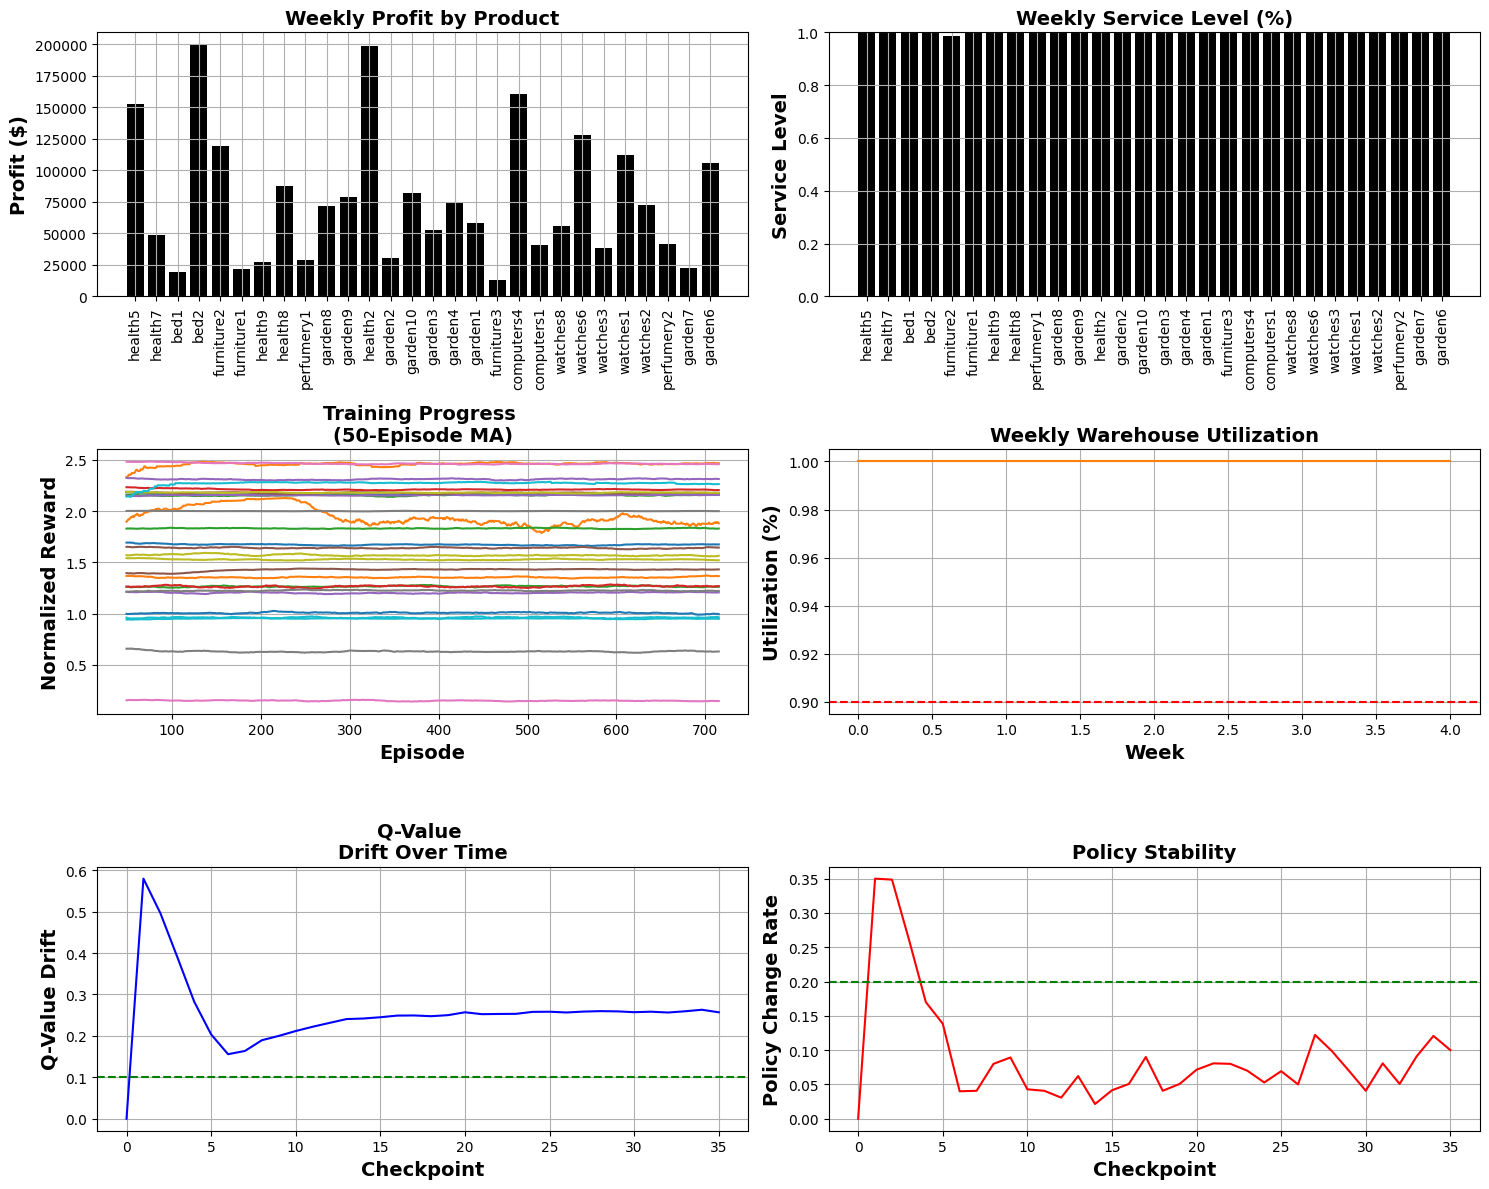

Report saved to retail_optimization_report.pkl

Final Convergence Status: CONVERGED
Final Q-Value Drift: 0.2570


In [ ]:
def prepare_weekly_data(df: pd.DataFrame, min_weeks: int = 4,
                        date_col: str = 'month_year') -> Dict[str, Tuple[List[int], List[float], float]]:
    try:
        df['date'] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.dropna(subset=['date'])

        df['year_week'] = df['date'].dt.to_period('W').astype(str)

        weekly_demand = (
            df.groupby(['product_id', 'year_week'], observed=True)['qty']
            .sum()
            .reset_index()
            .sort_values(['product_id', 'year_week']))

        product_counts = weekly_demand['product_id'].value_counts()
        valid_products = product_counts[product_counts >= min_weeks].index.tolist()

        if not valid_products:
            raise ValueError(f"No products with ≥ {min_weeks} weeks of data")

        products_data = {}
        for product_id in valid_products:
            product_demand = weekly_demand[weekly_demand['product_id'] == product_id]
            demand_series = (
                product_demand.sort_values('year_week')['qty']
                .tolist())

            price_df = (
                df[df['product_id'] == product_id]
                .groupby('year_week', observed=True)[['unit_price', 'qty']]
                .apply(lambda x: np.average(x['unit_price'], weights=x['qty']))
                .reset_index(name='weighted_price')
                .sort_values('year_week'))
            price_series = price_df['weighted_price'].tolist()

            product_data = df[df['product_id'] == product_id]
            valid_transactions = product_data[product_data['qty'] > 0]

            if len(valid_transactions) == 0:
                continue

            try:
                ref_price = np.average(
                    valid_transactions['unit_price'],
                    weights=valid_transactions['qty'])
            except:
                ref_price = valid_transactions['unit_price'].median()

            min_length = min(len(demand_series), len(price_series))
            if min_length < min_weeks:
                continue

            products_data[product_id] = (
                demand_series[:min_length],
                price_series[:min_length],
                ref_price)

        print(f"Prepared data for {len(products_data)} products (min {min_weeks} weeks)")
        return products_data

    except Exception as e:
        print(f"Data preparation failed: {str(e)}")
        return {}

class OptimizedSingleProductEnv:
    def __init__(self, demand_series: List[int], ref_price: float,
                 init_inventory: int = 500,
                 lead_time: int = 1,
                 elasticity: float = -0.8,
                 holding_rate: float = 0.015,
                 stockout_penalty: float = 5.0,
                 order_cost: float = 0.5,
                 safety_stock: int = 10,
                 max_expected_profit: float = 1000.0,
                 profit_weight: float = 0.6,
                 service_weight: float = 0.4):

        self.original_demand = [max(1, int(d)) for d in demand_series]
        self.ref_price = max(0.1, float(ref_price))
        self.weeks = len(self.original_demand)
        self.init_inventory = max(0, int(init_inventory))
        self.lead_time = min(max(1, int(lead_time)), max(1, self.weeks-1))
        self.elasticity = max(-5.0, min(0.0, float(elasticity)))
        self.holding_rate = max(0.0, float(holding_rate))
        self.stockout_penalty = max(0.0, float(stockout_penalty))
        self.order_cost = max(0.0, float(order_cost))
        self.safety_stock = max(0, int(safety_stock))
        self.avg_demand = np.mean(self.original_demand) if self.original_demand else 1

        self.max_expected_profit = max_expected_profit
        self.profit_weight = profit_weight
        self.service_weight = service_weight

        self._calculate_demand_variability()
        self.reset()

    def _calculate_demand_variability(self):
        try:
            if self.weeks > self.lead_time:
                lt_demands = [sum(self.original_demand[i:i+self.lead_time])
                              for i in range(len(self.original_demand)-self.lead_time+1)]
                self.std_demand_lead_time = np.std(lt_demands) if len(lt_demands) > 1 else 3.0
            else:
                self.std_demand_lead_time = np.std(self.original_demand) if len(self.original_demand) > 1 else 3.0
        except:
            self.std_demand_lead_time = 3.0

    def reset(self):
        self.current_week = 0
        self.inventory = self.init_inventory
        self.total_profit = 0
        self.total_demand = 0
        self.total_sales = 0
        self.weekly_stats = []
        return self._get_state()

    def _get_state(self):
        return {
            'inventory': self.inventory,
            'current_week': self.current_week,
            'demand': self.original_demand[self.current_week] if self.current_week < self.weeks else 0,
            'avg_demand': np.mean(self.original_demand[:self.current_week+1]) if self.current_week > 0 else 0}

    def step(self, price: float, order_qty: int = 0) -> float:
        if self.current_week >= self.weeks:
            return 0.0

        try:
            min_price = self.ref_price * 0.7
            price = max(min_price, price)

            base_demand = self.original_demand[self.current_week]
            price_factor = (max(0.1, price) / self.ref_price) ** self.elasticity
            noise = np.random.normal(0, 0.1 * base_demand)
            demand = max(1, int(base_demand * price_factor + noise))

            self.inventory += order_qty
            available = max(self.inventory - self.safety_stock, 0)
            sales_qty = min(available, demand)

            revenue = sales_qty * price
            holding_cost = self.inventory * self.holding_rate
            stockout_cost = max(demand - sales_qty, 0) * self.stockout_penalty
            order_cost_total = order_qty * self.order_cost
            profit = revenue - holding_cost - stockout_cost - order_cost_total

            service_level = sales_qty / max(demand, 1)

            profit_norm = np.tanh(profit / self.max_expected_profit)
            service_norm = service_level
            inventory_penalty = -0.02 * (self.inventory / max(1, self.avg_demand))
            reward = self.profit_weight * profit_norm + self.service_weight * service_norm + inventory_penalty

            prev_inventory = self.inventory
            self.inventory -= sales_qty
            self.total_profit += profit
            self.total_sales += sales_qty
            self.total_demand += demand

            self.weekly_stats.append({
                'week': self.current_week,
                'price': price,
                'order_qty': order_qty,
                'inventory': self.inventory,
                'demand': demand,
                'sales': sales_qty,
                'profit': profit,
                'service_level': service_level,
                'inventory_change': self.inventory - prev_inventory})

            self.current_week += 1
            return reward
        except Exception as e:
            print(f"Error in step: {e}")
            return 0.0

    def service_level(self) -> float:
        if self.total_demand > 0:
            return self.total_sales / self.total_demand
        return 0.0


class MultiProductRetailEnv:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]],
                 warehouse_capacity: int = 4412,
                 shared_transport_cost: float = 0.2):
        self.products = {}
        self.warehouse_capacity = warehouse_capacity
        self.shared_transport_cost = shared_transport_cost
        self.current_week = 0
        self.shared_shipment_count = 0
        self.shared_costs = 0
        self.total_orders_this_week = defaultdict(int)
        self.weekly_warehouse_utilization = []
        self.metrics = {
            'shared_costs_total': 0,
            'over_utilization_penalties': 0,
            'cumulative_rewards': defaultdict(float)}

        for product_id, (demand_series, price_series, ref_price) in products_data.items():
            try:
                self.products[product_id] = {
                    'env': OptimizedSingleProductEnv(demand_series, ref_price),
                    'pending_orders': [],
                    'inventory': 0,
                    'space_required': max(1, int(ref_price / 15))}
            except Exception as e:
                print(f"Error initializing product {product_id}: {e}")
                continue

        if not self.products:
            raise ValueError("No valid products initialized")
        self.reset()

    def reset(self):
        self.current_week = 0
        self.shared_costs = 0
        self.shared_shipment_count = 0
        self.total_orders_this_week = defaultdict(int)
        self.weekly_warehouse_utilization = []
        self.metrics = {
            'shared_costs_total': 0,
            'over_utilization_penalties': 0,
            'cumulative_rewards': defaultdict(float)}

        for product_id, data in self.products.items():
            data['env'].reset()
            data['inventory'] = data['env'].init_inventory
            data['pending_orders'] = []
        return self.get_global_state()

    def get_global_state(self):
        return {
            'current_week': self.current_week,
            'warehouse_utilization': self.get_warehouse_utilization(),
            'total_orders': sum(self.total_orders_this_week.values()),
            'shared_costs': self.shared_costs}

    def get_warehouse_utilization(self):
        total_used = sum(data['inventory'] * data['space_required'] for data in self.products.values())
        return min(1.0, total_used / max(1, self.warehouse_capacity))

    def step(self, actions: Dict[str, Tuple[float, int]]):
        max_weeks = max(len(data['env'].original_demand) for data in self.products.values())
        if self.current_week >= max_weeks:
            return self.get_global_state(), {}, True, {}

        individual_rewards = {}
        self.total_orders_this_week.clear()

        for product_id, (price, order_qty) in actions.items():
            if product_id not in self.products:
                continue
            if order_qty is None:
                max_order = 0
            else:
                product_data = self.products[product_id]
                max_order = self._get_max_order(product_id, order_qty)
            self.total_orders_this_week[product_id] = max_order
            if max_order > 0:
                arrival_week = self.current_week + product_data['env'].lead_time
                product_data['pending_orders'].append((arrival_week, max_order))

        for product_id, (price, order_qty) in actions.items():
            if product_id not in self.products:
                continue
            product_data = self.products[product_id]
            env = product_data['env']
            actual_order_qty = self.total_orders_this_week.get(product_id, 0)
            reward = env.step(price, actual_order_qty)
            product_data['inventory'] = env.inventory
            shared_cost_reduction = self.shared_transport_cost * sum(1 for pid in actions if self.total_orders_this_week.get(pid,0) > 0)
            individual_rewards[product_id] = reward + shared_cost_reduction

        active_orders = sum(1 for qty in self.total_orders_this_week.values() if qty > 0)
        if active_orders > 1:
            self.shared_shipment_count += 1
            shared_penalty = self.shared_transport_cost * (active_orders - 1)
            self.shared_costs += shared_penalty
            self.metrics['shared_costs_total'] += shared_penalty

        self._process_order_arrivals()
        utilization = self.get_warehouse_utilization()
        self.weekly_warehouse_utilization.append(utilization)

        if utilization > 0.85:
            penalty = 50 * (utilization - 0.85)
            self.metrics['over_utilization_penalties'] += penalty
            penalty_per_product = penalty / max(1, len(individual_rewards))
            for pid in individual_rewards:
                individual_rewards[pid] -= penalty_per_product

        self.current_week += 1
        done = self.current_week >= max_weeks
        return self.get_global_state(), individual_rewards, done, {}

    def _get_max_order(self, product_id: str, requested_qty: int) -> int:
        if product_id not in self.products:
            return 0
        product_data = self.products[product_id]
        space_per_unit = product_data['space_required']
        used_space = 0
        for pid, data in self.products.items():
            current_inventory_space = data['inventory'] * data['space_required']
            pending_space = sum(qty * data['space_required'] for week, qty in data['pending_orders'] if week > self.current_week)
            used_space += current_inventory_space + pending_space
        available_space = max(0, self.warehouse_capacity - used_space)
        max_possible = available_space / space_per_unit
        return min(requested_qty, int(max_possible))

    def _process_order_arrivals(self):
        for product_id, product_data in self.products.items():
            arrived_qty = sum(qty for week, qty in product_data['pending_orders'] if week == self.current_week)
            product_data['inventory'] += arrived_qty
            product_data['pending_orders'] = [(week, qty) for week, qty in product_data['pending_orders'] if week > self.current_week]

    def summarize(self):
        return {
            'total_weeks': self.current_week,
            'avg_utilization': np.mean(self.weekly_warehouse_utilization) if self.weekly_warehouse_utilization else 0,
            'shared_shipments': self.shared_shipment_count,
            'shared_costs_total': self.metrics['shared_costs_total'],
            'over_utilization_penalties': self.metrics['over_utilization_penalties'],
            'cumulative_rewards': dict(self.metrics['cumulative_rewards']),
            'product_service_levels': {pid: round(data['env'].service_level(), 3) for pid, data in self.products.items()}}

class OptimizedProductAgent(nn.Module):
    def __init__(self,
                 input_size: int = 5,
                 hidden_size: int = 64,
                 price_bins: int = 10,
                 order_bins: int = 11,
                 lr: float = 0.00005):
        super().__init__()

        self.price_bins_count = price_bins
        self.order_bins_count = order_bins
        self.action_size = price_bins * order_bins

        self.price_bins = np.linspace(0.8, 1.5, self.price_bins_count)
        self.order_bins = np.linspace(0, 50, self.order_bins_count)

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size))

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=50)
        self.memory = []
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = 256
        self.target_update_freq = 5
        self.tau = 0.01
        self.steps = 0
        self.best_avg_reward = -float('inf')
        self.patience_counter = 0
        self.max_patience = 100

        self.target_net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size))
        self._update_target_net()

    def _update_target_net(self):
        for target_param, param in zip(self.target_net.parameters(), self.net.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

    def forward(self, x):
        return self.net(x)

    def get_action(self, state: Dict) -> Tuple[float, int]:
        if random.random() < self.epsilon:
            price_idx = random.randint(0, len(self.price_bins)-1)
            order_idx = random.randint(0, len(self.order_bins)-1)
            return self.price_bins[price_idx], self.order_bins[order_idx]

        state_tensor = torch.FloatTensor([
            state['inventory'],
            state['demand'],
            state['avg_demand'],
            state['global']['warehouse_utilization'],
            state['global']['current_week'] / 52])

        with torch.no_grad():
            q_values = self(state_tensor)
            q_values_2d = q_values.view(self.price_bins_count, self.order_bins_count)
            max_idx = torch.argmax(q_values_2d)
            price_idx = max_idx // self.order_bins_count
            order_idx = max_idx % self.order_bins_count

        return self.price_bins[price_idx], self.order_bins[order_idx]

    def act(self, state: List) -> Tuple[float, int]:
        state = np.array(state)
        state_normalized = (state - state.mean()) / (state.std() + 1e-8)

        if random.random() < self.epsilon:
            return random.uniform(0.8, 1.2), random.randint(0, 30)  # Tighter exploration

        state_tensor = torch.FloatTensor(state_normalized)
        with torch.no_grad():
            q_values = self(state_tensor.unsqueeze(0))
            action_idx = torch.argmax(q_values).item()
            price_idx = action_idx // self.order_bins_count
            order_idx = action_idx % self.order_bins_count
            price_factor = self.price_bins[price_idx]
            order_qty = self.order_bins[order_idx]
        return price_factor, int(order_qty)

    def remember(self, state, action, reward, next_state, done=False):
        if isinstance(state, dict):
            price, order = action
            price_idx = np.argmin(np.abs(self.price_bins - price))
            order_idx = np.argmin(np.abs(self.order_bins - order))
            action_idx = price_idx * self.order_bins_count + order_idx
            state_tensor = [
                state['inventory'],
                state['demand'],
                state['avg_demand'],
                state['global']['warehouse_utilization'],
                state['global']['current_week'] / 52]
            next_state_tensor = [
                next_state['inventory'],
                next_state['current_week'],
                next_state['demand'],
                next_state['avg_demand'],
                next_state['global']['warehouse_utilization'],
                next_state['global']['current_week'] / 52] if next_state is not None else [0,0,0,0,0,0]
        else:
            price_factor, order_qty = action
            price_idx = np.argmin(np.abs(self.price_bins - price_factor))
            order_idx = np.argmin(np.abs(self.order_bins - order_qty))
            action_idx = price_idx * self.order_bins_count + order_idx
            state_tensor = state
            next_state_tensor = next_state if next_state is not None else [0,0,0,0]

        state_tensor_t = torch.FloatTensor(state_tensor)
        with torch.no_grad():
            current_q = self(state_tensor_t.unsqueeze(0))[0, action_idx].item()
            next_state_tensor_t = torch.FloatTensor(next_state_tensor)
            next_q = self.target_net(next_state_tensor_t.unsqueeze(0)).max().item()
            td_error = abs(reward + self.gamma * next_q - current_q)

        priority = td_error + 1e-5
        self.memory.append((state_tensor, action_idx, reward, next_state_tensor, priority))

    def replay(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        if len(self.memory) < batch_size:
            return False

        priorities = np.array([mem[4] for mem in self.memory])
        probabilities = priorities / priorities.sum()
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)

        is_weights = (len(self.memory) * probabilities[indices]) ** -0.4
        is_weights = torch.FloatTensor(is_weights / is_weights.max())

        batch = [self.memory[i] for i in indices]
        states, action_indices, rewards, next_states, _ = zip(*batch)

        state_tensors = torch.FloatTensor(states)
        next_state_tensors = torch.FloatTensor(next_states)
        action_tensors = torch.LongTensor(action_indices).unsqueeze(1)
        reward_tensors = torch.FloatTensor(rewards)

        current_q = self(state_tensors).gather(1, action_tensors)

        with torch.no_grad():
            next_q = self.target_net(next_state_tensors).max(1)[0]
            target_q = reward_tensors + self.gamma * next_q

        loss = (is_weights * nn.SmoothL1Loss(reduction='none')(current_q.squeeze(), target_q)).mean()

        self.optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=0.5)

        self.optimizer.step()

        recent_rewards = [mem[2] for mem in self.memory[-100:]] if len(self.memory) > 100 else [0]
        avg_reward = np.mean(recent_rewards)
        self.scheduler.step(avg_reward)

        if len(recent_rewards) >= 50:
            if avg_reward > self.best_avg_reward:
                self.best_avg_reward = avg_reward
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.max_patience:
                return True

        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self._update_target_net()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        return False

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def validate(self):
        if len(self.memory) < 50:
            return 0.0

        recent_losses = []
        for i in range(-50, -1):
            state, action, reward, next_state, _ = self.memory[i]
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                current_q = self(state_tensor)[0, action].item()
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
                next_q = self.target_net(next_state_tensor).max().item()
                target_q = reward + self.gamma * next_q
                loss = abs(current_q - target_q)
                recent_losses.append(loss)

        return np.mean(recent_losses)

class OptimizedMultiAgentCoordinator:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]]):
        if not products_data:
            raise ValueError("No products data provided")

        self.env = MultiProductRetailEnv(products_data)
        self.agents = {}
        self.rewards_history = defaultdict(list)
        self.metrics = {'total_episode_rewards': []}
        self.convergence_metrics = []

        for product_id, (demand_series, price_series, ref_price) in products_data.items():
            self.agents[product_id] = OptimizedProductAgent(
                input_size=4,
                price_bins=10,
                order_bins=11,
                lr=0.00005)

    def train(self, episodes: int = 1000, eval_every: int = 50, batch_size=32):
        max_weeks = max([len(data['env'].original_demand) for data in self.env.products.values()])
        converged = False

        for ep in range(episodes):
            if converged:
                print(f"Training converged at episode {ep}")
                break

            self.env.reset()
            episode_rewards = defaultdict(float)
            done = False

            for week in range(max_weeks):
                actions = {}
                for pid, agent in self.agents.items():
                    if self.env.products[pid]['env'].current_week < self.env.products[pid]['env'].weeks:
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        agent_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        price_factor, order_qty = agent.act(agent_state)
                        actual_price = price_factor * self.env.products[pid]['env'].ref_price
                        actions[pid] = (actual_price, order_qty)
                    else:
                        actions[pid] = (None, None)

                global_state, individual_rewards, done, _ = self.env.step(actions)

                for pid, reward in individual_rewards.items():
                    if pid in actions and actions[pid][0] is not None:
                        episode_rewards[pid] += reward
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        current_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        next_agent_state_data = self.env.products[pid]['env']._get_state()
                        next_state = [
                            next_agent_state_data['inventory'],
                            next_agent_state_data['current_week'],
                            next_agent_state_data['demand'],
                            next_agent_state_data['avg_demand']]
                        self.agents[pid].remember(
                            current_state,
                            (price_factor, order_qty),
                            reward,
                            next_state)
                        self.agents[pid].decay_epsilon()

                if done:
                    break

            convergence_signals = []
            for pid, agent in self.agents.items():
                validation_loss = agent.validate()
                if validation_loss < 1000:
                    should_stop = agent.replay(batch_size)
                    convergence_signals.append(should_stop)
                else:
                    print(f"Warning: Agent {pid} validation loss too high ({validation_loss:.2f}), skipping replay")
                    convergence_signals.append(False)

            if all(convergence_signals):
                converged = True

            total_episode_reward = sum(episode_rewards.values())
            self.metrics['total_episode_rewards'].append(total_episode_reward)

            for pid, reward in episode_rewards.items():
                self.rewards_history[pid].append(reward)

            if ep % 20 == 0:
                convergence_metrics = self.calculate_convergence_metrics()
                self.convergence_metrics.append(convergence_metrics)
                status_symbol = "✓" if convergence_metrics['convergence_status'] == "CONVERGED" else "➡" if convergence_metrics['convergence_status'] == "STABILIZING" else "↗"
                print(f"Episode {ep+1}/{episodes} {status_symbol} | Reward: {total_episode_reward:.2f} | Q-Drift: {convergence_metrics['q_value_drift']:.4f} | Status: {convergence_metrics['convergence_status']}")

            if (ep+1) % eval_every == 0:
                print(f"Episode {ep+1}/{episodes} | Total Reward: {total_episode_reward:.2f}")

        return self.rewards_history, self.env


    def calculate_convergence_metrics(self, window_size: int = 50, k: float = 0.5):
        metrics = {}
        policy_changes = []
        for pid, agent in self.agents.items():
            if hasattr(agent, 'memory') and len(agent.memory) > 100:
                recent_actions = [mem[1] for mem in agent.memory[-100:]]
                pcr = len(set(recent_actions)) / len(recent_actions)
                policy_changes.append(pcr)
        metrics['policy_change_rate'] = np.mean(policy_changes) if policy_changes else 0

        q_drifts = []
        for pid, agent in self.agents.items():
            if hasattr(agent, 'memory') and len(agent.memory) > 50:
                recent_q_changes = []
                for i in range(len(agent.memory)-50, len(agent.memory)-1):
                    state, action, reward, next_state, _ = agent.memory[i]
                    state_tensor = torch.FloatTensor(state)
                    with torch.no_grad():
                        current_q = agent(state_tensor.unsqueeze(0))[0, action].item()
                        next_q = agent.target_net(torch.FloatTensor(next_state).unsqueeze(0)).max().item()
                    q_drift = abs(current_q - next_q)
                    recent_q_changes.append(q_drift)
                q_drifts.append(np.mean(recent_q_changes))
        metrics['q_value_drift'] = np.mean(q_drifts) if q_drifts else 0
        metrics['q_value_stability'] = np.std(q_drifts[-10:]) if q_drifts and len(q_drifts) > 10 else 0
        metrics['policy_consistency'] = 1 - metrics['policy_change_rate']

        episode_rewards = []
        for pid, rewards in self.rewards_history.items():
            if rewards and len(rewards) > 20:
                episode_rewards.append(np.mean(rewards[-20:]))
        metrics['avg_episode_reward'] = np.mean(episode_rewards) if episode_rewards else 0

        return_variances = []
        for pid, rewards in self.rewards_history.items():
            if len(rewards) > window_size:
                rolling_variance = pd.Series(rewards).rolling(window=window_size).var().dropna()
                return_variances.extend(rolling_variance.tolist())
        metrics['return_variance'] = np.mean(return_variances) if return_variances else 0

        exploration_rates = [agent.epsilon for agent in self.agents.values()]
        metrics['exploration_rate'] = np.mean(exploration_rates) if exploration_rates else 0

        def dynamic_threshold(values):
            arr = np.array(values)
            if len(arr) == 0:
                return 0.05
            return np.mean(arr) + k * np.std(arr)

        q_threshold = dynamic_threshold(q_drifts)
        policy_threshold = dynamic_threshold(policy_changes)
        stability_threshold = dynamic_threshold(q_drifts[-10:] if len(q_drifts) >= 10 else q_drifts)
        return_threshold = dynamic_threshold(return_variances)

        if (metrics['q_value_drift'] < q_threshold and
            metrics['policy_change_rate'] < policy_threshold and
            metrics['q_value_stability'] < stability_threshold and
            metrics['return_variance'] < return_threshold):
            metrics['convergence_status'] = "CONVERGED"
        elif (metrics['q_value_drift'] < 2 * q_threshold and
              metrics['policy_change_rate'] < 2 * policy_threshold):
            metrics['convergence_status'] = "STABILIZING"
        else:
            metrics['convergence_status'] = "LEARNING"

        return metrics


    def evaluate(self, num_episodes: int = 10):
        results = {}
        for pid in self.agents.keys():
            results[pid] = {
                'total_profit': 0,
                'total_demand': 0,
                'total_sales': 0,
                'weekly_stats': []}
        max_weeks = max([len(data['env'].original_demand) for data in self.env.products.values()])

        for _ in range(num_episodes):
            self.env.reset()
            for week in range(max_weeks):
                actions = {}
                for pid, agent in self.agents.items():
                    if self.env.products[pid]['env'].current_week < self.env.products[pid]['env'].weeks:
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        agent_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        price_factor, order_qty = agent.act(agent_state)
                        actual_price = price_factor * self.env.products[pid]['env'].ref_price
                        actions[pid] = (actual_price, order_qty)
                    else:
                        actions[pid] = (None, None)

                global_state, individual_rewards, done, _ = self.env.step(actions)

                for pid in self.agents.keys():
                    if pid in self.env.products:
                        env = self.env.products[pid]['env']
                        results[pid]['total_profit'] += env.total_profit
                        results[pid]['total_demand'] += env.total_demand
                        results[pid]['total_sales'] += env.total_sales
                        latest_weekly_stat = next(
                            (item for item in reversed(env.weekly_stats) if item['week'] == env.current_week - 1),
                            None)
                        if latest_weekly_stat:
                             results[pid]['weekly_stats'].append(latest_weekly_stat)
                if done:
                    break

        for pid in results.keys():
            results[pid]['total_profit'] /= num_episodes
            results[pid]['total_demand'] /= num_episodes
            results[pid]['total_sales'] /= num_episodes
            results[pid]['service_level'] = results[pid]['total_sales'] / results[pid]['total_demand'] if results[pid]['total_demand'] > 0 else 0

        return results

def generate_performance_report(results, env):
    inventory_metrics = {}
    for pid, stats in results.items():
        inventory_levels = [w['inventory'] for w in stats['weekly_stats']]
        avg_inventory = np.mean(inventory_levels)
        inventory_turnover = stats['total_sales'] / avg_inventory if avg_inventory > 0 else 0
        stockout_weeks = sum(1 for w in stats['weekly_stats'] if w.get('service_level', 1) < 0.5)
        avg_service = np.mean([w.get('service_level', 0) for w in stats['weekly_stats']])

        inventory_metrics[pid] = {
            'avg_inventory': avg_inventory,
            'inventory_turnover': inventory_turnover,
            'stockout_weeks': stockout_weeks,
            'max_inventory': max(inventory_levels) if inventory_levels else 0,
            'min_inventory': min(inventory_levels) if inventory_levels else 0,
            'avg_service': avg_service,
            'avg_demand': np.mean([w.get('demand', 0) for w in stats['weekly_stats']])}

    total_profit = sum(stats['total_profit'] for stats in results.values())
    profit_share = {pid: stats['total_profit'] / total_profit for pid, stats in results.items()}

    report = {
        'summary_metrics': {
            'total_profit': total_profit,
            'avg_service_level': np.mean([metrics['avg_service'] for metrics in inventory_metrics.values()]),
            'warehouse_stats': {
                'peak_utilization': max(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'avg_utilization': np.mean(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'overcapacity_weeks': sum(u > 0.85 for u in env.weekly_warehouse_utilization)},
            'shared_shipments': env.shared_shipment_count,
            'shared_costs_total': env.metrics['shared_costs_total'],
            'over_utilization_penalties': env.metrics['over_utilization_penalties'],
            'cumulative_rewards': dict(env.metrics['cumulative_rewards']),
            'product_service_levels': {pid: round(data['env'].service_level(), 3) for pid, data in env.products.items()},
            'profit_share': profit_share},
        'product_breakdown': {
            pid: {**stats, **inventory_metrics[pid]} for pid, stats in results.items()}}

    return report

def generate_executive_summary(report):
    sm = report['summary_metrics']
    products = report['product_breakdown']

    best_product = max(products.items(), key=lambda x: x[1]['avg_service'])
    worst_product = min(products.items(), key=lambda x: x[1]['avg_service'])
    most_profitable = max(products.items(), key=lambda x: x[1]['total_profit'])

    summary = f"""
    RETAIL OPTIMIZATION REPORT - WEEKLY OPERATIONS
    {'=' * 70}

    SYSTEM PERFORMANCE SUMMARY
    {'-' * 70}
    • Total Profit: ${sm['total_profit']:,.2f}
    • Average Service Level: {sm['avg_service_level']:.1%}
      (Target: 70%+, Current Gap: {(0.7 - sm['avg_service_level']):.1%})
    • Warehouse Utilization:
      - Peak: {sm['warehouse_stats']['peak_utilization']:.1%}
      - Average: {sm['warehouse_stats']['avg_utilization']:.1%}
      - Overcapacity Weeks: {sm['warehouse_stats']['overcapacity_weeks']}
    • Shared Shipments: {sm['shared_shipments']} (Cost Savings: ${sm['shared_costs_total']:,.2f})

    PRODUCT PERFORMANCE HIGHLIGHTS
    {'-' * 70}
    • Best Service: {best_product[0]} ({best_product[1]['avg_service']:.1%})
    • Worst Service: {worst_product[0]} ({worst_product[1]['avg_service']:.1%})
    • Most Profitable: {most_profitable[0]} (${most_profitable[1]['total_profit']:,.2f})

    KEY RECOMMENDATIONS
    {'-' * 70}"""

    if sm['warehouse_stats']['avg_utilization'] < 0.7:
        summary += "\n• Warehouse space underutilized - consider consolidation"
    elif sm['warehouse_stats']['avg_utilization'] > 0.9:
        summary += "\n• Warehouse frequently at capacity - optimize space allocation"

    if sm['avg_service_level'] < 0.9:
        summary += "\n• Service levels below target - review safety stocks"
    elif sm['avg_service_level'] > 0.98:
        summary += "\n• Service levels very high - opportunity to reduce inventory"

    low_service_products = [
        (pid, data) for pid, data in products.items()
        if data['avg_service'] < 0.5]
    if low_service_products:
        summary += "\n\nCRITICAL PRODUCTS NEEDING ATTENTION:"
        for pid, data in sorted(low_service_products, key=lambda x: x[1]['avg_service'])[:3]:
            summary += f"\n  - {pid}: Service Level {data['avg_service']:.1%} (Stockouts: {data['stockout_weeks']} weeks)"

    return summary

def create_visualizations(report, rewards_history, env, convergence_metrics=None):
    products = list(report['product_breakdown'].keys())
    colors = plt.cm.get_cmap('tab10', len(products)).colors

    if convergence_metrics:
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    ax1 = axes[0, 0] if convergence_metrics else axes[0]
    profits = [report['product_breakdown'][p]['total_profit'] for p in products]
    ax1.bar(products, profits, color='k')
    ax1.set_title('Weekly Profit by Product', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Profit ($)', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=90)
    ax1.tick_params(axis='y')
    ax1.grid()

    ax2 = axes[0, 1] if convergence_metrics else axes[1]
    service_levels = [report['product_breakdown'][p]['service_level'] for p in products]
    ax2.bar(products, service_levels, color='k')
    ax2.set_title('Weekly Service Level (%)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Service Level', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='y')
    ax2.set_ylim(0, 1.0)
    ax2.grid()
    ax2.tick_params(axis='x', rotation=90)

    ax3 = axes[1, 0] if convergence_metrics else axes[2]
    for i, (pid, rewards) in enumerate(rewards_history.items()):
        ax3.plot(pd.Series(rewards).rolling(50).mean(), label=pid, color=colors[i % len(colors)])
    ax3.set_title('Training Progress \n(50-Episode MA)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Episode', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Normalized Reward', fontsize=14, fontweight='bold')
    ax3.grid(True)

    ax4 = axes[1, 1] if convergence_metrics else axes[3]
    ax4.plot(env.weekly_warehouse_utilization, label='Utilization', color=colors[3])
    ax4.axhline(y=0.9, color='r', linestyle='--', label='Capacity Limit')
    ax4.set_title('Weekly Warehouse Utilization', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Week', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Utilization (%)', fontsize=14, fontweight='bold')
    # ax4.legend()
    ax4.grid()

    if convergence_metrics:
        ax5 = axes[2, 0]
        q_drifts = [m['q_value_drift'] for m in convergence_metrics]
        ax5.plot(q_drifts, 'b-', label='Q-Value Drift')
        ax5.axhline(y=0.1, color='g', linestyle='--', label='Stable Threshold')
        ax5.set_title('Q-Value \nDrift Over Time', fontsize=14, fontweight='bold')
        ax5.set_xlabel('Checkpoint', fontsize=14, fontweight='bold')
        ax5.set_ylabel('Q-Value Drift', fontsize=14, fontweight='bold')
        # ax5.legend()
        ax5.grid()

        ax6 = axes[2, 1]
        policy_changes = [m['policy_change_rate'] for m in convergence_metrics]
        ax6.plot(policy_changes, 'r-', label='Policy Change Rate')
        ax6.axhline(y=0.2, color='g', linestyle='--', label='Stable Threshold')
        ax6.set_title('Policy Stability', fontsize=14, fontweight='bold')
        ax6.set_xlabel('Checkpoint', fontsize=14, fontweight='bold')
        ax6.set_ylabel('Policy Change Rate', fontsize=14, fontweight='bold')
        # ax6.legend()
        ax6.grid()

    plt.tight_layout()
    plt.show()

def generate_full_report(env, rewards_history, convergence_metrics=None):
    results = coordinator.evaluate()
    performance_report = generate_performance_report(results, env)

    report_package = {
        'executive_summary': generate_executive_summary(performance_report),
        'performance_metrics': performance_report,
        'training_history': rewards_history,
        'convergence_metrics': convergence_metrics,
        'environment_state': env,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

    return report_package

def save_report(report, filename='retail_optimization_report.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(report, f)
    print(f"Report saved to {filename}")

def load_report(filename='retail_optimization_report.pkl'):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def export_key_tables(report):
    product_data = []
    for pid, stats in report['performance_metrics']['product_breakdown'].items():
        product_data.append({
            'product_id': pid,
            'total_profit': stats['total_profit'],
            'avg_service_level': stats['avg_service'],
            'avg_inventory': stats['avg_inventory'],
            'inventory_turns': stats['inventory_turnover'],
            'stockout_weeks': stats['stockout_weeks'],
            'profit_share': report['performance_metrics']['summary_metrics']['profit_share'][pid]})
    pd.DataFrame(product_data).to_csv('product_performance.csv', index=False)

if __name__ == "__main__":
    products_data = prepare_weekly_data(df)
    print(f"\nFound {len(products_data)} products with sufficient weekly data")

    coordinator = OptimizedMultiAgentCoordinator(products_data)
    rewards_history, final_env = coordinator.train(episodes=1000)

    full_report = generate_full_report(final_env, rewards_history, coordinator.convergence_metrics)
    print("\n" + "=" * 80)
    print(full_report['executive_summary'])
    print("=" * 80)

    create_visualizations(
        full_report['performance_metrics'],
        full_report['training_history'],
        final_env,
        full_report['convergence_metrics'])

    save_report(full_report)
    export_key_tables(full_report)

    if coordinator.convergence_metrics:
        final_status = coordinator.convergence_metrics[-1]['convergence_status']
        q_drift = coordinator.convergence_metrics[-1]['q_value_drift']
        print(f"\nFinal Convergence Status: {final_status}")
        print(f"Final Q-Value Drift: {q_drift:.4f}")

## **Federated RL**

Prepared data for 28 products (min 4 weeks)

Found 28 products with sufficient weekly data
Episode 1/1000 ✓ | Reward: 46.46 | Q-Drift: 0.0000 | Status: CONVERGED
Episode 21/1000 ➡ | Reward: 45.46 | Q-Drift: 0.5847 | Status: STABILIZING
Episode 41/1000 ✓ | Reward: 46.71 | Q-Drift: 0.4837 | Status: CONVERGED
Episode 50/1000 | Total Reward: 45.82
Episode 61/1000 ✓ | Reward: 46.55 | Q-Drift: 0.3809 | Status: CONVERGED
Episode 81/1000 ✓ | Reward: 46.59 | Q-Drift: 0.2930 | Status: CONVERGED
Episode 100/1000 | Total Reward: 45.82
Episode 101/1000 ✓ | Reward: 46.77 | Q-Drift: 0.2404 | Status: CONVERGED
Episode 121/1000 ✓ | Reward: 46.31 | Q-Drift: 0.2116 | Status: CONVERGED
Episode 141/1000 ✓ | Reward: 46.03 | Q-Drift: 0.1989 | Status: CONVERGED
Episode 150/1000 | Total Reward: 46.30
Episode 161/1000 ✓ | Reward: 46.71 | Q-Drift: 0.2059 | Status: CONVERGED
Episode 181/1000 ✓ | Reward: 46.34 | Q-Drift: 0.2274 | Status: CONVERGED
Episode 200/1000 | Total Reward: 46.09
Episode 201/1000 ✓ | Reward:

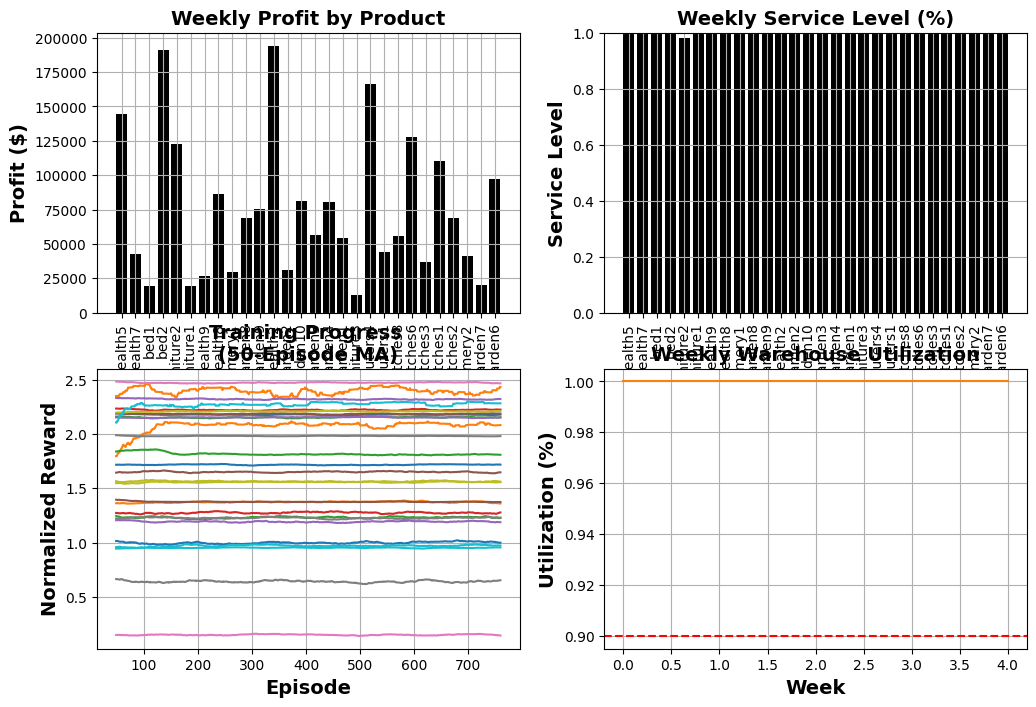

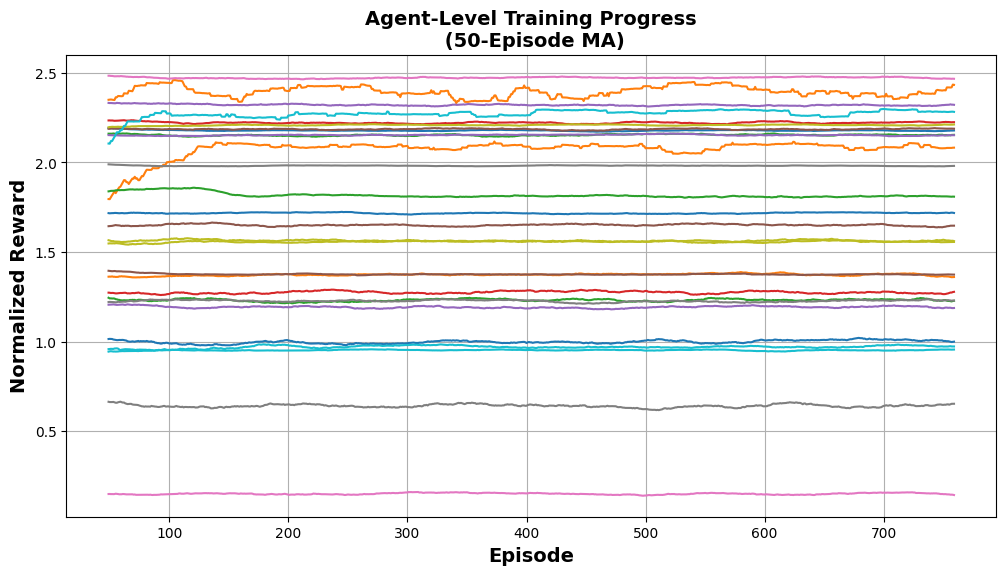

<Figure size 640x480 with 0 Axes>


Final Convergence Status: CONVERGED
Final Q-Value Drift: 0.2768


In [ ]:
def prepare_weekly_data(df: pd.DataFrame, min_weeks: int = 4,
                        date_col: str = 'month_year') -> Dict[str, Tuple[List[int], List[float], float]]:
    try:
        df['date'] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.dropna(subset=['date'])

        df['year_week'] = df['date'].dt.to_period('W').astype(str)

        weekly_demand = (
            df.groupby(['product_id', 'year_week'], observed=True)['qty']
            .sum()
            .reset_index()
            .sort_values(['product_id', 'year_week']))

        product_counts = weekly_demand['product_id'].value_counts()
        valid_products = product_counts[product_counts >= min_weeks].index.tolist()

        if not valid_products:
            raise ValueError(f"No products with ≥ {min_weeks} weeks of data")

        products_data = {}
        for product_id in valid_products:
            product_demand = weekly_demand[weekly_demand['product_id'] == product_id]
            demand_series = (
                product_demand.sort_values('year_week')['qty']
                .tolist())

            price_df = (
                df[df['product_id'] == product_id]
                .groupby('year_week', observed=True)[['unit_price', 'qty']]
                .apply(lambda x: np.average(x['unit_price'], weights=x['qty']))
                .reset_index(name='weighted_price')
                .sort_values('year_week'))
            price_series = price_df['weighted_price'].tolist()

            product_data = df[df['product_id'] == product_id]
            valid_transactions = product_data[product_data['qty'] > 0]

            if len(valid_transactions) == 0:
                continue

            try:
                ref_price = np.average(
                    valid_transactions['unit_price'],
                    weights=valid_transactions['qty'])
            except:
                ref_price = valid_transactions['unit_price'].median()

            min_length = min(len(demand_series), len(price_series))
            if min_length < min_weeks:
                continue

            products_data[product_id] = (
                demand_series[:min_length],
                price_series[:min_length],
                ref_price)

        print(f"Prepared data for {len(products_data)} products (min {min_weeks} weeks)")
        return products_data

    except Exception as e:
        print(f"Data preparation failed: {str(e)}")
        return {}

class OptimizedSingleProductEnv:
    def __init__(self, demand_series: List[int], ref_price: float,
                 init_inventory: int = 500,
                 lead_time: int = 1,
                 elasticity: float = -0.8,
                 holding_rate: float = 0.015,
                 stockout_penalty: float = 5.0,
                 order_cost: float = 0.5,
                 safety_stock: int = 10,
                 max_expected_profit: float = 1000.0,
                 profit_weight: float = 0.6,
                 service_weight: float = 0.4):

        self.original_demand = [max(1, int(d)) for d in demand_series]
        self.ref_price = max(0.1, float(ref_price))
        self.weeks = len(self.original_demand)
        self.init_inventory = max(0, int(init_inventory))
        self.lead_time = min(max(1, int(lead_time)), max(1, self.weeks-1))
        self.elasticity = max(-5.0, min(0.0, float(elasticity)))
        self.holding_rate = max(0.0, float(holding_rate))
        self.stockout_penalty = max(0.0, float(stockout_penalty))
        self.order_cost = max(0.0, float(order_cost))
        self.safety_stock = max(0, int(safety_stock))
        self.avg_demand = np.mean(self.original_demand) if self.original_demand else 1

        self.max_expected_profit = max_expected_profit
        self.profit_weight = profit_weight
        self.service_weight = service_weight

        self._calculate_demand_variability()
        self.reset()

    def _calculate_demand_variability(self):
        try:
            if self.weeks > self.lead_time:
                lt_demands = [sum(self.original_demand[i:i+self.lead_time])
                              for i in range(len(self.original_demand)-self.lead_time+1)]
                self.std_demand_lead_time = np.std(lt_demands) if len(lt_demands) > 1 else 3.0
            else:
                self.std_demand_lead_time = np.std(self.original_demand) if len(self.original_demand) > 1 else 3.0
        except:
            self.std_demand_lead_time = 3.0

    def reset(self):
        self.current_week = 0
        self.inventory = self.init_inventory
        self.total_profit = 0
        self.total_demand = 0
        self.total_sales = 0
        self.weekly_stats = []
        return self._get_state()

    def _get_state(self):
        return {
            'inventory': self.inventory,
            'current_week': self.current_week,
            'demand': self.original_demand[self.current_week] if self.current_week < self.weeks else 0,
            'avg_demand': np.mean(self.original_demand[:self.current_week+1]) if self.current_week > 0 else 0}

    def step(self, price: float, order_qty: int = 0) -> float:
        if self.current_week >= self.weeks:
            return 0.0

        try:
            min_price = self.ref_price * 0.7
            price = max(min_price, price)

            base_demand = self.original_demand[self.current_week]
            price_factor = (max(0.1, price) / self.ref_price) ** self.elasticity
            noise = np.random.normal(0, 0.1 * base_demand)
            demand = max(1, int(base_demand * price_factor + noise))

            self.inventory += order_qty
            available = max(self.inventory - self.safety_stock, 0)
            sales_qty = min(available, demand)

            revenue = sales_qty * price
            holding_cost = self.inventory * self.holding_rate
            stockout_cost = max(demand - sales_qty, 0) * self.stockout_penalty
            order_cost_total = order_qty * self.order_cost
            profit = revenue - holding_cost - stockout_cost - order_cost_total

            service_level = sales_qty / max(demand, 1)

            profit_norm = np.tanh(profit / self.max_expected_profit)
            service_norm = service_level
            inventory_penalty = -0.02 * (self.inventory / max(1, self.avg_demand))
            reward = self.profit_weight * profit_norm + self.service_weight * service_norm + inventory_penalty

            prev_inventory = self.inventory
            self.inventory -= sales_qty
            self.total_profit += profit
            self.total_sales += sales_qty
            self.total_demand += demand

            self.weekly_stats.append({
                'week': self.current_week,
                'price': price,
                'order_qty': order_qty,
                'inventory': self.inventory,
                'demand': demand,
                'sales': sales_qty,
                'profit': profit,
                'service_level': service_level,
                'inventory_change': self.inventory - prev_inventory})

            self.current_week += 1
            return reward
        except Exception as e:
            print(f"Error in step: {e}")
            return 0.0

    def service_level(self) -> float:
        if self.total_demand > 0:
            return self.total_sales / self.total_demand
        return 0.0

class MultiProductRetailEnv:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]],
                 warehouse_capacity: int = 4412,
                 shared_transport_cost: float = 0.2):
        self.products = {}
        self.warehouse_capacity = warehouse_capacity
        self.shared_transport_cost = shared_transport_cost
        self.current_week = 0
        self.shared_shipment_count = 0
        self.shared_costs = 0
        self.total_orders_this_week = defaultdict(int)
        self.weekly_warehouse_utilization = []
        self.metrics = {
            'shared_costs_total': 0,
            'over_utilization_penalties': 0,
            'cumulative_rewards': defaultdict(float)}

        for product_id, (demand_series, price_series, ref_price) in products_data.items():
            try:
                self.products[product_id] = {
                    'env': OptimizedSingleProductEnv(demand_series, ref_price),
                    'pending_orders': [],
                    'inventory': 0,
                    'space_required': max(1, int(ref_price / 15))}
            except Exception as e:
                print(f"Error initializing product {product_id}: {e}")
                continue

        if not self.products:
            raise ValueError("No valid products initialized")
        self.reset()

    def reset(self):
        self.current_week = 0
        self.shared_costs = 0
        self.shared_shipment_count = 0
        self.total_orders_this_week = defaultdict(int)
        self.weekly_warehouse_utilization = []
        self.metrics = {
            'shared_costs_total': 0,
            'over_utilization_penalties': 0,
            'cumulative_rewards': defaultdict(float)}

        for product_id, data in self.products.items():
            data['env'].reset()
            data['inventory'] = data['env'].init_inventory
            data['pending_orders'] = []
        return self.get_global_state()

    def get_global_state(self):
        return {
            'current_week': self.current_week,
            'warehouse_utilization': self.get_warehouse_utilization(),
            'total_orders': sum(self.total_orders_this_week.values()),
            'shared_costs': self.shared_costs}

    def get_warehouse_utilization(self):
        total_used = sum(data['inventory'] * data['space_required'] for data in self.products.values())
        return min(1.0, total_used / max(1, self.warehouse_capacity))

    def step(self, actions: Dict[str, Tuple[float, int]]):
        max_weeks = max(len(data['env'].original_demand) for data in self.products.values())
        if self.current_week >= max_weeks:
            return self.get_global_state(), {}, True, {}

        individual_rewards = {}
        self.total_orders_this_week.clear()

        for product_id, (price, order_qty) in actions.items():
            if product_id not in self.products:
                continue
            if order_qty is None:
                max_order = 0
            else:
                product_data = self.products[product_id]
                max_order = self._get_max_order(product_id, order_qty)
            self.total_orders_this_week[product_id] = max_order
            if max_order > 0:
                arrival_week = self.current_week + product_data['env'].lead_time
                product_data['pending_orders'].append((arrival_week, max_order))

        for product_id, (price, order_qty) in actions.items():
            if product_id not in self.products:
                continue
            product_data = self.products[product_id]
            env = product_data['env']
            actual_order_qty = self.total_orders_this_week.get(product_id, 0)
            reward = env.step(price, actual_order_qty)
            product_data['inventory'] = env.inventory
            shared_cost_reduction = self.shared_transport_cost * sum(1 for pid in actions if self.total_orders_this_week.get(pid,0) > 0)
            individual_rewards[product_id] = reward + shared_cost_reduction

        active_orders = sum(1 for qty in self.total_orders_this_week.values() if qty > 0)
        if active_orders > 1:
            self.shared_shipment_count += 1
            shared_penalty = self.shared_transport_cost * (active_orders - 1)
            self.shared_costs += shared_penalty
            self.metrics['shared_costs_total'] += shared_penalty

        self._process_order_arrivals()
        utilization = self.get_warehouse_utilization()
        self.weekly_warehouse_utilization.append(utilization)

        if utilization > 0.85:
            penalty = 50 * (utilization - 0.85)
            self.metrics['over_utilization_penalties'] += penalty
            penalty_per_product = penalty / max(1, len(individual_rewards))
            for pid in individual_rewards:
                individual_rewards[pid] -= penalty_per_product

        self.current_week += 1
        done = self.current_week >= max_weeks
        return self.get_global_state(), individual_rewards, done, {}

    def _get_max_order(self, product_id: str, requested_qty: int) -> int:
        if product_id not in self.products:
            return 0
        product_data = self.products[product_id]
        space_per_unit = product_data['space_required']
        used_space = 0
        for pid, data in self.products.items():
            current_inventory_space = data['inventory'] * data['space_required']
            pending_space = sum(qty * data['space_required'] for week, qty in data['pending_orders'] if week > self.current_week)
            used_space += current_inventory_space + pending_space
        available_space = max(0, self.warehouse_capacity - used_space)
        max_possible = available_space / space_per_unit
        return min(requested_qty, int(max_possible))

    def _process_order_arrivals(self):
        for product_id, product_data in self.products.items():
            arrived_qty = sum(qty for week, qty in product_data['pending_orders'] if week == self.current_week)
            product_data['inventory'] += arrived_qty
            product_data['pending_orders'] = [(week, qty) for week, qty in product_data['pending_orders'] if week > self.current_week]

    def summarize(self):
        return {
            'total_weeks': self.current_week,
            'avg_utilization': np.mean(self.weekly_warehouse_utilization) if self.weekly_warehouse_utilization else 0,
            'shared_shipments': self.shared_shipment_count,
            'shared_costs_total': self.metrics['shared_costs_total'],
            'over_utilization_penalties': self.metrics['over_utilization_penalties'],
            'cumulative_rewards': dict(self.metrics['cumulative_rewards']),
            'product_service_levels': {pid: round(data['env'].service_level(), 3) for pid, data in self.products.items()}}


class OptimizedProductAgent(nn.Module):
    def __init__(self,
                 input_size: int = 5,
                 hidden_size: int = 64,
                 price_bins: int = 10,
                 order_bins: int = 11,
                 lr: float = 0.00005):
        super().__init__()

        self.price_bins_count = price_bins
        self.order_bins_count = order_bins
        self.action_size = price_bins * order_bins

        self.price_bins = np.linspace(0.8, 1.5, self.price_bins_count)
        self.order_bins = np.linspace(0, 50, self.order_bins_count)

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size))

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=50)
        self.memory = []
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = 256
        self.target_update_freq = 5
        self.tau = 0.01
        self.steps = 0
        self.best_avg_reward = -float('inf')
        self.patience_counter = 0
        self.max_patience = 100

        self.target_net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size))
        self._update_target_net()

    def _update_target_net(self):
        for target_param, param in zip(self.target_net.parameters(), self.net.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

    def forward(self, x):
        return self.net(x)

    def get_action(self, state: Dict) -> Tuple[float, int]:
        if random.random() < self.epsilon:
            price_idx = random.randint(0, len(self.price_bins)-1)
            order_idx = random.randint(0, len(self.order_bins)-1)
            return self.price_bins[price_idx], self.order_bins[order_idx]

        state_tensor = torch.FloatTensor([
            state['inventory'],
            state['demand'],
            state['avg_demand'],
            state['global']['warehouse_utilization'],
            state['global']['current_week'] / 52])

        with torch.no_grad():
            q_values = self(state_tensor)
            q_values_2d = q_values.view(self.price_bins_count, self.order_bins_count)
            max_idx = torch.argmax(q_values_2d)
            price_idx = max_idx // self.order_bins_count
            order_idx = max_idx % self.order_bins_count

        return self.price_bins[price_idx], self.order_bins[order_idx]

    def act(self, state: List) -> Tuple[float, int]:
        state = np.array(state)
        state_normalized = (state - state.mean()) / (state.std() + 1e-8)

        if random.random() < self.epsilon:
            return random.uniform(0.8, 1.2), random.randint(0, 30)  # Tighter exploration

        state_tensor = torch.FloatTensor(state_normalized)
        with torch.no_grad():
            q_values = self(state_tensor.unsqueeze(0))
            action_idx = torch.argmax(q_values).item()
            price_idx = action_idx // self.order_bins_count
            order_idx = action_idx % self.order_bins_count
            price_factor = self.price_bins[price_idx]
            order_qty = self.order_bins[order_idx]
        return price_factor, int(order_qty)

    def remember(self, state, action, reward, next_state, done=False):
        if isinstance(state, dict):
            price, order = action
            price_idx = np.argmin(np.abs(self.price_bins - price))
            order_idx = np.argmin(np.abs(self.order_bins - order))
            action_idx = price_idx * self.order_bins_count + order_idx
            state_tensor = [
                state['inventory'],
                state['demand'],
                state['avg_demand'],
                state['global']['warehouse_utilization'],
                state['global']['current_week'] / 52]
            next_state_tensor = [
                next_state['inventory'],
                next_state['current_week'],
                next_state['demand'],
                next_state['avg_demand'],
                next_state['global']['warehouse_utilization'],
                next_state['global']['current_week'] / 52] if next_state is not None else [0,0,0,0,0,0]
        else:
            price_factor, order_qty = action
            price_idx = np.argmin(np.abs(self.price_bins - price_factor))
            order_idx = np.argmin(np.abs(self.order_bins - order_qty))
            action_idx = price_idx * self.order_bins_count + order_idx
            state_tensor = state
            next_state_tensor = next_state if next_state is not None else [0,0,0,0]

        state_tensor_t = torch.FloatTensor(state_tensor)
        with torch.no_grad():
            current_q = self(state_tensor_t.unsqueeze(0))[0, action_idx].item()
            next_state_tensor_t = torch.FloatTensor(next_state_tensor)
            next_q = self.target_net(next_state_tensor_t.unsqueeze(0)).max().item()
            td_error = abs(reward + self.gamma * next_q - current_q)

        priority = td_error + 1e-5
        self.memory.append((state_tensor, action_idx, reward, next_state_tensor, priority))

    def replay(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        if len(self.memory) < batch_size:
            return False

        priorities = np.array([mem[4] for mem in self.memory])
        probabilities = priorities / priorities.sum()
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)

        is_weights = (len(self.memory) * probabilities[indices]) ** -0.4
        is_weights = torch.FloatTensor(is_weights / is_weights.max())

        batch = [self.memory[i] for i in indices]
        states, action_indices, rewards, next_states, _ = zip(*batch)

        state_tensors = torch.FloatTensor(states)
        next_state_tensors = torch.FloatTensor(next_states)
        action_tensors = torch.LongTensor(action_indices).unsqueeze(1)
        reward_tensors = torch.FloatTensor(rewards)

        current_q = self(state_tensors).gather(1, action_tensors)

        with torch.no_grad():
            next_q = self.target_net(next_state_tensors).max(1)[0]
            target_q = reward_tensors + self.gamma * next_q

        loss = (is_weights * nn.SmoothL1Loss(reduction='none')(current_q.squeeze(), target_q)).mean()

        self.optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=0.5)

        self.optimizer.step()

        recent_rewards = [mem[2] for mem in self.memory[-100:]] if len(self.memory) > 100 else [0]
        avg_reward = np.mean(recent_rewards)
        self.scheduler.step(avg_reward)

        if len(recent_rewards) >= 50:
            if avg_reward > self.best_avg_reward:
                self.best_avg_reward = avg_reward
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.max_patience:
                return True

        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self._update_target_net()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        return False

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def validate(self):
        if len(self.memory) < 50:
            return 0.0

        recent_losses = []
        for i in range(-50, -1):
            state, action, reward, next_state, _ = self.memory[i]
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                current_q = self(state_tensor)[0, action].item()
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
                next_q = self.target_net(next_state_tensor).max().item()
                target_q = reward + self.gamma * next_q
                loss = abs(current_q - target_q)
                recent_losses.append(loss)

        return np.mean(recent_losses)

class OptimizedMultiAgentCoordinator:
    def __init__(self, products_data: Dict[str, Tuple[List[int], List[float], float]]):
        if not products_data:
            raise ValueError("No products data provided")

        self.env = MultiProductRetailEnv(products_data)
        self.agents = {}
        self.rewards_history = defaultdict(list)
        self.metrics = {'total_episode_rewards': []}
        self.convergence_metrics = []

        for product_id, (demand_series, price_series, ref_price) in products_data.items():
            self.agents[product_id] = OptimizedProductAgent(
                input_size=4,
                price_bins=10,
                order_bins=11,
                lr=0.00005)

    def train(self, episodes: int = 1000, eval_every: int = 50, batch_size=32):
        max_weeks = max([len(data['env'].original_demand) for data in self.env.products.values()])
        converged = False

        for ep in range(episodes):
            if converged:
                print(f"Training converged at episode {ep}")
                break

            self.env.reset()
            episode_rewards = defaultdict(float)
            done = False

            for week in range(max_weeks):
                actions = {}
                for pid, agent in self.agents.items():
                    if self.env.products[pid]['env'].current_week < self.env.products[pid]['env'].weeks:
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        agent_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        price_factor, order_qty = agent.act(agent_state)
                        actual_price = price_factor * self.env.products[pid]['env'].ref_price
                        actions[pid] = (actual_price, order_qty)
                    else:
                        actions[pid] = (None, None)

                global_state, individual_rewards, done, _ = self.env.step(actions)

                for pid, reward in individual_rewards.items():
                    if pid in actions and actions[pid][0] is not None:
                        episode_rewards[pid] += reward
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        current_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        next_agent_state_data = self.env.products[pid]['env']._get_state()
                        next_state = [
                            next_agent_state_data['inventory'],
                            next_agent_state_data['current_week'],
                            next_agent_state_data['demand'],
                            next_agent_state_data['avg_demand']]
                        self.agents[pid].remember(
                            current_state,
                            (price_factor, order_qty),
                            reward,
                            next_state)
                        self.agents[pid].decay_epsilon()

                if done:
                    break

            convergence_signals = []
            for pid, agent in self.agents.items():
                validation_loss = agent.validate()
                if validation_loss < 1000:
                    should_stop = agent.replay(batch_size)
                    convergence_signals.append(should_stop)
                else:
                    print(f"Warning: Agent {pid} validation loss too high ({validation_loss:.2f}), skipping replay")
                    convergence_signals.append(False)

            if all(convergence_signals):
                converged = True

            total_episode_reward = sum(episode_rewards.values())
            self.metrics['total_episode_rewards'].append(total_episode_reward)

            for pid, reward in episode_rewards.items():
                self.rewards_history[pid].append(reward)

            if ep % 20 == 0:
                convergence_metrics = self.calculate_convergence_metrics()
                self.convergence_metrics.append(convergence_metrics)
                status_symbol = "✓" if convergence_metrics['convergence_status'] == "CONVERGED" else "➡" if convergence_metrics['convergence_status'] == "STABILIZING" else "↗"
                print(f"Episode {ep+1}/{episodes} {status_symbol} | Reward: {total_episode_reward:.2f} | Q-Drift: {convergence_metrics['q_value_drift']:.4f} | Status: {convergence_metrics['convergence_status']}")

            if (ep+1) % eval_every == 0:
                print(f"Episode {ep+1}/{episodes} | Total Reward: {total_episode_reward:.2f}")

        return self.rewards_history, self.env

    def calculate_convergence_metrics(self, window_size: int = 50, k: float = 0.5):
        metrics = {}
        policy_changes = []
        for pid, agent in self.agents.items():
            if hasattr(agent, 'memory') and len(agent.memory) > 100:
                recent_actions = [mem[1] for mem in agent.memory[-100:]]
                pcr = len(set(recent_actions)) / len(recent_actions)
                policy_changes.append(pcr)
        metrics['policy_change_rate'] = np.mean(policy_changes) if policy_changes else 0

        q_drifts = []
        for pid, agent in self.agents.items():
            if hasattr(agent, 'memory') and len(agent.memory) > 50:
                recent_q_changes = []
                for i in range(len(agent.memory)-50, len(agent.memory)-1):
                    state, action, reward, next_state, _ = agent.memory[i]
                    state_tensor = torch.FloatTensor(state)
                    with torch.no_grad():
                        current_q = agent(state_tensor.unsqueeze(0))[0, action].item()
                        next_q = agent.target_net(torch.FloatTensor(next_state).unsqueeze(0)).max().item()
                    q_drift = abs(current_q - next_q)
                    recent_q_changes.append(q_drift)
                q_drifts.append(np.mean(recent_q_changes))
        metrics['q_value_drift'] = np.mean(q_drifts) if q_drifts else 0
        metrics['q_value_stability'] = np.std(q_drifts[-10:]) if q_drifts and len(q_drifts) > 10 else 0
        metrics['policy_consistency'] = 1 - metrics['policy_change_rate']

        episode_rewards = []
        for pid, rewards in self.rewards_history.items():
            if rewards and len(rewards) > 20:
                episode_rewards.append(np.mean(rewards[-20:]))
        metrics['avg_episode_reward'] = np.mean(episode_rewards) if episode_rewards else 0

        return_variances = []
        for pid, rewards in self.rewards_history.items():
            if len(rewards) > window_size:
                rolling_variance = pd.Series(rewards).rolling(window=window_size).var().dropna()
                return_variances.extend(rolling_variance.tolist())
        metrics['return_variance'] = np.mean(return_variances) if return_variances else 0

        exploration_rates = [agent.epsilon for agent in self.agents.values()]
        metrics['exploration_rate'] = np.mean(exploration_rates) if exploration_rates else 0

        def dynamic_threshold(values):
            arr = np.array(values)
            if len(arr) == 0:
                return 0.05
            return np.mean(arr) + k * np.std(arr)

        q_threshold = dynamic_threshold(q_drifts)
        policy_threshold = dynamic_threshold(policy_changes)
        stability_threshold = dynamic_threshold(q_drifts[-10:] if len(q_drifts) >= 10 else q_drifts)
        return_threshold = dynamic_threshold(return_variances)

        if (metrics['q_value_drift'] < q_threshold and
            metrics['policy_change_rate'] < policy_threshold and
            metrics['q_value_stability'] < stability_threshold and
            metrics['return_variance'] < return_threshold):
            metrics['convergence_status'] = "CONVERGED"
        elif (metrics['q_value_drift'] < 2 * q_threshold and
              metrics['policy_change_rate'] < 2 * policy_threshold):
            metrics['convergence_status'] = "STABILIZING"
        else:
            metrics['convergence_status'] = "LEARNING"

        return metrics

    def evaluate(self, num_episodes: int = 10):
        results = {}
        for pid in self.agents.keys():
            results[pid] = {
                'total_profit': 0,
                'total_demand': 0,
                'total_sales': 0,
                'weekly_stats': []}
        max_weeks = max([len(data['env'].original_demand) for data in self.env.products.values()])

        for _ in range(num_episodes):
            self.env.reset()
            for week in range(max_weeks):
                actions = {}
                for pid, agent in self.agents.items():
                    if self.env.products[pid]['env'].current_week < self.env.products[pid]['env'].weeks:
                        agent_state_data = self.env.products[pid]['env']._get_state()
                        agent_state = [
                            agent_state_data['inventory'],
                            agent_state_data['current_week'],
                            agent_state_data['demand'],
                            agent_state_data['avg_demand']]
                        price_factor, order_qty = agent.act(agent_state)
                        actual_price = price_factor * self.env.products[pid]['env'].ref_price
                        actions[pid] = (actual_price, order_qty)
                    else:
                        actions[pid] = (None, None)

                global_state, individual_rewards, done, _ = self.env.step(actions)

                for pid in self.agents.keys():
                    if pid in self.env.products:
                        env = self.env.products[pid]['env']
                        results[pid]['total_profit'] += env.total_profit
                        results[pid]['total_demand'] += env.total_demand
                        results[pid]['total_sales'] += env.total_sales
                        latest_weekly_stat = next(
                            (item for item in reversed(env.weekly_stats) if item['week'] == env.current_week - 1),
                            None)
                        if latest_weekly_stat:
                             results[pid]['weekly_stats'].append(latest_weekly_stat)
                if done:
                    break

        for pid in results.keys():
            results[pid]['total_profit'] /= num_episodes
            results[pid]['total_demand'] /= num_episodes
            results[pid]['total_sales'] /= num_episodes
            results[pid]['service_level'] = results[pid]['total_sales'] / results[pid]['total_demand'] if results[pid]['total_demand'] > 0 else 0

        return results

class FederatedMultiAgentCoordinator(OptimizedMultiAgentCoordinator):
    def __init__(self, products_data, fed_rounds: int = 10):
        super().__init__(products_data)
        self.fed_rounds = fed_rounds
        self.global_model = OptimizedProductAgent(input_size=4, price_bins=10, order_bins=11)
        self.fed_counter = 0

    def aggregate_global_model(self):
        global_state_dict = self.global_model.state_dict()
        agent_state_dicts = [agent.state_dict() for agent in self.agents.values()]
        for key in global_state_dict.keys():
            global_state_dict[key] = torch.mean(torch.stack([sd[key].float() for sd in agent_state_dicts]), dim=0)
        self.global_model.load_state_dict(global_state_dict)

        for agent in self.agents.values():
            agent.load_state_dict(self.global_model.state_dict())

    def train(self, episodes: int = 1000, eval_every: int = 50, batch_size=32):
        for ep in range(episodes):
            self.env.reset()
            done = False
            episode_rewards = defaultdict(float)

            while not done:
                actions = {}
                for pid, agent in self.agents.items():
                    state_data = self.env.products[pid]['env']._get_state()
                    state_vector = [
                        state_data['inventory'],
                        state_data['current_week'],
                        state_data['demand'],
                        state_data['avg_demand']]
                    price_factor, order_qty = agent.act(state_vector)
                    actual_price = price_factor * self.env.products[pid]['env'].ref_price
                    actions[pid] = (actual_price, order_qty)

                global_state, individual_rewards, done, _ = self.env.step(actions)

                for pid, agent in self.agents.items():
                    reward = individual_rewards.get(pid, 0.0)
                    state_data = self.env.products[pid]['env']._get_state()
                    next_state_data = state_data
                    agent.remember(state_vector, (price_factor, order_qty), reward, [
                        next_state_data['inventory'],
                        next_state_data['current_week'],
                        next_state_data['demand'],
                        next_state_data['avg_demand']])
                    agent.replay(batch_size)

            self.fed_counter += 1
            if self.fed_counter % self.fed_rounds == 0:
                self.aggregate_global_model()
                print(f"FedRL aggregation performed at episode {ep+1}")

def generate_performance_report(results, env, coordinator=None):
    inventory_metrics = {}
    for pid, stats in results.items():
        inventory_levels = [w['inventory'] for w in stats['weekly_stats']]
        avg_inventory = np.mean(inventory_levels)
        inventory_turnover = stats['total_sales'] / avg_inventory if avg_inventory > 0 else 0
        stockout_weeks = sum(1 for w in stats['weekly_stats'] if w.get('service_level', 1) < 0.5)
        avg_service = np.mean([w.get('service_level', 0) for w in stats['weekly_stats']])

        inventory_metrics[pid] = {
            'avg_inventory': avg_inventory,
            'inventory_turnover': inventory_turnover,
            'stockout_weeks': stockout_weeks,
            'max_inventory': max(inventory_levels) if inventory_levels else 0,
            'min_inventory': min(inventory_levels) if inventory_levels else 0,
            'avg_service': avg_service,
            'avg_demand': np.mean([w.get('demand', 0) for w in stats['weekly_stats']])}

    total_profit = sum(stats['total_profit'] for stats in results.values())
    profit_share = {pid: stats['total_profit'] / total_profit for pid, stats in results.items()}

    report = {
        'summary_metrics': {
            'total_profit': total_profit,
            'avg_service_level': np.mean([metrics['avg_service'] for metrics in inventory_metrics.values()]),
            'warehouse_stats': {
                'peak_utilization': max(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'avg_utilization': np.mean(env.weekly_warehouse_utilization) if env.weekly_warehouse_utilization else 0,
                'overcapacity_weeks': sum(u > 0.85 for u in env.weekly_warehouse_utilization)},
            'shared_shipments': env.shared_shipment_count,
            'shared_costs_total': env.metrics['shared_costs_total'],
            'over_utilization_penalties': env.metrics['over_utilization_penalties'],
            'cumulative_rewards': dict(env.metrics['cumulative_rewards']),
            'product_service_levels': {pid: round(data['env'].service_level(), 3) for pid, data in env.products.items()},
            'profit_share': profit_share},
        'product_breakdown': {pid: {**stats, **inventory_metrics[pid]} for pid, stats in results.items()}}


    if coordinator:
        agent_rewards = [np.mean(rewards) for pid, rewards in coordinator.rewards_history.items() if rewards]
        report['federated_rl'] = {
            'num_agents': len(coordinator.agents),
            'avg_reward_per_agent': np.mean(agent_rewards) if agent_rewards else 0,
            'reward_variance_across_agents': np.var(agent_rewards) if agent_rewards else 0,
            'latest_convergence': coordinator.convergence_metrics[-1] if coordinator.convergence_metrics else None}

    return report

def generate_executive_summary(report):
    sm = report['summary_metrics']
    products = report['product_breakdown']

    best_product = max(products.items(), key=lambda x: x[1]['avg_service'])
    worst_product = min(products.items(), key=lambda x: x[1]['avg_service'])
    most_profitable = max(products.items(), key=lambda x: x[1]['total_profit'])

    summary = f"""
    RETAIL OPTIMIZATION REPORT - WEEKLY OPERATIONS
    {'=' * 70}

    SYSTEM PERFORMANCE SUMMARY
    {'-' * 70}
    • Total Profit: ${sm['total_profit']:,.2f}
    • Average Service Level: {sm['avg_service_level']:.1%}
      (Target: 70%+, Current Gap: {(0.7 - sm['avg_service_level']):.1%})
    • Warehouse Utilization:
      - Peak: {sm['warehouse_stats']['peak_utilization']:.1%}
      - Average: {sm['warehouse_stats']['avg_utilization']:.1%}
      - Overcapacity Weeks: {sm['warehouse_stats']['overcapacity_weeks']}
    • Shared Shipments: {sm['shared_shipments']} (Cost Savings: ${sm['shared_costs_total']:,.2f})
    """

    # Federated RL Summary
    if 'federated_rl' in report:
        frl = report['federated_rl']
        summary += f"""
    FEDERATED RL PERFORMANCE
    {'-' * 70}
    • Number of Agents: {frl['num_agents']}
    • Avg Reward per Agent: {frl['avg_reward_per_agent']:.2f}
    • Reward Variance Across Agents: {frl['reward_variance_across_agents']:.2f}
    • Latest Convergence Status: {frl['latest_convergence']['convergence_status'] if frl['latest_convergence'] else 'N/A'}
        """

    summary += f"""
    PRODUCT PERFORMANCE HIGHLIGHTS
    {'-' * 70}
    • Best Service: {best_product[0]} ({best_product[1]['avg_service']:.1%})
    • Worst Service: {worst_product[0]} ({worst_product[1]['avg_service']:.1%})
    • Most Profitable: {most_profitable[0]} (${most_profitable[1]['total_profit']:,.2f})    """


    if sm['warehouse_stats']['avg_utilization'] < 0.7:
        summary += "\n• Warehouse space underutilized - consider consolidation"
    elif sm['warehouse_stats']['avg_utilization'] > 0.9:
        summary += "\n• Warehouse frequently at capacity - optimize space allocation"

    if sm['avg_service_level'] < 0.9:
        summary += "\n• Service levels below target - review safety stocks"
    elif sm['avg_service_level'] > 0.98:
        summary += "\n• Service levels very high - opportunity to reduce inventory"

    low_service_products = [(pid, data) for pid, data in products.items() if data['avg_service'] < 0.5]
    if low_service_products:
        summary += "\n\nCRITICAL PRODUCTS NEEDING ATTENTION:"
        for pid, data in sorted(low_service_products, key=lambda x: x[1]['avg_service'])[:3]:
            summary += f"\n  - {pid}: Service Level {data['avg_service']:.1%} (Stockouts: {data['stockout_weeks']} weeks)"

    return summary

def create_visualizations(report, rewards_history, env, coordinator=None, convergence_metrics=None):

    products = list(report['product_breakdown'].keys())
    colors = plt.cm.get_cmap('tab10', max(len(products), len(rewards_history))).colors

    if convergence_metrics:
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        axes = axes.flatten()
    else:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes = axes.flatten()

    ax1 = axes[0]
    profits = [report['product_breakdown'][p]['total_profit'] for p in products]
    ax1.bar(products, profits, color='k')
    ax1.set_title('Weekly Profit by Product', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Profit ($)', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=90)
    ax1.grid()


    # Weekly Service Level
    ax2 = axes[0, 1] if convergence_metrics else axes[1]
    service_levels = [report['product_breakdown'][p]['service_level'] for p in products]
    ax2.bar(products, service_levels, color='k')
    ax2.set_title('Weekly Service Level (%)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Service Level', fontsize=14, fontweight='bold')
    ax2.set_ylim(0, 1.0)
    ax2.grid()
    ax2.tick_params(axis='x', rotation=90)

    #Training Progress (50-Episode MA)
    ax3 = axes[1, 0] if convergence_metrics else axes[2]
    for i, (pid, rewards) in enumerate(rewards_history.items()):
        ax3.plot(pd.Series(rewards).rolling(50).mean(), label=pid, color=colors[i % len(colors)])
    ax3.set_title('Training Progress \n(50-Episode MA)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Episode', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Normalized Reward', fontsize=14, fontweight='bold')
    ax3.grid(True)

    # Warehouse Utilization
    ax4 = axes[1, 1] if convergence_metrics else axes[3]
    ax4.plot(env.weekly_warehouse_utilization, label='Utilization', color=colors[3])
    ax4.axhline(y=0.9, color='r', linestyle='--', label='Capacity Limit')
    ax4.set_title('Weekly Warehouse Utilization', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Week', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Utilization (%)', fontsize=14, fontweight='bold')
    ax4.grid(True)

    if coordinator:
        fig_agents, ax_agents = plt.subplots(figsize=(12, 6))
        for i, (agent_id, rewards) in enumerate(rewards_history.items()):
            ax_agents.plot(pd.Series(rewards).rolling(50).mean(), label=f"Agent {agent_id}", color=colors[i % len(colors)])
        ax_agents.set_title("Agent-Level Training Progress\n (50-Episode MA)", fontsize=14, fontweight='bold')
        ax_agents.set_xlabel("Episode", fontsize=14, fontweight='bold')
        ax_agents.set_ylabel("Normalized Reward", fontsize=14, fontweight='bold')
        # ax_agents.legend()
        ax_agents.grid()
        plt.show()

        if hasattr(coordinator, 'federated_metrics'):
            agg_contrib = coordinator.federated_metrics.get('aggregation_contribution', None)
            if agg_contrib:
                fig_contrib, ax_contrib = plt.subplots(figsize=(10, 5))
                ax_contrib.bar(agg_contrib.keys(), agg_contrib.values(), color='c')
                ax_contrib.set_title("Agent Contribution to Global Policy", fontsize=14, fontweight='bold')
                ax_contrib.set_ylabel("Contribution (%)", fontsize=12)
                ax_contrib.set_xlabel("Agent ID", fontsize=12)
                ax_contrib.grid()
                plt.show()

    if convergence_metrics:
        # Q-value drift
        ax5 = axes[2, 0]
        q_drifts = [m['q_value_drift'] for m in convergence_metrics]
        ax5.plot(q_drifts, 'b-', label='Q-Value Drift')
        ax5.axhline(y=0.1, color='g', linestyle='--', label='Stable Threshold')
        ax5.set_title('Q-Value Drift Over Time', fontsize=14, fontweight='bold')
        ax5.set_xlabel('Checkpoint', fontsize=14, fontweight='bold')
        ax5.set_ylabel('Q-Value Drift', fontsize=14, fontweight='bold')
        ax5.grid(True)

        # Policy stability
        ax6 = axes[2, 1]
        policy_changes = [m['policy_change_rate'] for m in convergence_metrics]
        ax6.plot(policy_changes, 'r-', label='Policy Change Rate')
        ax6.axhline(y=0.2, color='g', linestyle='--', label='Stable Threshold')
        ax6.set_title('Policy Stability', fontsize=14, fontweight='bold')
        ax6.set_xlabel('Checkpoint', fontsize=14, fontweight='bold')
        ax6.set_ylabel('Policy Change Rate', fontsize=14, fontweight='bold')
        ax6.grid(True)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    products_data = prepare_weekly_data(df)
    print(f"\nFound {len(products_data)} products with sufficient weekly data")

    coordinator = OptimizedMultiAgentCoordinator(products_data)

    rewards_history, final_env = coordinator.train(episodes=1000)

    results = coordinator.evaluate()
    performance_report = generate_performance_report(results, final_env, coordinator=coordinator)

    full_report = {
        'executive_summary': generate_executive_summary(performance_report),
        'performance_metrics': performance_report,
        'training_history': rewards_history,
        'convergence_metrics': coordinator.convergence_metrics,
        'environment_state': final_env,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

    print("\n" + "=" * 80)
    print(full_report['executive_summary'])
    print("=" * 80)

    create_visualizations(
        full_report['performance_metrics'],
        full_report['training_history'],
        final_env,
        full_report['convergence_metrics'])

    # save_report(full_report)
    # export_key_tables(full_report)

    if coordinator.convergence_metrics:
        final_status = coordinator.convergence_metrics[-1]['convergence_status']
        q_drift = coordinator.convergence_metrics[-1]['q_value_drift']
        print(f"\nFinal Convergence Status: {final_status}")
        print(f"Final Q-Value Drift: {q_drift:.4f}")


# **Sensitivity Analysis**

In [ ]:
def sensitivity_analysis_warehouse_capacity(products_data: Dict[str, Tuple[List[int], List[float], float]],
                                          num_simulations: int = 20):
    """
    Sensitivity analysis to understand warehouse capacity utilization
    """
    # Parameter ranges to test
    capacity_range = np.linspace(3000, 6000, 5)  # Fewer points for faster testing
    safety_stock_range = [5, 10, 15]  # Safety stock levels
    holding_rate_range = [0.01, 0.015, 0.02]  # Holding cost rates

    results = []

    for capacity in capacity_range:
        for safety_stock in safety_stock_range:
            for holding_rate in holding_rate_range:
                capacity_utilizations = []

                for _ in range(min(num_simulations, 5)):  # Fewer simulations for testing
                    try:
                        env = MultiProductRetailEnv(
                            products_data,
                            warehouse_capacity=int(capacity)
                        )

                        # Create simple agents
                        agents = {}
                        for product_id in products_data.keys():
                            agents[product_id] = SimpleAgent()

                        # Run simulation
                        max_weeks = min(10, max([len(demand) for demand, _, _ in products_data.values()]))  # Limit weeks for testing
                        for week in range(max_weeks):
                            actions = {}
                            for product_id, agent in agents.items():
                                if product_id in env.products:
                                    product_env = env.products[product_id]['env']
                                    state = product_env._get_state()
                                    price, order_qty = agent.act(state, product_env.ref_price)
                                    actions[product_id] = (price, order_qty)

                            env.step(actions)

                        # Record utilization
                        utilizations = env.weekly_warehouse_utilization
                        avg_utilization = np.mean(utilizations) if utilizations else 0
                        capacity_utilizations.append(avg_utilization)

                    except Exception as e:
                        print(f"Error in simulation: {e}")
                        continue

                if capacity_utilizations:
                    results.append({
                        'capacity': capacity,
                        'safety_stock': safety_stock,
                        'holding_rate': holding_rate,
                        'avg_utilization': np.mean(capacity_utilizations),
                        'max_utilization': np.max(capacity_utilizations),
                        'utilization_std': np.std(capacity_utilizations)
                    })

    return pd.DataFrame(results)

class SimpleAgent:
    """Simple agent for sensitivity analysis"""
    def act(self, state, ref_price):
        # Basic inventory management policy
        inventory = state['inventory']
        demand = state.get('demand', 10)  # Default if not available
        avg_demand = state.get('avg_demand', 10)  # Default if not available

        # Order up to level policy
        order_up_to = 2 * avg_demand  # Simple heuristic
        order_qty = max(0, order_up_to - inventory)

        # Simple pricing: reference price with small adjustments
        price = ref_price * (0.9 + 0.2 * (inventory / max(1, order_up_to)))

        return price, int(order_qty)

def analyze_warehouse_bottlenecks(env: MultiProductRetailEnv):
    """
    Analyze what's causing warehouse capacity issues
    """
    bottleneck_analysis = {}

    # 1. Space utilization by product
    space_usage = {}
    total_space_required = 0

    for product_id, data in env.products.items():
        space_per_unit = data['space_required']
        avg_inventory = np.mean([stat['inventory'] for stat in data['env'].weekly_stats])
        product_space = avg_inventory * space_per_unit
        space_usage[product_id] = product_space
        total_space_required += product_space

    # 2. Order patterns analysis
    order_patterns = {}
    for product_id, data in env.products.items():
        orders = [stat['order_qty'] for stat in data['env'].weekly_stats]
        order_patterns[product_id] = {
            'avg_order': np.mean(orders),
            'max_order': np.max(orders),
            'order_variance': np.var(orders),
            'order_frequency': len([o for o in orders if o > 0]) / len(orders)
        }

    # 3. Demand patterns
    demand_patterns = {}
    for product_id, data in env.products.items():
        demands = [stat['demand'] for stat in data['env'].weekly_stats]
        demand_patterns[product_id] = {
            'avg_demand': np.mean(demands),
            'cv_demand': np.std(demands) / np.mean(demands) if np.mean(demands) > 0 else 0,
            'max_demand': np.max(demands)
        }

    # 4. Correlation analysis
    correlations = []
    for product_id, data in env.products.items():
        inventory_levels = [stat['inventory'] for stat in data['env'].weekly_stats]
        order_quantities = [stat['order_qty'] for stat in data['env'].weekly_stats]

        if len(inventory_levels) > 1 and len(order_quantities) > 1:
            corr = np.corrcoef(inventory_levels, order_quantities)[0, 1]
            correlations.append({
                'product_id': product_id,
                'inventory_order_correlation': corr
            })

    return {
        'space_usage': space_usage,
        'order_patterns': order_patterns,
        'demand_patterns': demand_patterns,
        'correlations': correlations,
        'total_space_required': total_space_required,
        'warehouse_capacity': env.warehouse_capacity
    }

def plot_sensitivity_results(results_df: pd.DataFrame):
    """
    Plot sensitivity analysis results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Capacity vs Utilization
    capacity_groups = results_df.groupby('capacity')['avg_utilization'].mean()
    axes[0, 0].plot(capacity_groups.index, capacity_groups.values, 'b-o')
    axes[0, 0].set_xlabel('Warehouse Capacity')
    axes[0, 0].set_ylabel('Average Utilization')
    axes[0, 0].set_title('Capacity vs Utilization')
    axes[0, 0].grid(True)

    # Safety stock vs Utilization
    safety_groups = results_df.groupby('safety_stock')['avg_utilization'].mean()
    axes[0, 1].plot(safety_groups.index, safety_groups.values, 'r-o')
    axes[0, 1].set_xlabel('Safety Stock Level')
    axes[0, 1].set_ylabel('Average Utilization')
    axes[0, 1].set_title('Safety Stock vs Utilization')
    axes[0, 1].grid(True)

    # Holding rate vs Utilization
    holding_groups = results_df.groupby('holding_rate')['avg_utilization'].mean()
    axes[1, 0].plot(holding_groups.index, holding_groups.values, 'g-o')
    axes[1, 0].set_xlabel('Holding Rate')
    axes[1, 0].set_ylabel('Average Utilization')
    axes[1, 0].set_title('Holding Cost vs Utilization')
    axes[1, 0].grid(True)

    # 3D surface plot of key parameters
    from mpl_toolkits.mplot3d import Axes3D
    ax = fig.add_subplot(2, 2, 4, projection='3d')

    # Sample data for 3D plot
    unique_capacities = sorted(results_df['capacity'].unique())
    unique_safety = sorted(results_df['safety_stock'].unique())

    X, Y = np.meshgrid(unique_capacities, unique_safety)
    Z = np.zeros_like(X, dtype=float)

    for i, cap in enumerate(unique_capacities):
        for j, safety in enumerate(unique_safety):
            mask = (results_df['capacity'] == cap) & (results_df['safety_stock'] == safety)
            if mask.any():
                Z[j, i] = results_df[mask]['avg_utilization'].mean()

    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    ax.set_xlabel('Capacity')
    ax.set_ylabel('Safety Stock')
    ax.set_zlabel('Utilization')
    ax.set_title('Capacity & Safety Stock vs Utilization')

    plt.tight_layout()
    plt.show()

In [ ]:
def pareto_analysis_products(env: MultiProductRetailEnv):
    """
    Perform Pareto analysis to identify critical few products
    """
    # Calculate contribution of each product to warehouse utilization
    product_contributions = []

    for product_id, data in env.products.items():
        space_per_unit = data['space_required']

        # Calculate average inventory from weekly stats
        if hasattr(data['env'], 'weekly_stats') and data['env'].weekly_stats:
            avg_inventory = np.mean([stat['inventory'] for stat in data['env'].weekly_stats])
            total_orders = sum([stat['order_qty'] for stat in data['env'].weekly_stats])
            total_demand = sum([stat['demand'] for stat in data['env'].weekly_stats])
            service_level = data['env'].service_level()
        else:
            # Fallback if weekly_stats not available
            avg_inventory = data['env'].init_inventory
            total_orders = 0
            total_demand = sum(data['env'].original_demand)
            service_level = 0.0

        space_contribution = avg_inventory * space_per_unit

        product_contributions.append({
            'product_id': product_id,
            'space_contribution': space_contribution,
            'avg_inventory': avg_inventory,
            'space_per_unit': space_per_unit,
            'total_orders': total_orders,
            'total_demand': total_demand,
            'service_level': service_level,
            'inventory_turns': total_demand / avg_inventory if avg_inventory > 0 else 0
        })

    # Create DataFrame and sort by space contribution
    df = pd.DataFrame(product_contributions)
    df = df.sort_values('space_contribution', ascending=False)

    # Calculate cumulative percentages
    df['cumulative_space'] = df['space_contribution'].cumsum()
    total_space = df['space_contribution'].sum()
    df['percentage'] = df['space_contribution'] / total_space * 100
    df['cumulative_percentage'] = df['percentage'].cumsum()

    return df

def optimize_warehouse_utilization(env: MultiProductRetailEnv,
                                  bottleneck_products: pd.DataFrame):
    """
    Suggest optimization strategies based on bottleneck analysis
    """
    recommendations = []

    for _, product in bottleneck_products.iterrows():
        product_id = product['product_id']

        # Get product data safely
        if product_id in env.products:
            product_data = env.products[product_id]
            space_per_unit = product_data['space_required']

            # Recommendations based on characteristics
            if product['inventory_turns'] < 4:  # Low inventory turns
                rec = {
                    'product_id': product_id,
                    'issue': 'Low inventory turns',
                    'recommendation': 'Reduce safety stock, improve demand forecasting',
                    'expected_impact': f'Reduce space by {space_per_unit * product["avg_inventory"] * 0.2:.0f} units'
                }
            elif product['service_level'] > 0.95:  # Very high service level
                rec = {
                    'product_id': product_id,
                    'issue': 'Excessive service level',
                    'recommendation': 'Accept slightly lower service level to reduce inventory',
                    'expected_impact': f'Reduce space by {space_per_unit * product["avg_inventory"] * 0.15:.0f} units'
                }
            else:
                rec = {
                    'product_id': product_id,
                    'issue': 'High space consumption',
                    'recommendation': 'Review space allocation, consider storage optimization',
                    'expected_impact': 'Moderate space reduction possible'
                }
        else:
            rec = {
                'product_id': product_id,
                'issue': 'Product not found in environment',
                'recommendation': 'Check product data consistency',
                'expected_impact': 'Unknown'
            }

        recommendations.append(rec)

    return pd.DataFrame(recommendations)

=== QUICK WAREHOUSE DIAGNOSIS ===
Total estimated space required: 8928
Typical warehouse capacity: 4412
Estimated utilization: 202.4%

Top 5 space-consuming products:
  health2: 1024 units (11.5%)
  computers4: 767 units (8.6%)
  health5: 718 units (8.0%)
  bed2: 609 units (6.8%)
  watches6: 565 units (6.3%)

=== RECOMMENDATIONS ===
1. CAPACITY ISSUE: Total space requirement exceeds warehouse capacity
   Consider: Increasing capacity or reducing inventory levels
2. BOTTLENECK PRODUCTS: 14 products account for 80% of space usage
3. HIGH SPACE ITEMS: 2 products with high space per unit
   health2: 21 units each
   health5: 23 units each
4. HIGH DEMAND VARIABILITY: 28 products with unpredictable demand
   Consider: Improving demand forecasting for these products


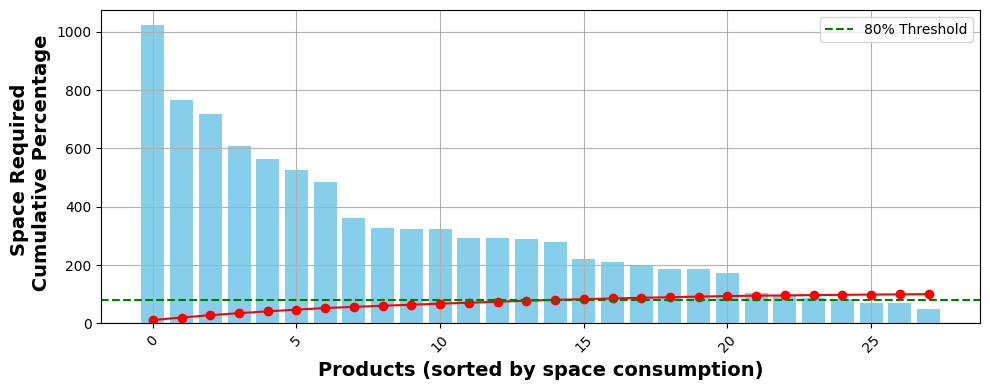

In [ ]:
def quick_warehouse_diagnosis(products_data: Dict[str, Tuple[List[int], List[float], float]]):
    """
    Quick diagnosis of warehouse capacity issues
    """
    print("=== QUICK WAREHOUSE DIAGNOSIS ===")

    # 1. Analyze product space requirements
    space_analysis = []
    for product_id, (demand_series, price_series, ref_price) in products_data.items():
        space_per_unit = max(1, int(ref_price / 15))
        avg_demand = np.mean(demand_series)
        space_required = avg_demand * space_per_unit

        space_analysis.append({
            'product_id': product_id,
            'avg_demand': avg_demand,
            'space_per_unit': space_per_unit,
            'space_required': space_required,
            'ref_price': ref_price
        })

    space_df = pd.DataFrame(space_analysis)
    space_df = space_df.sort_values('space_required', ascending=False)

    # Calculate cumulative space
    space_df['cumulative_space'] = space_df['space_required'].cumsum()
    total_space = space_df['space_required'].sum()
    space_df['percentage'] = space_df['space_required'] / total_space * 100
    space_df['cumulative_percentage'] = space_df['percentage'].cumsum()

    print(f"Total estimated space required: {total_space:.0f}")
    print(f"Typical warehouse capacity: 4412")
    print(f"Estimated utilization: {total_space / 4412 * 100:.1f}%")

    # 2. Identify top space consumers
    print("\nTop 5 space-consuming products:")
    for _, row in space_df.head().iterrows():
        print(f"  {row['product_id']}: {row['space_required']:.0f} units ({row['percentage']:.1f}%)")

    # 3. Quick recommendations
    print("\n=== RECOMMENDATIONS ===")

    # Check if it's a capacity issue
    if total_space > 4412:
        print("1. CAPACITY ISSUE: Total space requirement exceeds warehouse capacity")
        print(f"   Consider: Increasing capacity or reducing inventory levels")

    # Check Pareto distribution
    bottleneck_count = len(space_df[space_df['cumulative_percentage'] <= 80])
    print(f"2. BOTTLENECK PRODUCTS: {bottleneck_count} products account for 80% of space usage")

    # Identify specific issues
    high_space_products = space_df[space_df['space_per_unit'] > 20]
    if len(high_space_products) > 0:
        print(f"3. HIGH SPACE ITEMS: {len(high_space_products)} products with high space per unit")
        for _, row in high_space_products.head().iterrows():
            print(f"   {row['product_id']}: {row['space_per_unit']} units each")

    # Demand variability analysis
    demand_variability = []
    for product_id, (demand_series, _, _) in products_data.items():
        cv = np.std(demand_series) / np.mean(demand_series) if np.mean(demand_series) > 0 else 0
        demand_variability.append({'product_id': product_id, 'cv_demand': cv})

    variability_df = pd.DataFrame(demand_variability)
    high_variability = variability_df[variability_df['cv_demand'] > 0.5]

    if len(high_variability) > 0:
        print(f"4. HIGH DEMAND VARIABILITY: {len(high_variability)} products with unpredictable demand")
        print("   Consider: Improving demand forecasting for these products")

    return space_df

# Usage
if __name__ == "__main__":
    # Assuming you have products_data
    # products_data = prepare_weekly_data(your_dataframe)

    # Run quick diagnosis
    space_analysis = quick_warehouse_diagnosis(products_data)

    # Show Pareto chart
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(space_analysis)), space_analysis['space_required'], color='skyblue')
    plt.plot(range(len(space_analysis)), space_analysis['cumulative_percentage'], 'r-', marker='o')
    plt.axhline(y=80, color='green', linestyle='--', label='80% Threshold')
    plt.xlabel('Products (sorted by space consumption)', fontsize=14, fontweight='bold')
    plt.ylabel('Space Required \n Cumulative Percentage', fontsize=14, fontweight='bold')
    # plt.title('Pareto Analysis: Product Space Consumption')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

=== WAREHOUSE CAPACITY ANALYSIS ===

1. Running Sensitivity Analysis...


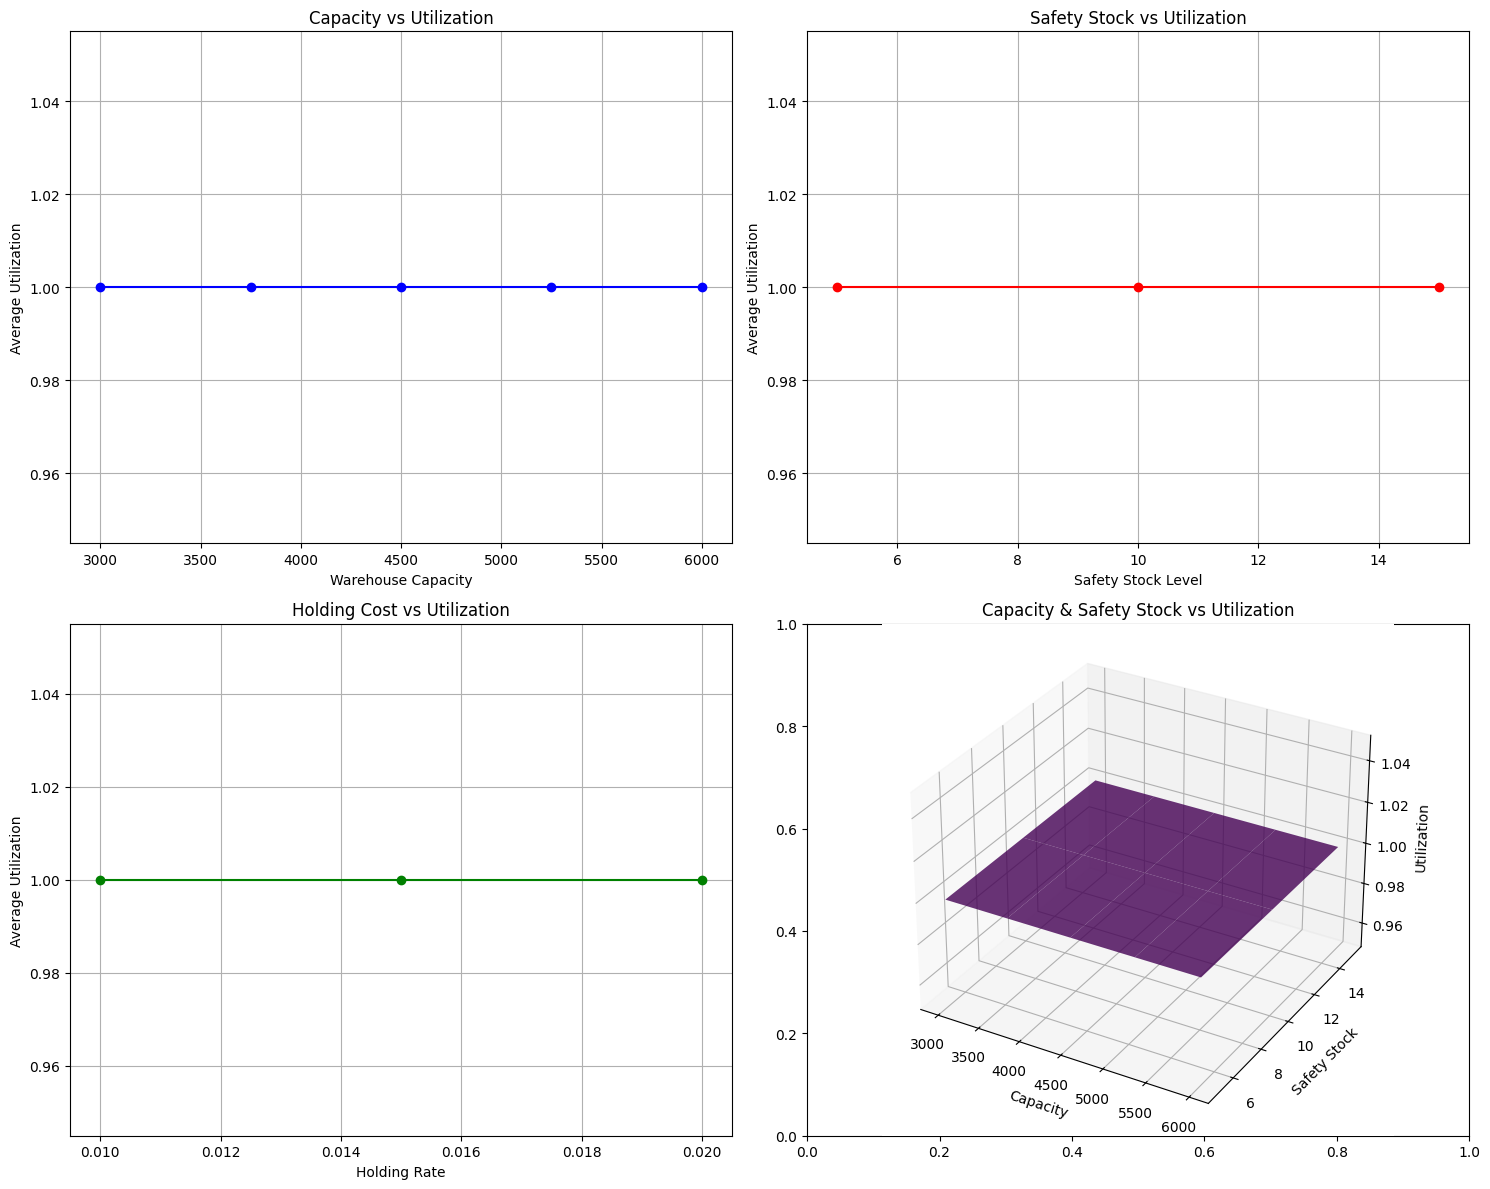


2. Running Simulation with Current Parameters...

3. Analyzing Bottlenecks...
Total space required: 75652
Warehouse capacity: 4412
Utilization rate: 1714.7%

4. Performing Pareto Analysis...


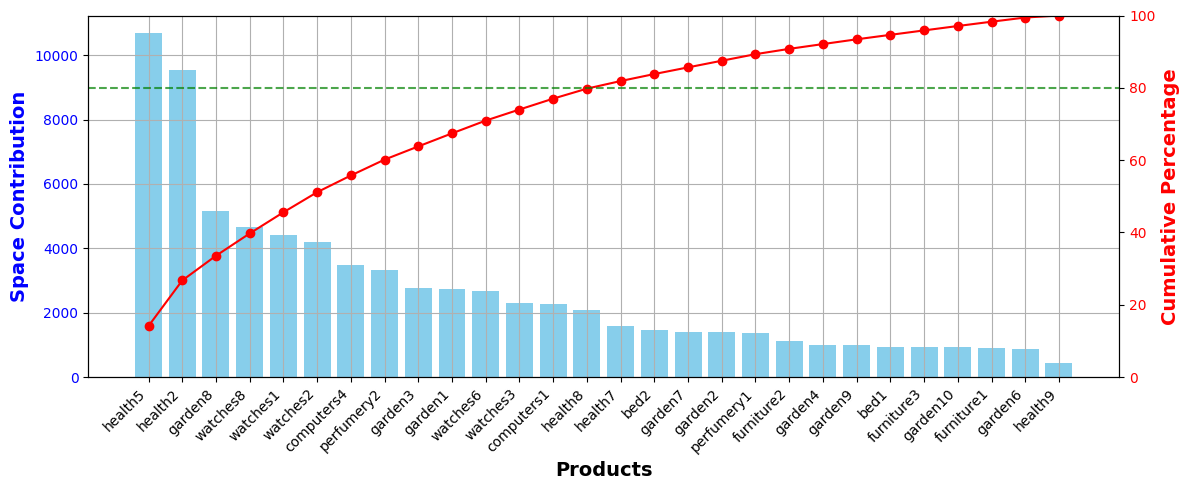


5. Identifying Bottleneck Products...
Found 14 bottleneck products contributing to 80% of space usage

6. Generating Optimization Recommendations...


KeyError: 'avg_inventory'

In [ ]:
def comprehensive_warehouse_analysis(products_data: Dict[str, Tuple[List[int], List[float], float]]):
    """
    Comprehensive analysis of warehouse capacity issues
    """
    print("=== WAREHOUSE CAPACITY ANALYSIS ===")

    # 1. Sensitivity Analysis
    print("\n1. Running Sensitivity Analysis...")
    sensitivity_results = sensitivity_analysis_warehouse_capacity(products_data, num_simulations=20)
    plot_sensitivity_results(sensitivity_results)

    # 2. Run simulation with current parameters
    print("\n2. Running Simulation with Current Parameters...")
    env = MultiProductRetailEnv(products_data)
    agents = {}

    for product_id in products_data.keys():
        agents[product_id] = SimpleAgent()

    max_weeks = max([len(demand) for demand, _, _ in products_data.values()])
    for week in range(max_weeks):
        actions = {}
        for product_id, agent in agents.items():
            product_env = env.products[product_id]['env']
            state = product_env._get_state()
            price, order_qty = agent.act(state, product_env.ref_price)
            actions[product_id] = (price, order_qty)

        env.step(actions)

    # 3. Bottleneck Analysis
    print("\n3. Analyzing Bottlenecks...")
    bottleneck_results = analyze_warehouse_bottlenecks(env)

    print(f"Total space required: {bottleneck_results['total_space_required']:.0f}")
    print(f"Warehouse capacity: {bottleneck_results['warehouse_capacity']}")
    print(f"Utilization rate: {bottleneck_results['total_space_required'] / bottleneck_results['warehouse_capacity'] * 100:.1f}%")

    # 4. Pareto Analysis
    print("\n4. Performing Pareto Analysis...")
    pareto_df = pareto_analysis_products(env)
    plotted_df = plot_pareto_analysis(pareto_df)

    # 5. Identify bottleneck products
    print("\n5. Identifying Bottleneck Products...")
    bottleneck_products = identify_bottleneck_products(plotted_df)
    print(f"Found {len(bottleneck_products)} bottleneck products contributing to 80% of space usage")

    # 6. Optimization recommendations
    print("\n6. Generating Optimization Recommendations...")
    recommendations = optimize_warehouse_utilization(env, bottleneck_products)

    return {
        'sensitivity_results': sensitivity_results,
        'bottleneck_analysis': bottleneck_results,
        'pareto_analysis': plotted_df,
        'bottleneck_products': bottleneck_products,
        'recommendations': recommendations,
        'final_utilization': env.weekly_warehouse_utilization
    }

# Usage example
if __name__ == "__main__":
    # Assuming you have products_data from your preparation function
    # products_data = prepare_weekly_data(your_dataframe)

    # Run the analysis
    analysis_results = comprehensive_warehouse_analysis(products_data)

    # Print key findings
    print("\n=== KEY FINDINGS ===")
    print(f"Average warehouse utilization: {np.mean(analysis_results['final_utilization']) * 100:.1f}%")
    print(f"Maximum warehouse utilization: {np.max(analysis_results['final_utilization']) * 100:.1f}%")

    # Show top bottleneck products
    print("\nTop bottleneck products:")
    for _, product in analysis_results['bottleneck_products'].head().iterrows():
        print(f"  {product['product_id']}: {product['percentage']:.1f}% of space")

    # Show recommendations
    print("\nTop recommendations:")
    for _, rec in analysis_results['recommendations'].head().iterrows():
        print(f"  {rec['product_id']}: {rec['recommendation']}")

# **Comparison and statistical reports**
 - Framework': OptimizedSingleProductEnv,
 - Newsvendor,
 - EOQ,
 - PPO,
 - SQL

Running statistical simulation (100 episodes)...
Running episode 1/100...
Running episode 2/100...
Running episode 3/100...
Running episode 4/100...
Running episode 5/100...
Running episode 6/100...
Running episode 7/100...
Running episode 8/100...
Running episode 9/100...
Running episode 10/100...
Running episode 11/100...
Running episode 12/100...
Running episode 13/100...
Running episode 14/100...
Running episode 15/100...
Running episode 16/100...
Running episode 17/100...
Running episode 18/100...
Running episode 19/100...
Running episode 20/100...
Running episode 21/100...
Running episode 22/100...
Running episode 23/100...
Running episode 24/100...
Running episode 25/100...
Running episode 26/100...
Running episode 27/100...
Running episode 28/100...
Running episode 29/100...
Running episode 30/100...
Running episode 31/100...
Running episode 32/100...
Running episode 33/100...
Running episode 34/100...
Running episode 35/100...
Running episode 36/100...
Running episode 37/100..

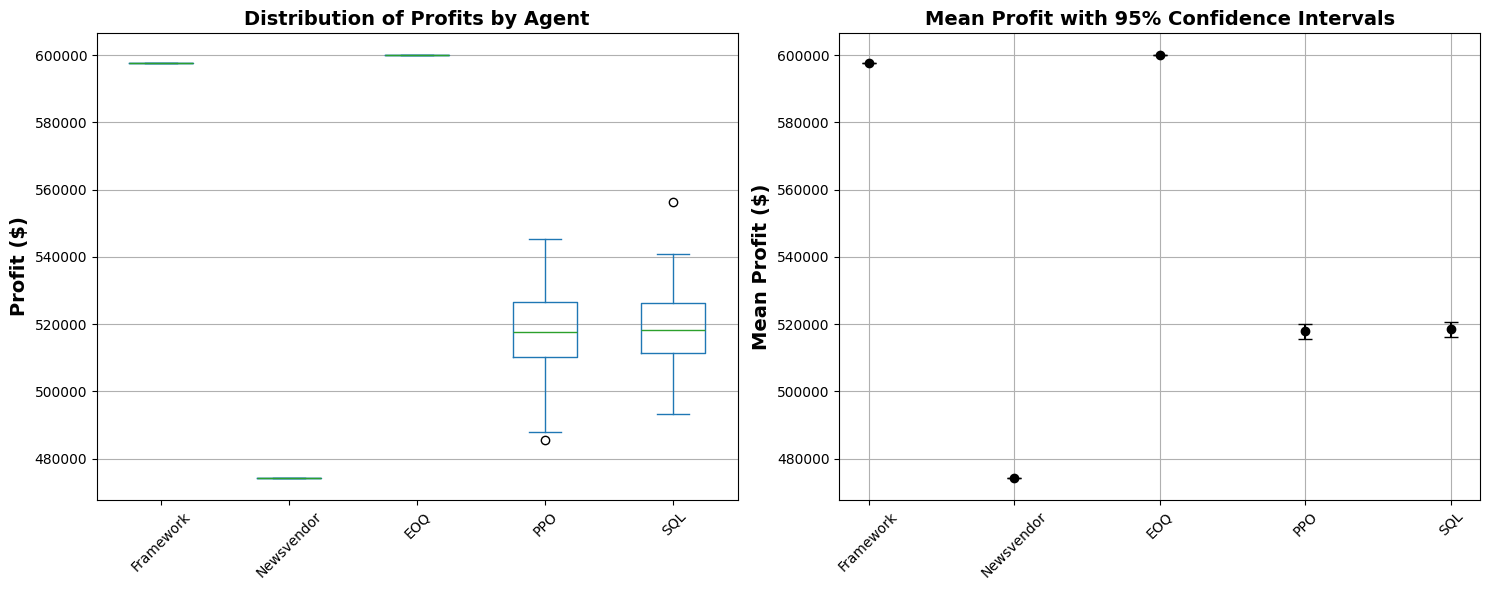

In [ ]:
class Newsvendor:
    def __init__(self, demand_series: List[int], unit_cost: float = 1.0, unit_price: float = 5.0, stockout_cost: float = 2.0):
        self.demand_series = demand_series
        self.unit_cost = unit_cost
        self.unit_price = unit_price
        self.stockout_cost = stockout_cost
        self.current_week = 0
        self.inventory = 0

    def reset(self):
        self.current_week = 0
        self.inventory = 0

    def step(self):
        if self.current_week >= len(self.demand_series):
            return 0.0, 0.0

        demand = self.demand_series[self.current_week]

        order_qty = int(np.mean(self.demand_series))
        self.inventory += order_qty

        sales = min(self.inventory, demand)
        revenue = sales * self.unit_price
        ordering_cost = order_qty * self.unit_cost
        holding_cost = max(0, self.inventory - sales) * 0.1
        stockout_cost = max(0, demand - sales) * self.stockout_cost

        profit = revenue - ordering_cost - holding_cost - stockout_cost
        self.inventory -= sales

        service_level = sales / demand if demand > 0 else 1.0
        self.current_week += 1

        return profit, service_level

class EOQPolicy:
    def __init__(self, demand_series: List[int], unit_cost: float = 1.0, unit_price: float = 5.0,
                 holding_rate: float = 0.1, order_cost: float = 10.0):
        self.demand_series = demand_series
        self.unit_cost = unit_cost
        self.unit_price = unit_price
        self.holding_rate = holding_rate
        self.order_cost = order_cost
        self.current_week = 0
        self.inventory = 0
        self.reorder_point = 0

        avg_demand = np.mean(demand_series)
        self.eoq = int(np.sqrt(2 * avg_demand * order_cost / (unit_cost * holding_rate))) if avg_demand > 0 else 0
        self.reorder_point = int(avg_demand * 2)

    def reset(self):
        self.current_week = 0
        self.inventory = 100

    def step(self):
        if self.current_week >= len(self.demand_series):
            return 0.0, 0.0

        demand = self.demand_series[self.current_week]

        if self.inventory <= self.reorder_point:
            self.inventory += self.eoq

        sales = min(self.inventory, demand)
        revenue = sales * self.unit_price
        holding_cost = self.inventory * self.unit_cost * self.holding_rate / 52  # Weekly holding cost
        ordering_cost = self.order_cost if self.inventory <= self.reorder_point else 0

        profit = revenue - holding_cost - ordering_cost
        self.inventory -= sales

        service_level = sales / demand if demand > 0 else 1.0
        self.current_week += 1

        return profit, service_level

class PPOAgent:
    def __init__(self, demand_series: List[int], state_size=4, action_size=10, hidden_size=32, lr=0.001):
        self.demand_series = demand_series
        self.state_size = state_size
        self.action_size = action_size
        self.current_week = 0
        self.inventory = 100
        self.unit_price = 5.0
        self.unit_cost = 1.0

        self.actor = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size),
            nn.Softmax(dim=-1))

        self.critic = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1))

        self.optimizer = optim.Adam(list(self.actor.parameters()) + list(self.critic.parameters()), lr=lr)
        self.memory = []
        self.gamma = 0.99

    def reset(self):
        self.current_week = 0
        self.inventory = 100
        self.memory = []

    def get_state(self):
        if self.current_week >= len(self.demand_series):
            return [0, 0, 0, 0]

        return [
            self.current_week / len(self.demand_series),
            self.inventory / 200,
            self.demand_series[self.current_week] / 50,
            np.mean(self.demand_series[max(0, self.current_week-4):self.current_week+1]) / 50 if self.current_week > 0 else 0.5]

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        probs = self.actor(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def step(self):
        if self.current_week >= len(self.demand_series):
            return 0.0, 0.0

        state = self.get_state()
        action_idx, log_prob = self.select_action(state)
        order_qty = (action_idx + 1) * 10

        demand = self.demand_series[self.current_week]
        self.inventory += order_qty
        sales = min(self.inventory, demand)

        revenue = sales * self.unit_price
        cost = order_qty * self.unit_cost
        profit = revenue - cost

        self.inventory -= sales

        service_level = sales / demand if demand > 0 else 1.0
        self.current_week += 1

        next_state = self.get_state()
        self.memory.append((state, action_idx, log_prob, profit, next_state))

        return profit, service_level

    def update(self):
        if len(self.memory) == 0:
            return

        states, actions, old_log_probs, rewards, next_states = zip(*self.memory)

        states = torch.FloatTensor(states)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        with torch.no_grad():
            values = self.critic(states).squeeze()
            next_values = self.critic(next_states).squeeze()
            advantages = rewards + self.gamma * next_values - values

        probs = self.actor(states)
        dist = torch.distributions.Categorical(probs)
        new_log_probs = dist.log_prob(torch.LongTensor(actions))

        ratio = torch.exp(new_log_probs - torch.cat(old_log_probs))
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 0.8, 1.2) * advantages

        actor_loss = -torch.min(surr1, surr2).mean()
        critic_loss = F.mse_loss(values, rewards + self.gamma * next_values)

        loss = actor_loss + 0.5 * critic_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.memory = []

class SQLAgent:
    def __init__(self, demand_series: List[int], state_size=4, action_size=10, hidden_size=32, lr=0.001, temp=1.0):
        self.demand_series = demand_series
        self.state_size = state_size
        self.action_size = action_size
        self.temp = temp
        self.current_week = 0
        self.inventory = 100
        self.unit_price = 5.0
        self.unit_cost = 1.0

        self.q_network = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size))

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.memory = []
        self.gamma = 0.99
        self.batch_size = 32

    def reset(self):
        self.current_week = 0
        self.inventory = 100
        self.memory = []

    def get_state(self):
        if self.current_week >= len(self.demand_series):
            return [0, 0, 0, 0]

        return [
            self.current_week / len(self.demand_series),
            self.inventory / 200,
            self.demand_series[self.current_week] / 50,
            np.mean(self.demand_series[max(0, self.current_week-4):self.current_week+1]) / 50 if self.current_week > 0 else 0.5]

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.q_network(state_tensor)
        probs = F.softmax(q_values / self.temp, dim=-1).detach().numpy()[0]
        return np.random.choice(self.action_size, p=probs)

    def step(self):
        if self.current_week >= len(self.demand_series):
            return 0.0, 0.0

        state = self.get_state()
        action_idx = self.select_action(state)
        order_qty = (action_idx + 1) * 10

        demand = self.demand_series[self.current_week]
        self.inventory += order_qty
        sales = min(self.inventory, demand)

        revenue = sales * self.unit_price
        cost = order_qty * self.unit_cost
        profit = revenue - cost

        self.inventory -= sales

        service_level = sales / demand if demand > 0 else 1.0
        self.current_week += 1

        next_state = self.get_state()
        self.memory.append((state, action_idx, profit, next_state))

        return profit, service_level

    def update(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        current_q = self.q_network(states).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            next_q = self.q_network(next_states)
            next_v = self.temp * torch.log(torch.sum(torch.exp(next_q / self.temp), dim=1, keepdim=True))
            target_q = rewards.unsqueeze(1) + self.gamma * next_v

        loss = F.mse_loss(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Our framework
class OptimizedSingleProductEnv:
    def __init__(self, demand_series: List[int], ref_price: float = 5.0):
        self.demand_series = demand_series
        self.ref_price = ref_price
        self.weeks = len(demand_series)
        self.current_week = 0
        self.inventory = 100
        self.unit_cost = 1.0
        self.stockout_cost = 2.0

    def reset(self):
        self.current_week = 0
        self.inventory = 100

    def step(self, price: float = None, order_qty: int = None):
        if self.current_week >= self.weeks:
            return 0.0, 0.0

        if order_qty is None:
            recent_demand = self.demand_series[max(0, self.current_week-3):self.current_week]
            order_qty = int(np.mean(recent_demand)) if recent_demand else self.demand_series[0]

        demand = self.demand_series[self.current_week]
        self.inventory += order_qty
        sales = min(self.inventory, demand)

        actual_price = price if price else self.ref_price
        revenue = sales * actual_price
        cost = order_qty * self.unit_cost
        stockout_cost = max(0, demand - sales) * self.stockout_cost

        profit = float(revenue) - float(cost) - float(stockout_cost)
        self.inventory -= sales

        service_level = sales / demand if demand > 0 else 1.0
        self.current_week += 1

        return profit, service_level


def simulate_multi_product_for_stats(products_data: Dict[str, Tuple], agents_dict, episodes=100):
    episode_results = {agent_name: [] for agent_name in agents_dict.keys()}

    for episode in range(episodes):
        print(f"Running episode {episode + 1}/{episodes}...")
        episode_profit = {agent_name: 0.0 for agent_name in agents_dict.keys()}

        for product_id, product_info in products_data.items():
            demand_series = product_info[0]
            ref_price = float(product_info[2])

            for agent_name, AgentClass in agents_dict.items():
                if agent_name == 'Framework':
                    agent = AgentClass(demand_series, ref_price=ref_price)
                elif agent_name == 'Newsvendor':
                     agent = AgentClass(demand_series, unit_cost=1.0, unit_price=ref_price, stockout_cost=2.0)
                elif agent_name == 'EOQ':
                     agent = AgentClass(demand_series, unit_cost=1.0, unit_price=ref_price, holding_rate=0.1, order_cost=10.0) # Use ref_price
                elif agent_name in ['PPO', 'SQL']:
                    agent = AgentClass(demand_series)
                    agent.unit_price = ref_price
                else:
                    raise ValueError(f"Unknown agent type: {agent_name}")

                agent.reset()
                agent_profits = []

                for _ in range(len(demand_series)):
                    try:
                        if agent_name == 'Framework':
                            order_qty = int(np.mean(demand_series)) if demand_series else 0
                            profit, service_level = agent.step(price=ref_price, order_qty=order_qty)
                        else:
                            profit, service_level = agent.step()

                        agent_profits.append(float(profit))
                    except Exception as e:
                        print(f"Error in {agent_name} for {product_id}: {e}")
                        agent_profits.append(0.0)

                total_profit_for_product = sum(agent_profits)
                episode_profit[agent_name] += total_profit_for_product

                if hasattr(agent, 'update'):
                    try:
                        agent.update()
                    except:
                        pass

        for agent_name in agents_dict.keys():
            episode_results[agent_name].append(episode_profit[agent_name])

    results_df = pd.DataFrame(episode_results)
    return results_df


if __name__ == "__main__":
    agents_dict = {
        'Framework': OptimizedSingleProductEnv,
        'Newsvendor': Newsvendor,
        'EOQ': EOQPolicy,
        'PPO': PPOAgent,
        'SQL': SQLAgent}

    print("Running statistical simulation (100 episodes)...")
    results_df = simulate_multi_product_for_stats(products_data, agents_dict, episodes=100)

    print("\n=== DESCRIPTIVE STATISTICS ===")
    print(results_df.describe())

    results_df.to_csv('agent_performance_stats.csv', index=False)

    print("\n=== STATISTICAL ANALYSIS ===")

    print("\n1. Normality Tests (Shapiro-Wilk):")
    for agent in results_df.columns:
        stat, p_value = stats.shapiro(results_df[agent])
        normal = "Normal" if p_value > 0.05 else "Not Normal"
        print(f"   {agent}: W={stat:.3f}, p={p_value:.3e} ({normal})")


    all_normal = all([stats.shapiro(results_df[agent])[1] > 0.05 for agent in results_df.columns])

    if all_normal:
        print("\n2. One-Way ANOVA (All distributions normal):")
        f_stat, p_value = stats.f_oneway(*[results_df[agent] for agent in results_df.columns])
        print(f"   F-Statistic: {f_stat:.4f}, P-Value: {p_value:.4e}")
    else:
        print("\n2. Kruskal-Wallis H-test (Non-normal distributions):")
        h_stat, p_value = stats.kruskal(*[results_df[agent] for agent in results_df.columns])
        print(f"   H-Statistic: {h_stat:.4f}, P-Value: {p_value:.4e}")

    if p_value < 0.05:
        print("   -> Significant difference found between agents")

        if all_normal:
            print("\n3. Post-hoc Analysis (Tukey's HSD):")
            results_melted = results_df.melt(var_name='Agent', value_name='Profit')
            if results_melted['Agent'].nunique() > 1:
                tukey = pairwise_tukeyhsd(endog=results_melted['Profit'], groups=results_melted['Agent'], alpha=0.05)
                print(tukey.summary())
            else:
                print("   Skipping Tukey's HSD: Only one agent group available.")
        else:
            print("\n3. Post-hoc Analysis (Dunn's Test - appropriate for non-normal data after Kruskal-Wallis):")
            print("   (Dunn's test implementation not included in this code - requires additional library like 'scikit-posthocs')")


        print("\n4. Effect Size (Eta Squared):")
        results_melted = results_df.melt(var_name='Agent', value_name='Profit')
        ss_total = np.sum((results_melted['Profit'] - results_melted['Profit'].mean())**2)
        ss_between = 0
        for agent in results_df.columns:
            group_mean = results_df[agent].mean()
            group_count = len(results_df[agent])
            ss_between += group_count * (group_mean - results_melted['Profit'].mean())**2
        eta_squared = ss_between / ss_total
        print(f"   η² = {eta_squared:.3f}")

    else:
        print("   -> No significant difference found between agents")

    print("\n5. Creating visualizations...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    results_df.plot(kind='box', ax=ax1)
    ax1.set_title('Distribution of Profits by Agent', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Profit ($)', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y')


    means = results_df.mean()
    stds = results_df.std()
    conf_int = 1.96 * stds / np.sqrt(len(results_df))

    ax2.errorbar(range(len(means)), means, yerr=conf_int, fmt='o', capsize=5, color='k')
    ax2.set_xticks(range(len(means)))
    ax2.set_xticklabels(means.index, rotation=45)
    ax2.set_title('Mean Profit with 95% Confidence Intervals', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Mean Profit ($)', fontsize=14, fontweight='bold')
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('statistical_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

Training with CTDE DQN...

=== Final Results (with CTDE) ===
CTDE_DQN: Total Profit = 51882519.14, Avg Service Level = 0.945
Framework: Total Profit = 51383481.97, Avg Service Level = 0.961
Newsvendor: Total Profit = 47411383.94, Avg Service Level = 0.894
EOQ: Total Profit = 60014893.40, Avg Service Level = 0.996
PPO: Total Profit = 51896475.40, Avg Service Level = 0.947
SQL: Total Profit = 51811293.59, Avg Service Level = 0.945


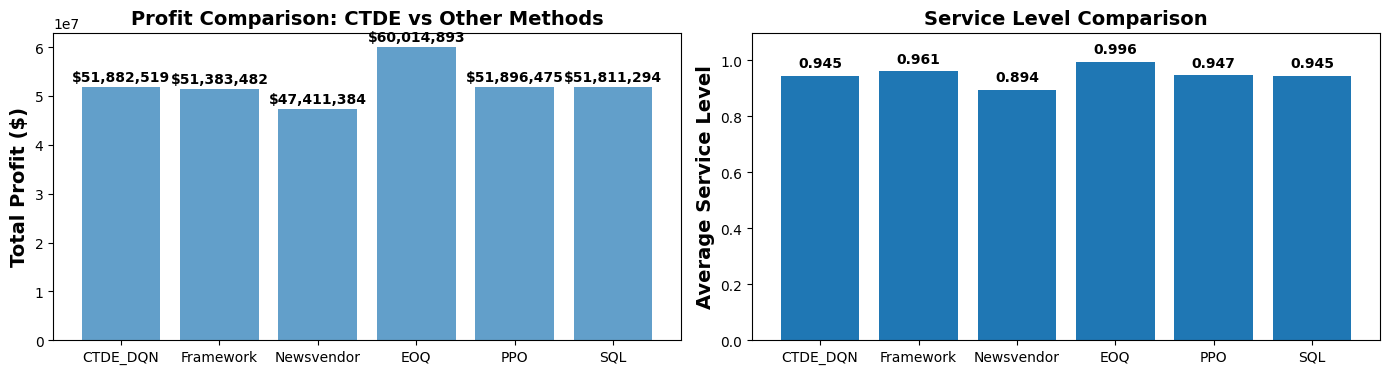

In [ ]:
class CTDE_DQNAgent:
    def __init__(self, agent_id, demand_series: List[int], n_agents=3,
                 state_size=4, action_size=10, hidden_size=64, lr=0.001):
        self.agent_id = agent_id
        self.demand_series = demand_series
        self.n_agents = n_agents
        self.state_size = state_size
        self.action_size = action_size
        self.current_week = 0
        self.inventory = 100
        self.unit_price = 5.0
        self.unit_cost = 1.0
        self.local_actor = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size))

        critic_input_size = state_size * n_agents + action_size * n_agents
        self.centralized_critic = nn.Sequential(
            nn.Linear(critic_input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1))

        self.optimizer = optim.Adam(
            list(self.local_actor.parameters()) +
            list(self.centralized_critic.parameters()),
            lr=lr)

        self.memory = []
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = 64

    def reset(self):
        self.current_week = 0
        self.inventory = 100
        self.memory = []

    def get_local_state(self):
        if self.current_week >= len(self.demand_series):
            return [0, 0, 0, 0]

        return [
            self.current_week / len(self.demand_series),
            self.inventory / 200,
            self.demand_series[self.current_week] / 50,
            np.mean(self.demand_series[max(0, self.current_week-4):self.current_week+1]) / 50
            if self.current_week > 0 else 0.5]

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)

        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.local_actor(state_tensor)
        return torch.argmax(q_values).item()

    def step(self):
        if self.current_week >= len(self.demand_series):
            return 0.0, 0.0

        state = self.get_local_state()
        action_idx = self.select_action(state)
        order_qty = (action_idx + 1) * 10

        demand = self.demand_series[self.current_week]
        self.inventory += order_qty
        sales = min(self.inventory, demand)

        revenue = sales * self.unit_price
        cost = order_qty * self.unit_cost
        profit = revenue - cost

        self.inventory -= sales

        service_level = sales / demand if demand > 0 else 1.0
        self.current_week += 1

        return profit, service_level, state, action_idx

    def remember(self, global_state, all_actions, reward, next_global_state, done):
        self.memory.append((global_state, all_actions, reward, next_global_state, done))
        if len(self.memory) > 10000:
            self.memory.pop(0)

    def centralized_update(self, all_agents):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        global_states, all_actions_list, rewards, next_global_states, dones = zip(*batch)

        global_states = torch.FloatTensor(global_states)
        rewards = torch.FloatTensor(rewards)
        next_global_states = torch.FloatTensor(next_global_states)
        dones = torch.FloatTensor(dones)

        critic_inputs = []
        next_critic_inputs = []

        for i in range(self.batch_size):
            action_input = []
            for actions in all_actions_list[i]:
                action_one_hot = torch.zeros(self.action_size)
                action_one_hot[actions] = 1
                action_input.append(action_one_hot)

            action_input = torch.cat(action_input)
            critic_input = torch.cat([global_states[i], action_input])
            critic_inputs.append(critic_input)

            next_action_input = []
            for agent in all_agents:
                with torch.no_grad():
                    next_state = next_global_states[i][agent.agent_id*self.state_size:(agent.agent_id+1)*self.state_size]
                    next_q_values = agent.local_actor(next_state.unsqueeze(0))
                    next_action = torch.argmax(next_q_values).item()
                    next_action_one_hot = torch.zeros(self.action_size)
                    next_action_one_hot[next_action] = 1
                    next_action_input.append(next_action_one_hot)

            next_action_input = torch.cat(next_action_input)
            next_critic_input = torch.cat([next_global_states[i], next_action_input])
            next_critic_inputs.append(next_critic_input)

        critic_inputs = torch.stack(critic_inputs)
        next_critic_inputs = torch.stack(next_critic_inputs)

        with torch.no_grad():
            next_q_values = self.centralized_critic(next_critic_inputs).squeeze()
            target_q = rewards + (1 - dones) * self.gamma * next_q_values

        current_q = self.centralized_critic(critic_inputs).squeeze()

        critic_loss = F.mse_loss(current_q, target_q)

        actor_loss = -current_q.mean()

        loss = critic_loss + actor_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

def get_global_state(agents):
    global_state = []
    for agent in agents:
        global_state.extend(agent.get_local_state())
    return global_state

def simulate_multi_product_ctde(products_data: Dict[str, Tuple], agents_dict, episodes=1):
    results = {agent_name: {'profit': [], 'service_level': []} for agent_name in agents_dict.keys()}

    ctde_agents_dict = {}
    for product_id, product_info in products_data.items():
        demand_series = product_info[0]
        ref_price = product_info[2]
        ctde_agents = []
        for i in range(3):
            agent = CTDE_DQNAgent(i, demand_series, n_agents=3)
            agent.unit_price = ref_price
            ctde_agents.append(agent)

        ctde_agents_dict[product_id] = ctde_agents

    for episode in range(episodes):
        for product_id, product_info in products_data.items():
            demand_series = product_info[0]
            ref_price = product_info[2]

            ctde_agents = ctde_agents_dict[product_id]

            for agent in ctde_agents:
                agent.reset()

            episode_profits = [0] * len(ctde_agents)
            episode_service_levels = [0] * len(ctde_agents)

            for step in range(len(demand_series)):
                global_state_before = get_global_state(ctde_agents)

                all_actions = []
                all_rewards = []
                all_states = []

                for agent in ctde_agents:
                    profit, service_level, state, action_idx = agent.step()
                    all_actions.append(action_idx)
                    all_rewards.append(profit)
                    all_states.append(state)

                    agent_idx = agent.agent_id
                    episode_profits[agent_idx] += profit
                    episode_service_levels[agent_idx] += service_level
                global_state_after = get_global_state(ctde_agents)

                for i, agent in enumerate(ctde_agents):
                    agent.remember(global_state_before, all_actions, all_rewards[i],
                                 global_state_after, step == len(demand_series)-1)

                for agent in ctde_agents:
                    agent.centralized_update(ctde_agents)

            avg_profit = np.mean(episode_profits)
            avg_service = np.mean(episode_service_levels) / len(demand_series)

            results['CTDE_DQN']['profit'].append(avg_profit)
            results['CTDE_DQN']['service_level'].append(avg_service)

            for agent_name, AgentClass in agents_dict.items():
                if agent_name == 'CTDE_DQN':
                    continue

                if agent_name == 'Framework':
                    agent = AgentClass(demand_series, ref_price=ref_price)
                elif agent_name == 'Newsvendor':
                    agent = AgentClass(demand_series, unit_cost=1.0, unit_price=ref_price, stockout_cost=2.0)
                elif agent_name == 'EOQ':
                    agent = AgentClass(demand_series, unit_cost=1.0, unit_price=ref_price,
                                     holding_rate=0.1, order_cost=10.0)
                elif agent_name in ['PPO', 'SQL']:
                    agent = AgentClass(demand_series)
                    agent.unit_price = ref_price

                agent.reset()
                agent_profits = []
                agent_service_levels = []

                for _ in range(len(demand_series)):
                    if agent_name == 'Framework':
                        profit, service_level = agent.step(price=ref_price)
                    else:
                        profit, service_level = agent.step()

                    agent_profits.append(profit)
                    agent_service_levels.append(service_level)

                if hasattr(agent, 'update'):
                    agent.update()

                results[agent_name]['profit'].extend(agent_profits)
                results[agent_name]['service_level'].extend(agent_service_levels)

    final_results = {}
    for agent_name, metrics in results.items():
        total_profit = np.sum(metrics['profit'])
        avg_service = np.mean(metrics['service_level'])
        final_results[agent_name] = {
            'total_profit': total_profit,
            'avg_service_level': avg_service}

    return final_results


if __name__ == "__main__":
    products_data

    agents_dict = {
        'CTDE_DQN': None,
        'Framework': OptimizedSingleProductEnv,
        'Newsvendor': Newsvendor,
        'EOQ': EOQPolicy,
        'PPO': PPOAgent,
        'SQL': SQLAgent}

    print("Training with CTDE DQN...")
    results = simulate_multi_product_ctde(products_data, agents_dict, episodes=100)

    print("\n=== Final Results (with CTDE) ===")
    for agent_name, metrics in results.items():
        print(f"{agent_name}: Total Profit = {metrics['total_profit']:.2f}, Avg Service Level = {metrics['avg_service_level']:.3f}")

    agents = list(results.keys())
    profits = [results[a]['total_profit'] for a in agents]
    service_levels = [results[a]['avg_service_level'] for a in agents]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))


    bars = ax1.bar(agents, profits, alpha=0.7)
    ax1.set_ylabel('Total Profit ($)', fontsize=14, fontweight='bold')
    ax1.set_title('Profit Comparison: CTDE vs Other Methods', fontsize=14, fontweight='bold')
    # ax1.tick_params(axis='x', rotation=45)
    ax1.grid()

    for bar, profit in zip(bars, profits):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(profits)*0.01,
                f'${profit:,.0f}', ha='center', va='bottom', fontweight='bold')

    ax2.bar(agents, service_levels)
    ax2.set_ylabel('Average Service Level', fontsize=14, fontweight='bold')
    ax2.set_title('Service Level Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylim(0, 1.1)
    ax2.grid()
    # ax2.tick_params(axis='x', rotation=45)

    for i, (agent, sl) in enumerate(zip(agents, service_levels)):
        ax2.text(i, sl + 0.02, f'{sl:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()